In [1]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

path = "../data/raw/89db51de-22a6-4033-8201-2fc37a5fe905.csv"
# load data
with open(path) as fh:
    txt = fh.read()

# split into dumps
# this marks the start of a new dataset/dataset
start_str = "#group"
dataset_txts = [start_str + dataset_txt for dataset_txt in txt.split(start_str)[1:]]

# load each as dataframe and combine
dfs = [pd.read_csv(StringIO(dataset_txt), comment="#") for dataset_txt in dataset_txts]
df = pd.concat(dfs)

In [2]:
for c in df.columns:
    print(c, len(df[c].unique()))

Unnamed: 0 1
result 1
table 37
_start 1
_stop 1
_time 14063
_value 55684
CarModel 1
GameName 1
SessionId 1
SessionTypeName 3
TrackCode 1
UserId 1
_field 13
_measurement 1
host 1
topic 3
user 1


In [3]:
df["SessionTypeName"].unique()

array(['Lone Qualify', 'Practice', 'Race'], dtype=object)

In [4]:
df["topic"].unique()

array(['racing/durandom/11227d27-7ab8-4e7c-948c-e5962a7a3735/89db51de-22a6-4033-8201-2fc37a5fe905/IRacing/zandvoort grandprix-Grand Prix/Porsche 911 GT3 Cup (992)/Lone Qualify',
       'racing/durandom/11227d27-7ab8-4e7c-948c-e5962a7a3735/89db51de-22a6-4033-8201-2fc37a5fe905/IRacing/zandvoort grandprix-Grand Prix/Porsche 911 GT3 Cup (992)/Practice',
       'racing/durandom/11227d27-7ab8-4e7c-948c-e5962a7a3735/89db51de-22a6-4033-8201-2fc37a5fe905/IRacing/zandvoort grandprix-Grand Prix/Porsche 911 GT3 Cup (992)/Race'],
      dtype=object)

In [5]:
df["table"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

<AxesSubplot:xlabel='datetime'>

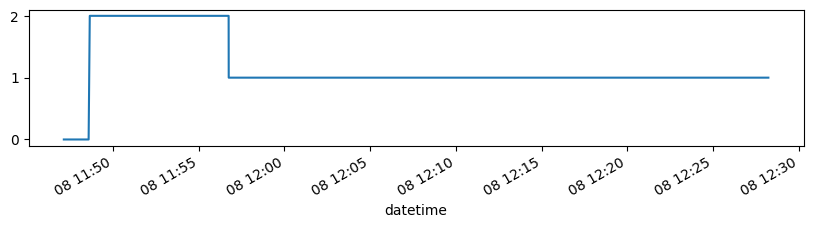

In [6]:
df["datetime"] = pd.to_datetime(df["_time"])
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)
plt.rcParams["figure.figsize"] = (10, 2)
df["SessionTypeName"].replace({"Practice": 0, "Race": 1, "Lone Qualify": 2}).plot()

In [7]:
df = df.pivot("_time", "_field", "_value")

In [8]:
import pandas as pd

df["Gear"].replace("N", 0, inplace=True)

df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

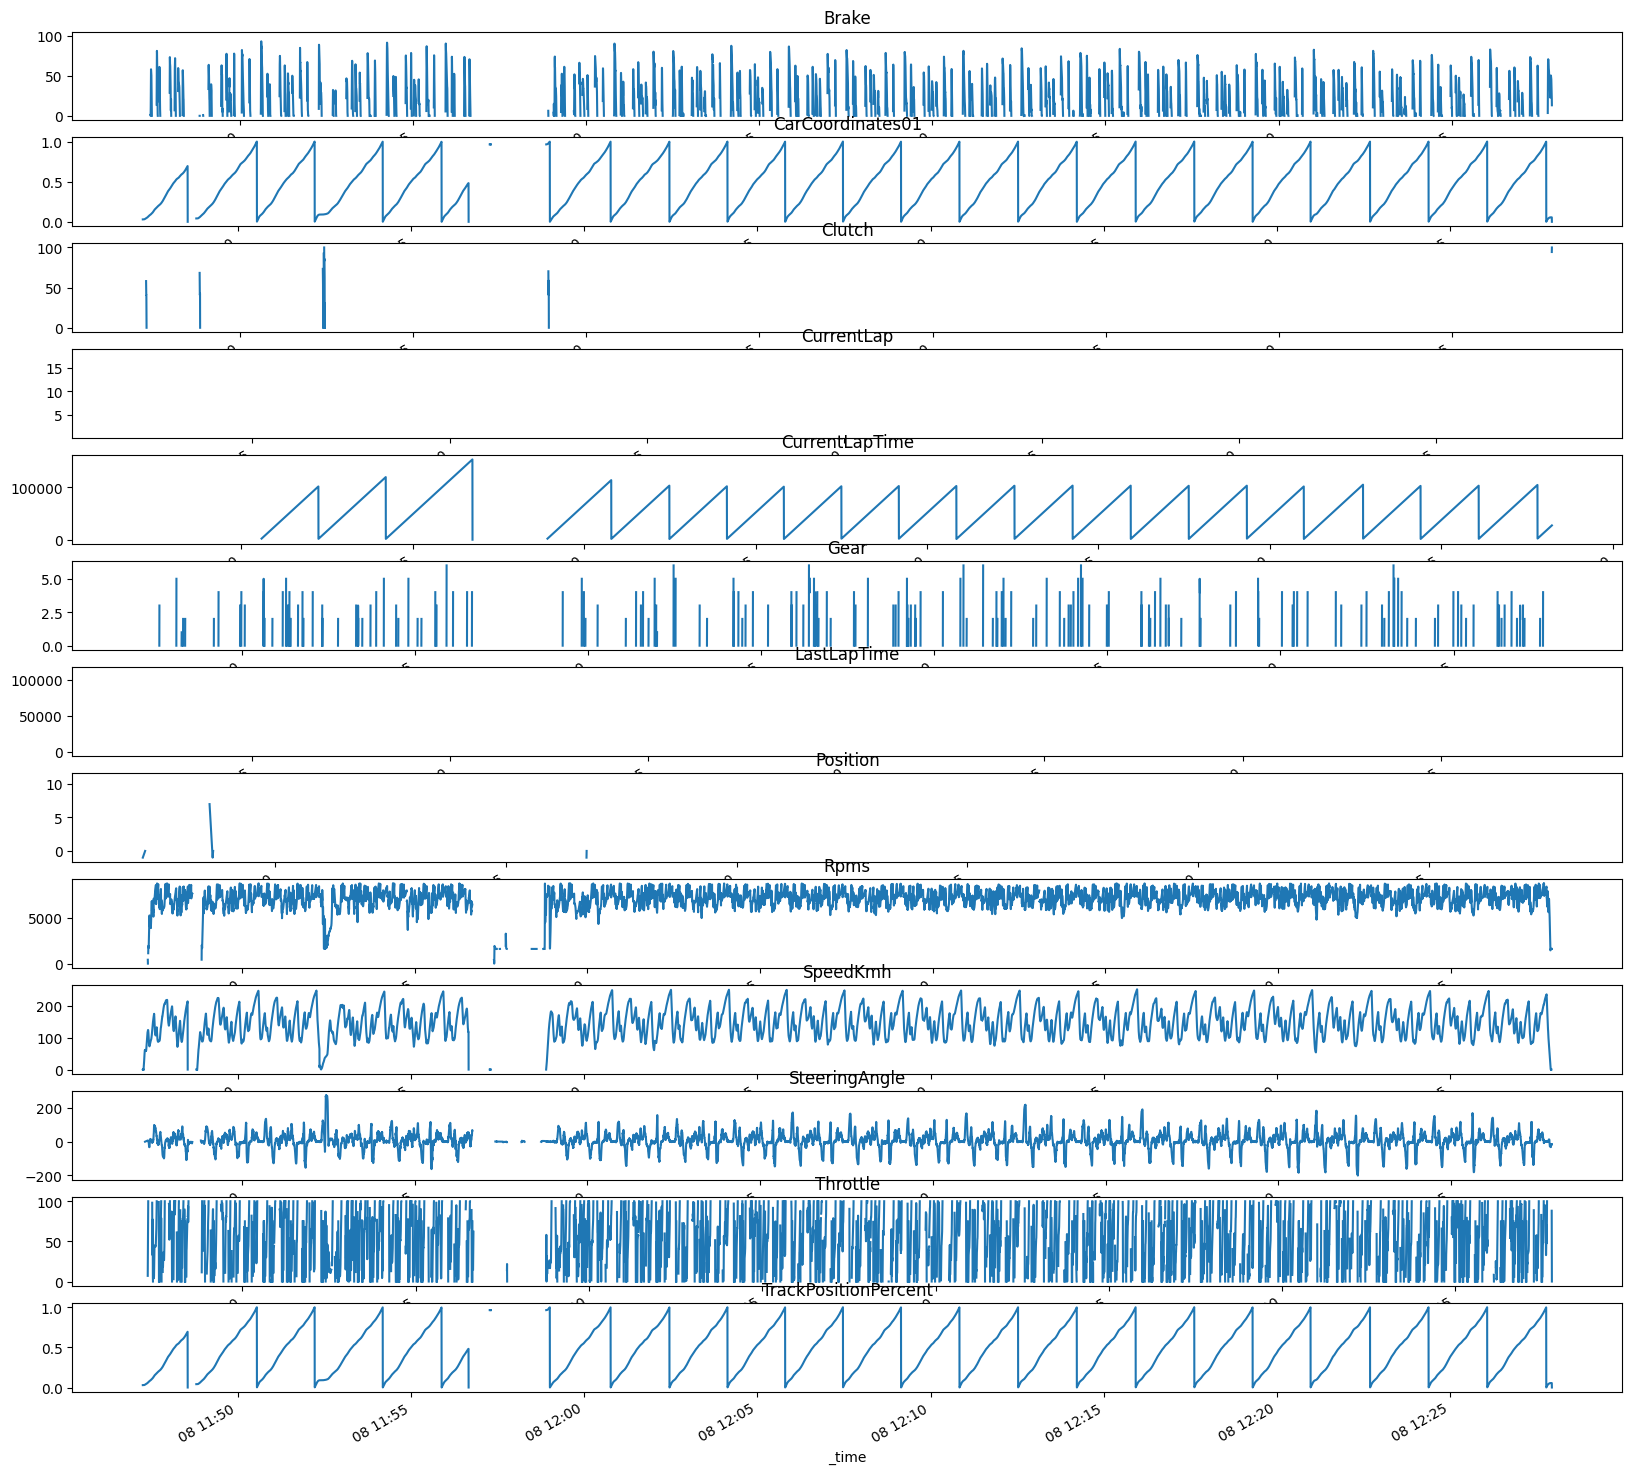

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 20)
fig, ax = plt.subplots(len(df.columns))
for i, c in enumerate(df.columns):
    df[c].astype(float).plot(ax=ax[i])
    ax[i].set_title(c)
plt.show()

In [10]:
# what is with CarCoordinates and TrackPositionPercent ?
(df["TrackPositionPercent"] - df["CarCoordinates01"]).dropna().abs().sum()

0.0

<AxesSubplot:xlabel='_time'>

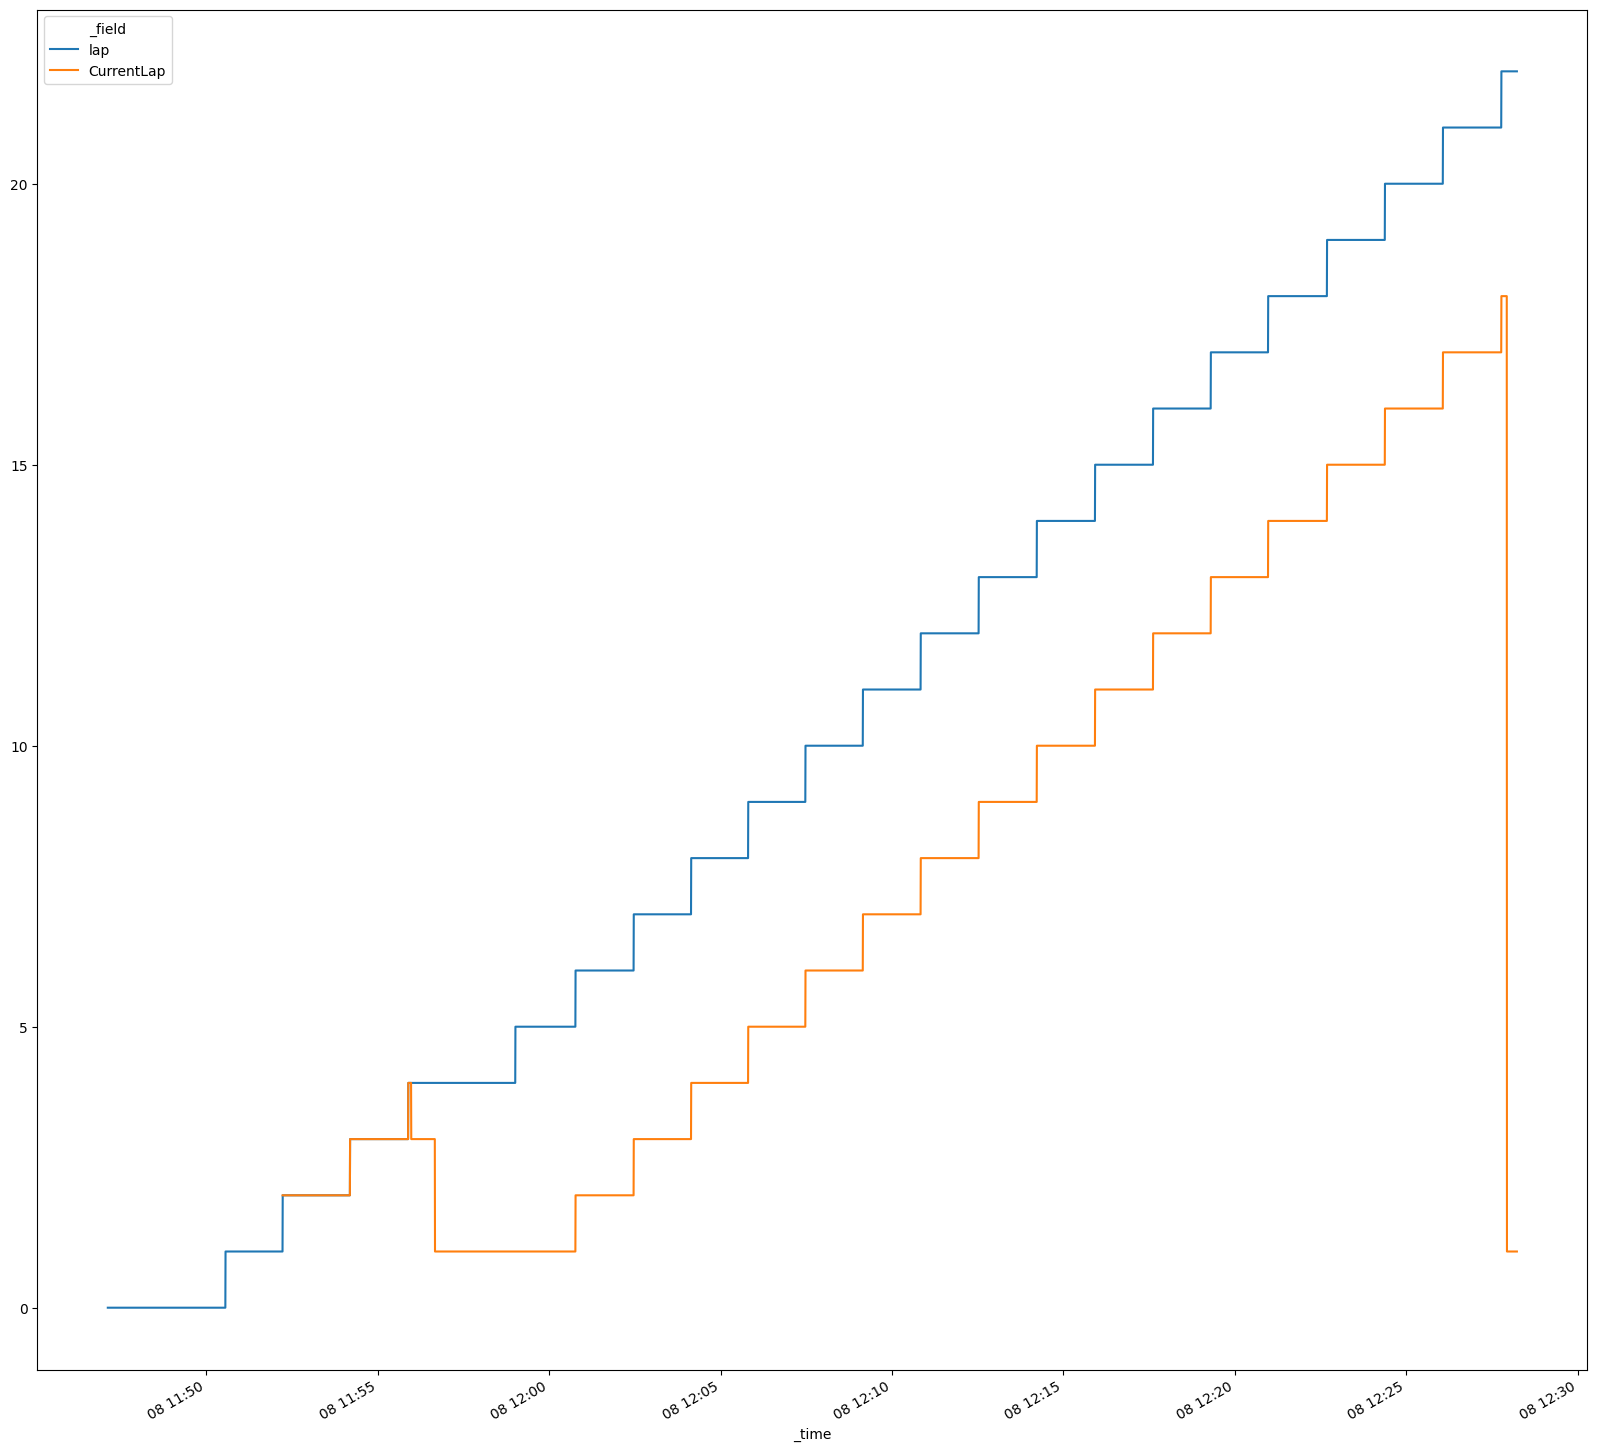

In [11]:
# Ok so lets see how we can segregate into laps
# Need to include SessionTypeName to get unique laps
# or just start a new lap everytime laptime goes down
# df['new_lap_start']  = df['CurrentLapTime'].diff() <0
df["new_lap_start"] = df["TrackPositionPercent"].diff() < -0.9
df["CurrentLap"].fillna(method="ffill", inplace=True)
df["lap"] = df["new_lap_start"].cumsum()
df[["lap", "CurrentLap"]].plot()

In [12]:
df[df["lap"] == 5]["CurrentLap"].value_counts()

1.0    628
Name: CurrentLap, dtype: int64

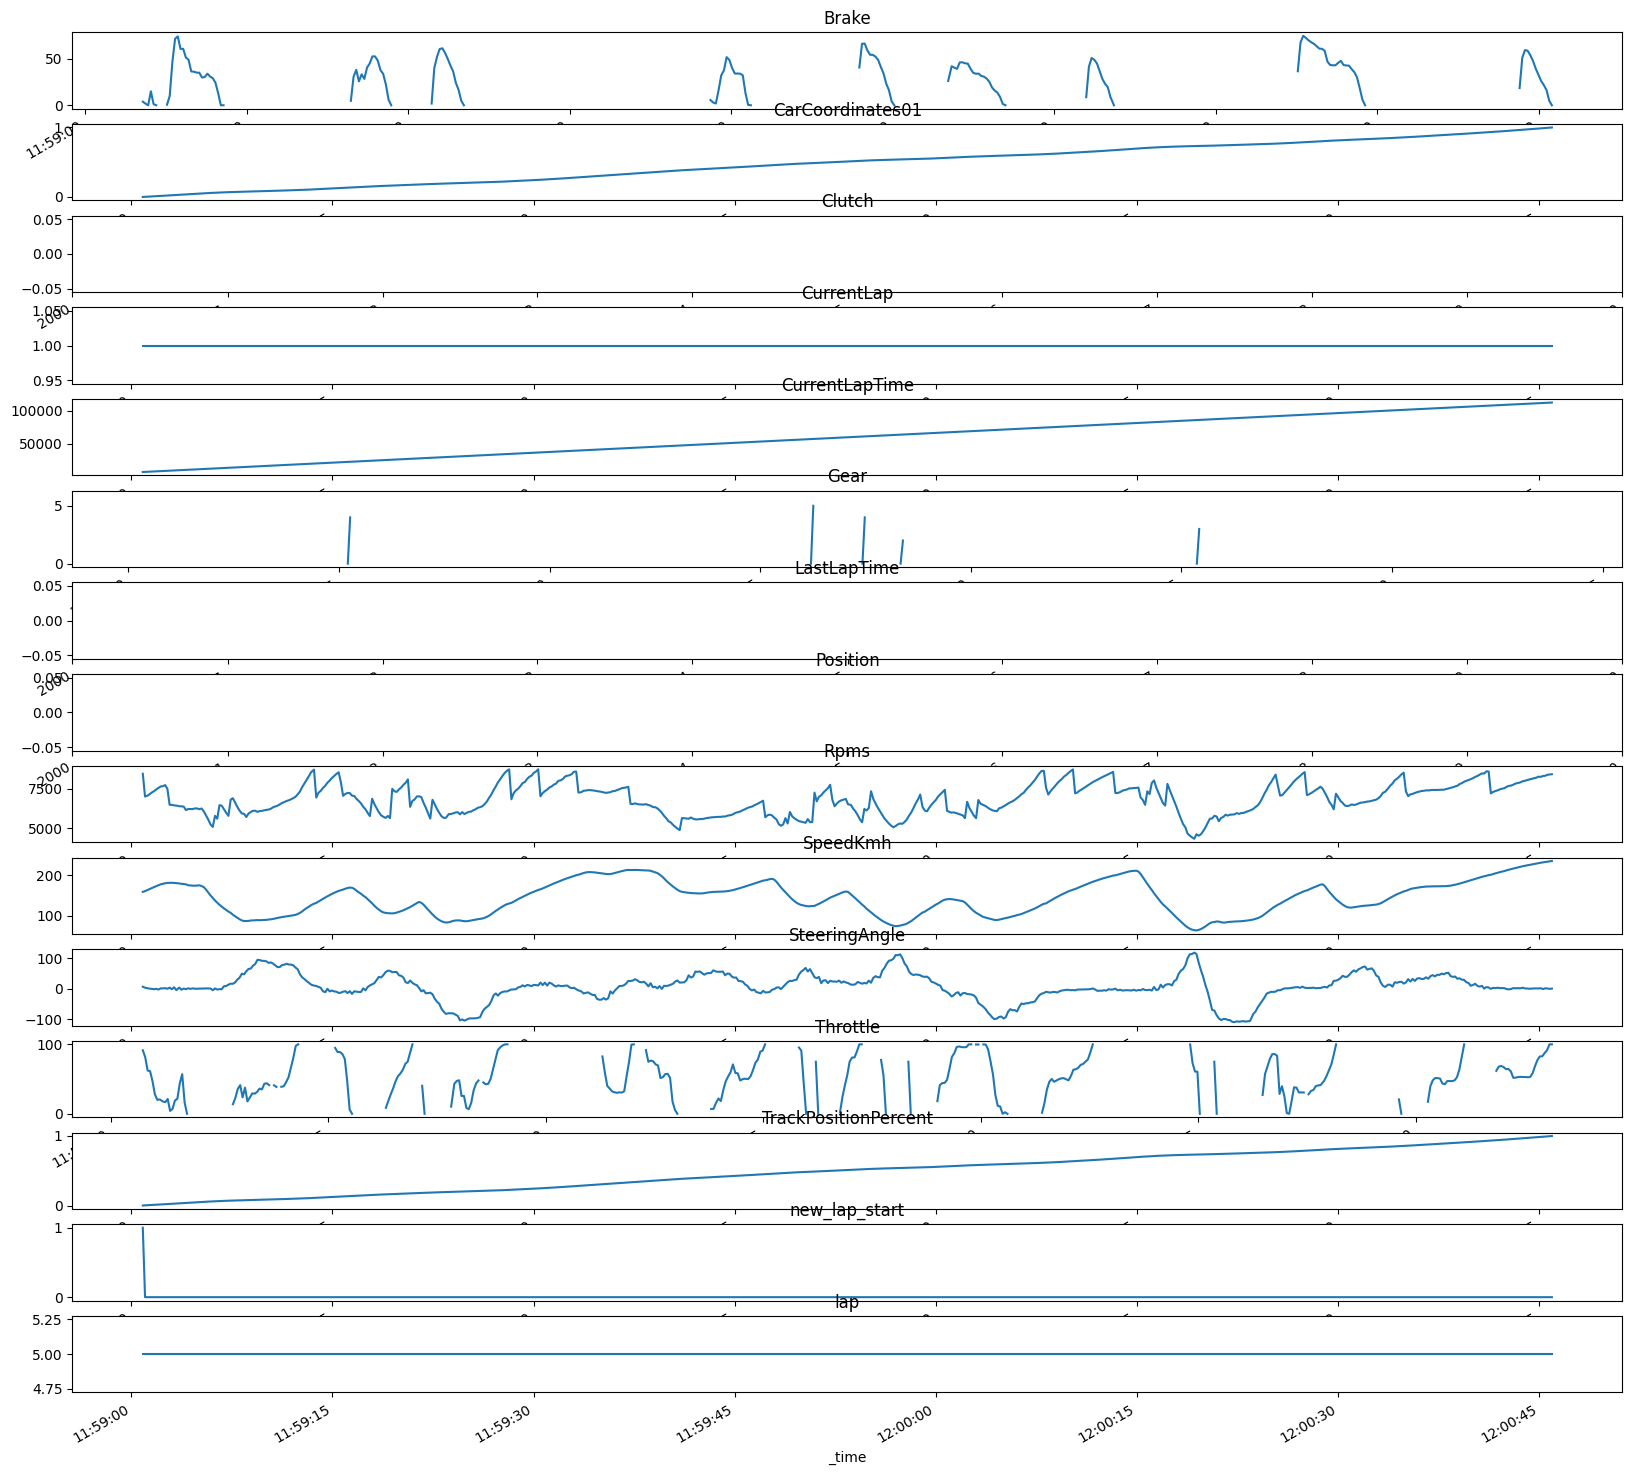

In [13]:
df[df["lap"] == 5]
plt.rcParams["figure.figsize"] = (20, 20)
fig, ax = plt.subplots(len(df.columns))
for i, c in enumerate(df.columns):
    df.loc[df["lap"] == 5, c].astype(float).plot(ax=ax[i])
    ax[i].set_title(c)
plt.show()

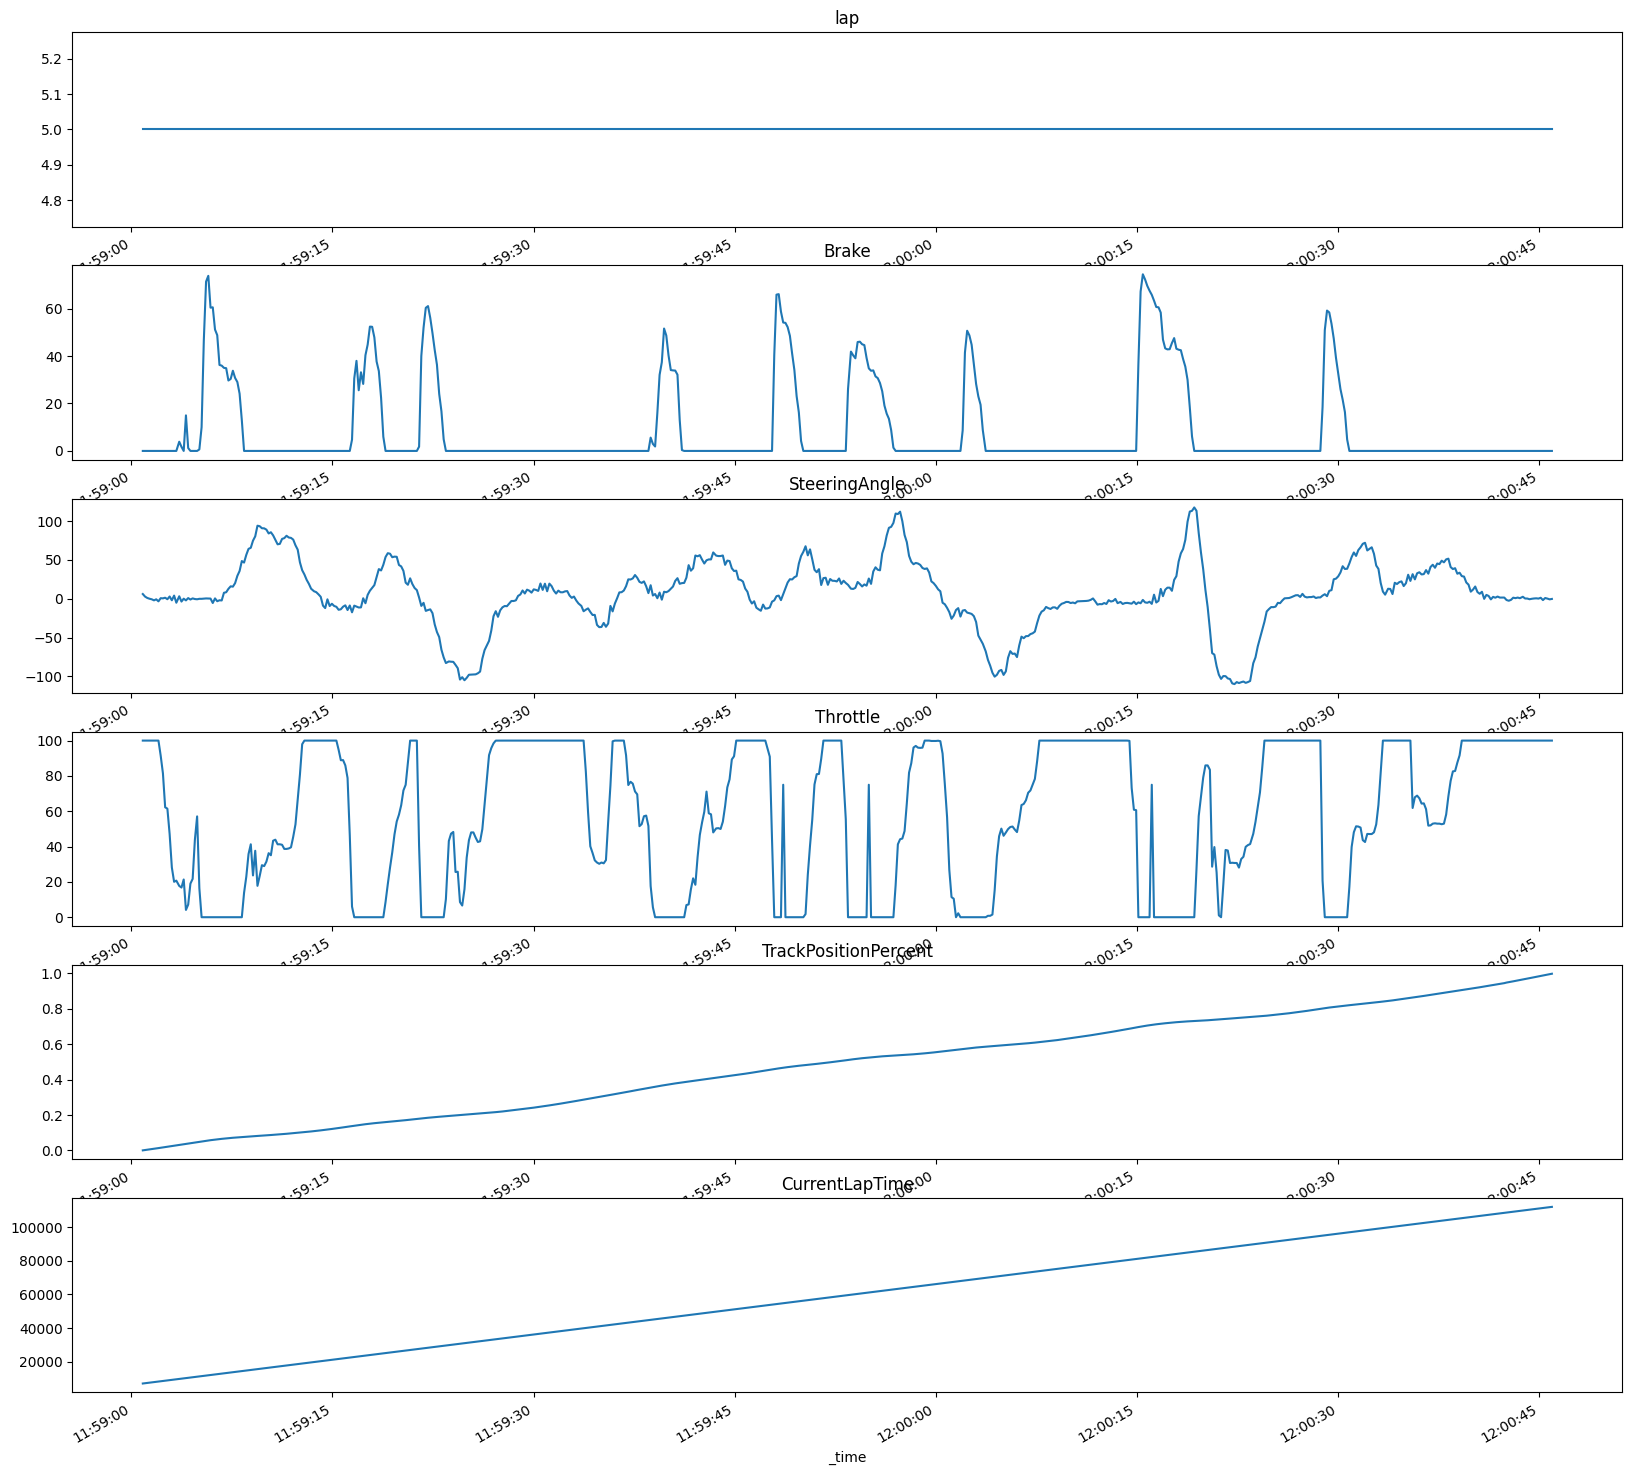

In [14]:
# keep only needed cols
df = df[
    [
        "lap",
        "Brake",
        "SteeringAngle",
        "Throttle",
        "TrackPositionPercent",
        "CurrentLapTime",
    ]
]
for c in ["Brake", "SteeringAngle", "Throttle"]:
    df[c].fillna(method="ffill", inplace=True)
plt.rcParams["figure.figsize"] = (20, 20)
fig, ax = plt.subplots(len(df.columns))
for i, c in enumerate(df.columns):
    df.loc[df["lap"] == 5, c].astype(float).plot(ax=ax[i])
    ax[i].set_title(c)
plt.show()

In [15]:
df[df["lap"] == 5]

_field                            lap  Brake  SteeringAngle  Throttle  \
_time                                                                   
2022-05-08 11:59:00.861000+00:00    5    0.0       6.043411     100.0   
2022-05-08 11:59:01.028000+00:00    5    0.0       2.771339     100.0   
2022-05-08 11:59:01.194000+00:00    5    0.0       1.001662     100.0   
2022-05-08 11:59:01.361000+00:00    5    0.0      -0.000065     100.0   
2022-05-08 11:59:01.528000+00:00    5    0.0      -0.717981     100.0   
...                               ...    ...            ...       ...   
2022-05-08 12:00:45.261000+00:00    5    0.0      -1.736364     100.0   
2022-05-08 12:00:45.428000+00:00    5    0.0       0.918184     100.0   
2022-05-08 12:00:45.598000+00:00    5    0.0       0.150169     100.0   
2022-05-08 12:00:45.761000+00:00    5    0.0      -0.801458     100.0   
2022-05-08 12:00:45.928000+00:00    5    0.0      -0.250496     100.0   

_field                           TrackPositionPercent CurrentLapTime  
_time                                                                 
2022-05-08 11:59:00.861000+00:00             0.000233         6991.0  
2022-05-08 11:59:01.028000+00:00             0.001979         7158.0  
2022-05-08 11:59:01.194000+00:00             0.003752         7324.0  
2022-05-08 11:59:01.361000+00:00             0.005551         7491.0  
2022-05-08 11:59:01.528000+00:00             0.007377         7658.0  
...                                               ...            ...  
2022-05-08 12:00:45.261000+00:00             0.988007       111391.0  
2022-05-08 12:00:45.428000+00:00             0.990545       111558.0  
2022-05-08 12:00:45.598000+00:00             0.993092       111724.0  
2022-05-08 12:00:45.761000+00:00             0.995649       111891.0  
2022-05-08 12:00:45.928000+00:00             0.998215       112058.0  

[628 rows x 6 columns]

In [16]:
df = df[df["lap"] == 5]

In [17]:
# lets see if we can interpolate the lap
import numpy as np

start, end, step = 0, 1, 0.001

x = np.arange(0, 1, 0.001)
brake = np.interp(x, df["TrackPositionPercent"], df["Brake"])
steering_angle = np.interp(x, df["TrackPositionPercent"], df["SteeringAngle"])
throttle = np.interp(x, df["TrackPositionPercent"], df["Throttle"])

df = pd.DataFrame({"x": x, "brake": brake, "steering_angle": steering_angle, "throttle": throttle})
df

x  brake  steering_angle  throttle
0    0.000    0.0        6.043411     100.0
1    0.001    0.0        4.606305     100.0
2    0.002    0.0        2.750759     100.0
3    0.003    0.0        1.752168     100.0
4    0.004    0.0        0.863346     100.0
..     ...    ...             ...       ...
995  0.995    0.0       -0.559817     100.0
996  0.996    0.0       -0.726138     100.0
997  0.997    0.0       -0.511414     100.0
998  0.998    0.0       -0.296691     100.0
999  0.999    0.0       -0.250496     100.0

[1000 rows x 4 columns]

ok this is all implemented in preprocess python file... now lets see how the processed data looks

/Users/mhild/.local/share/virtualenvs/ai-FSqG2juA/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


segment      brake  steering_angle    throttle    lap
0           0   0.000000        0.850140  100.000000  lap21
1           1   0.000000        0.734049  100.000000  lap21
2           2   0.000000        0.293584  100.000000  lap21
3           3   0.000000        0.343262  100.000000  lap21
4           4  54.291379       -0.503978   15.467385  lap21
...       ...        ...             ...         ...    ...
2295       95   0.000000        1.081387  100.000000  lap10
2296       96   0.000000        1.176702  100.000000  lap10
2297       97   0.000000        1.572176  100.000000  lap10
2298       98   0.000000        0.197147  100.000000  lap10
2299       99   0.000000        0.204188  100.000000  lap10

[2300 rows x 5 columns]

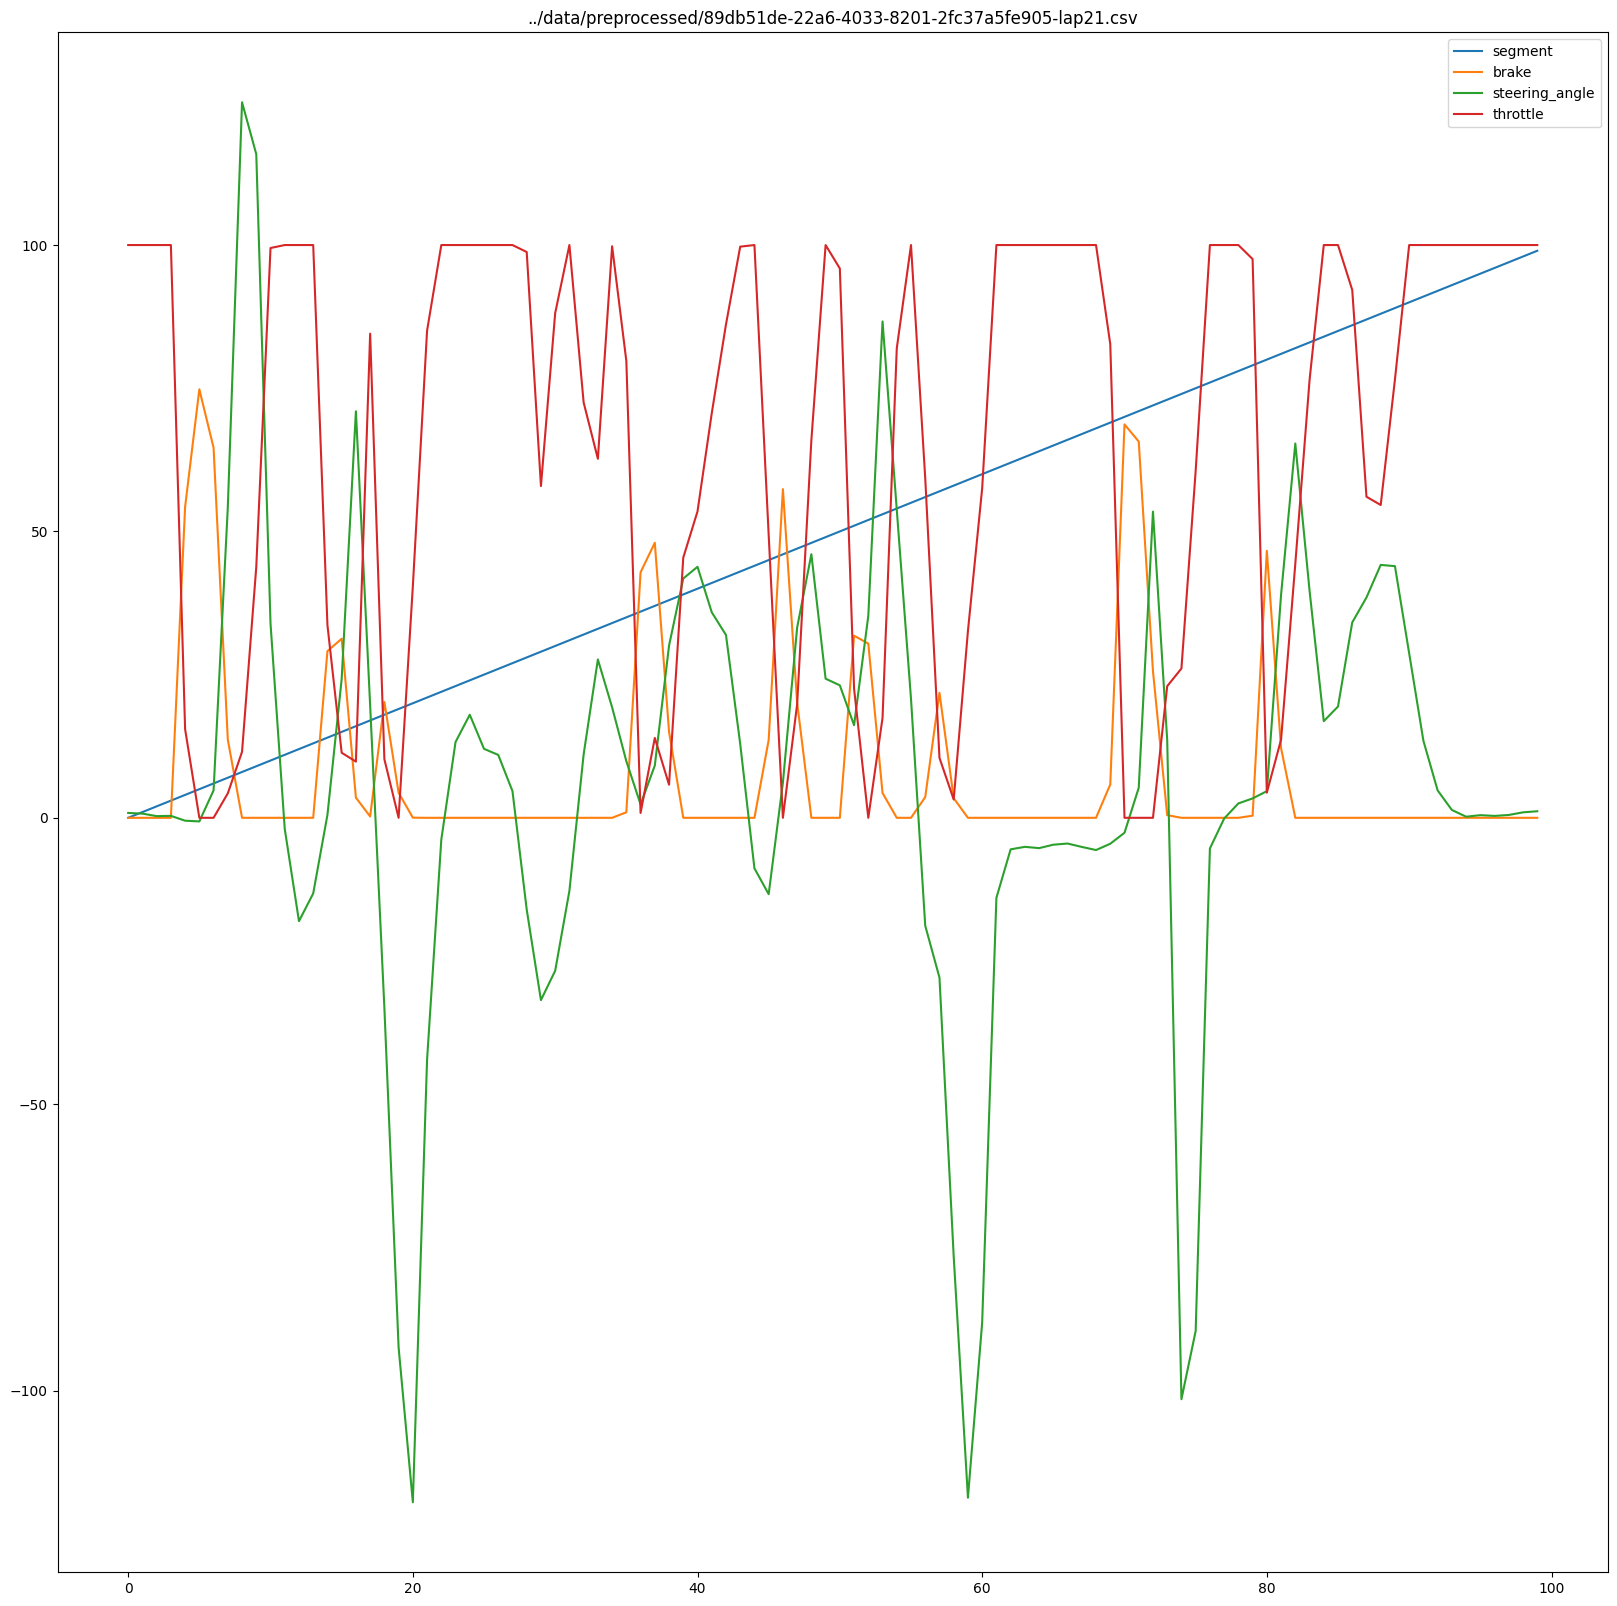

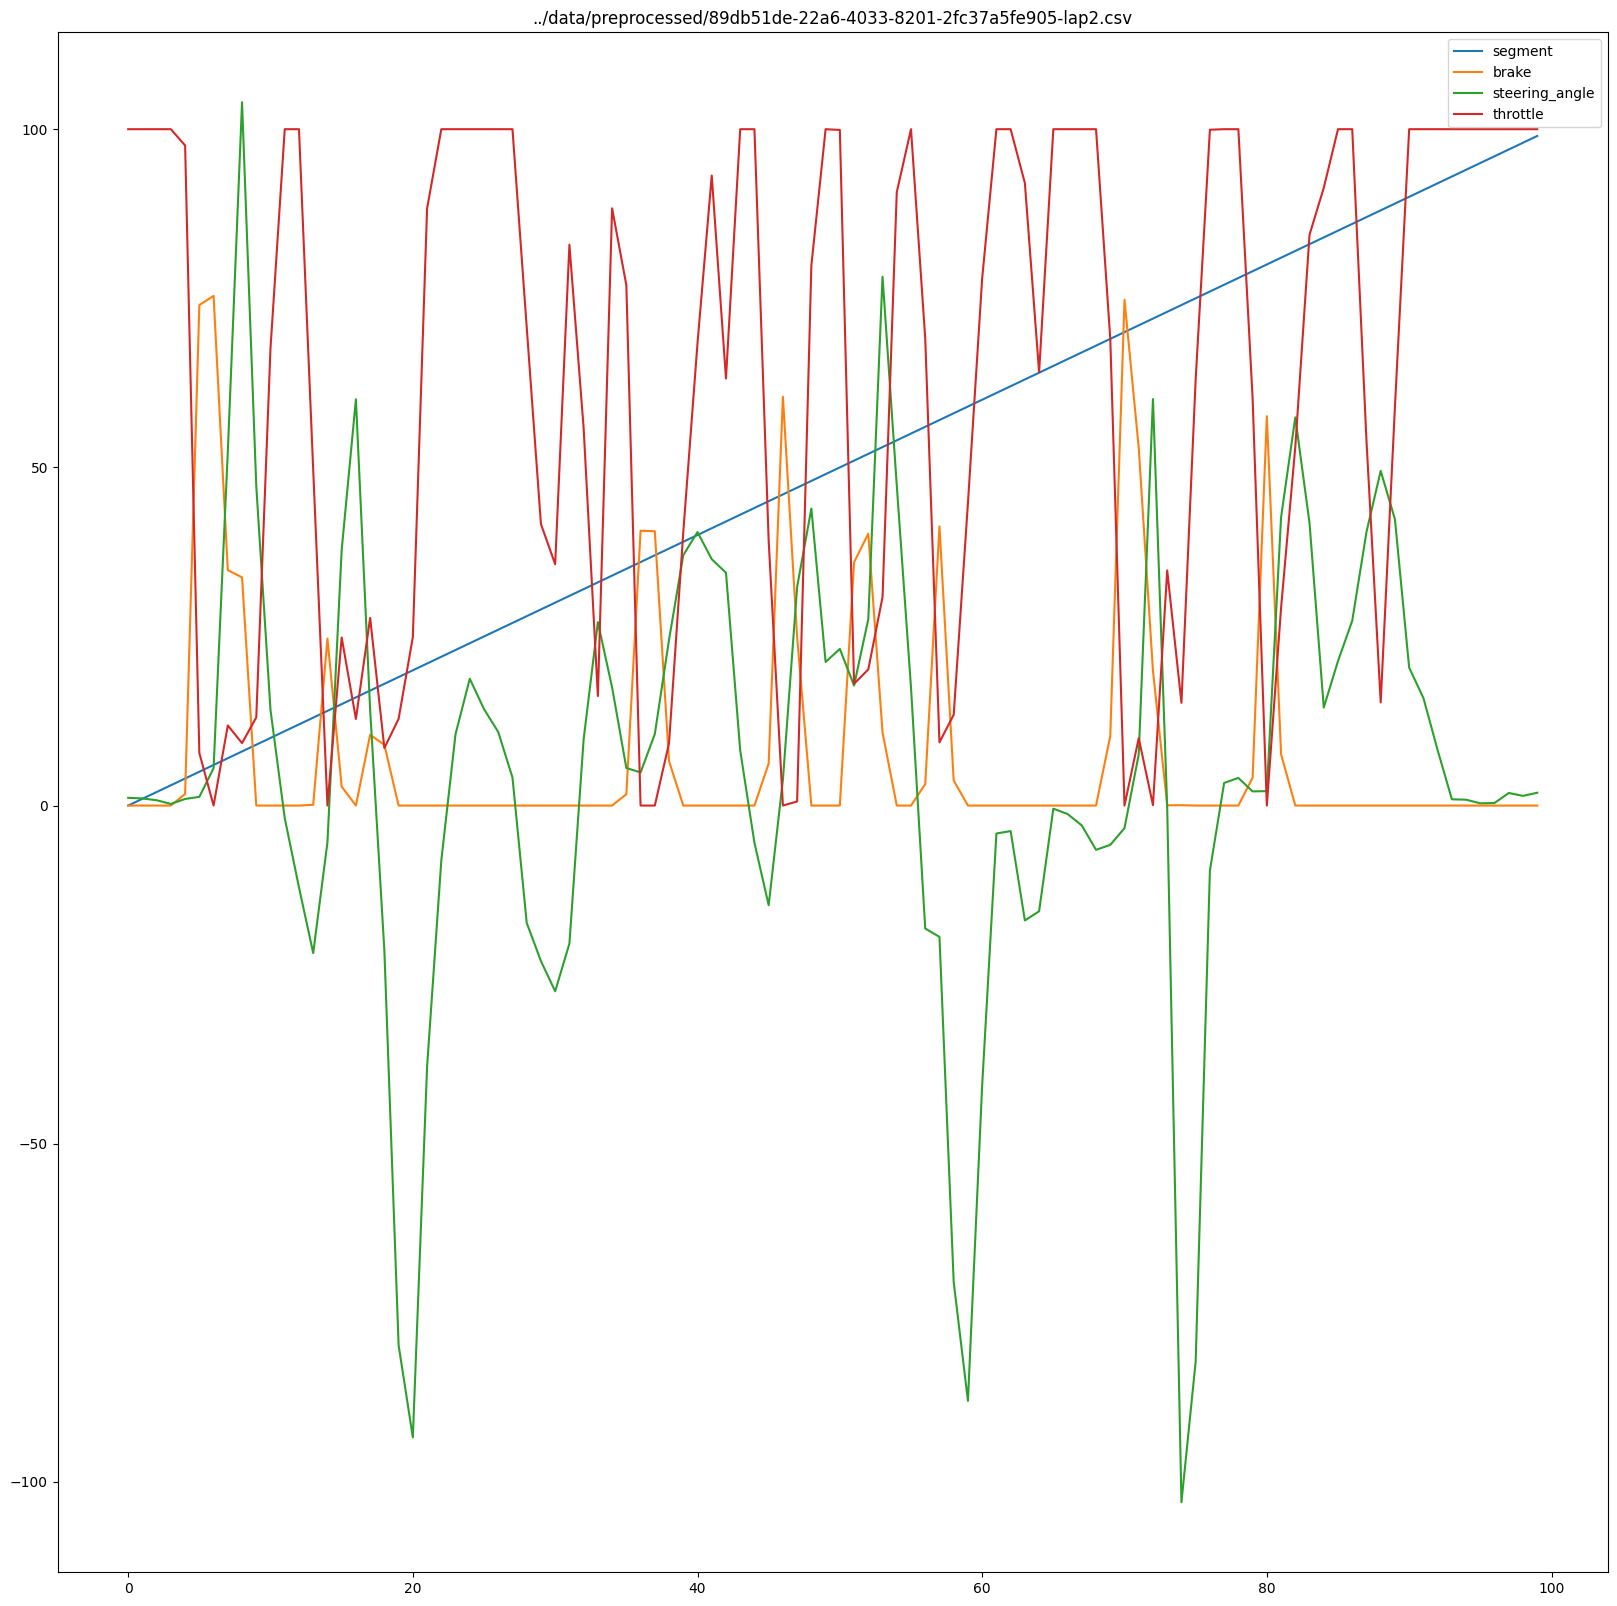

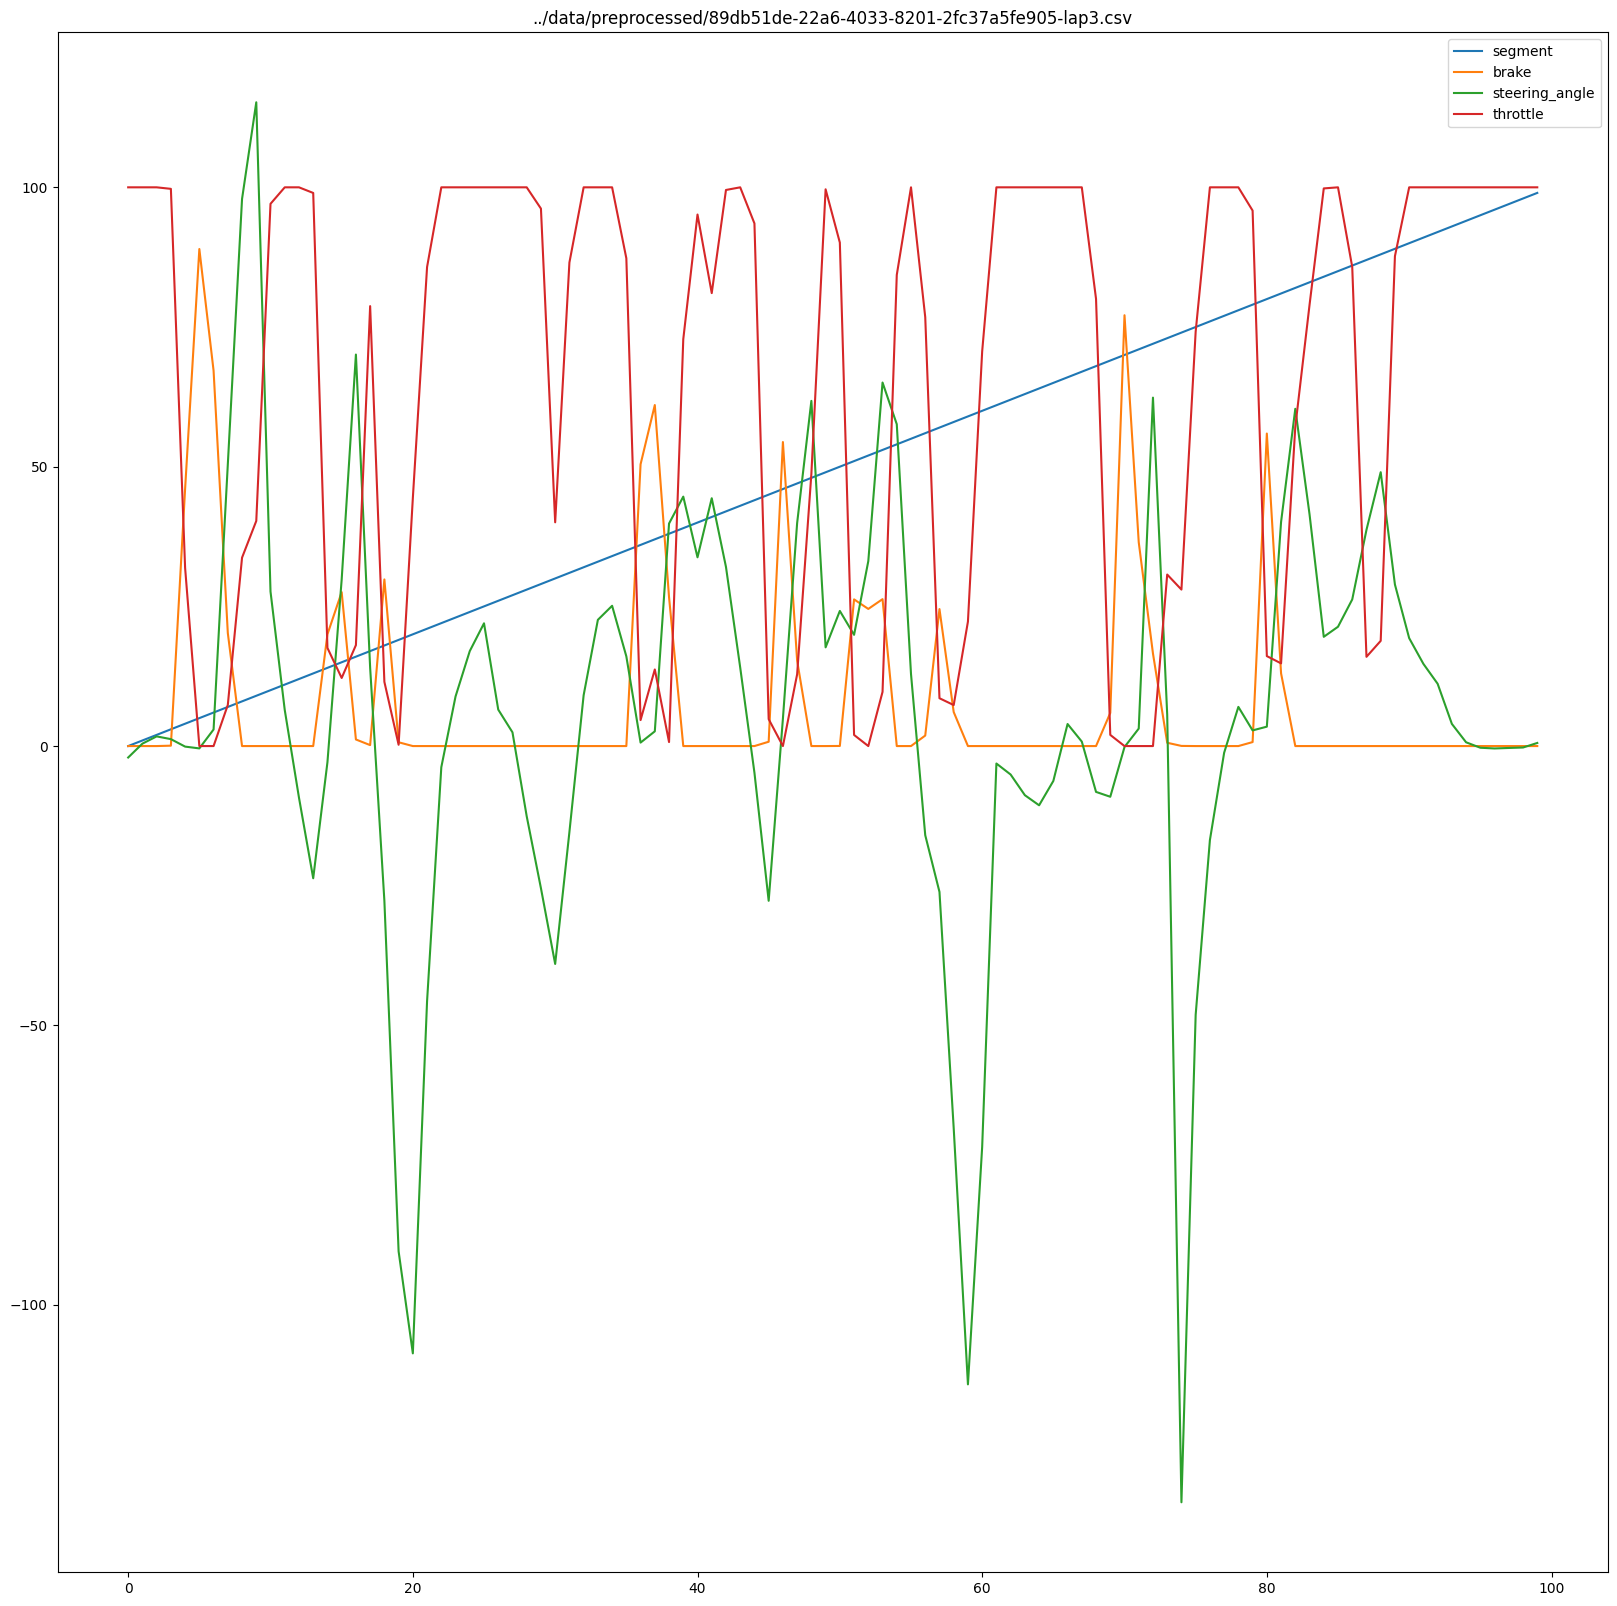

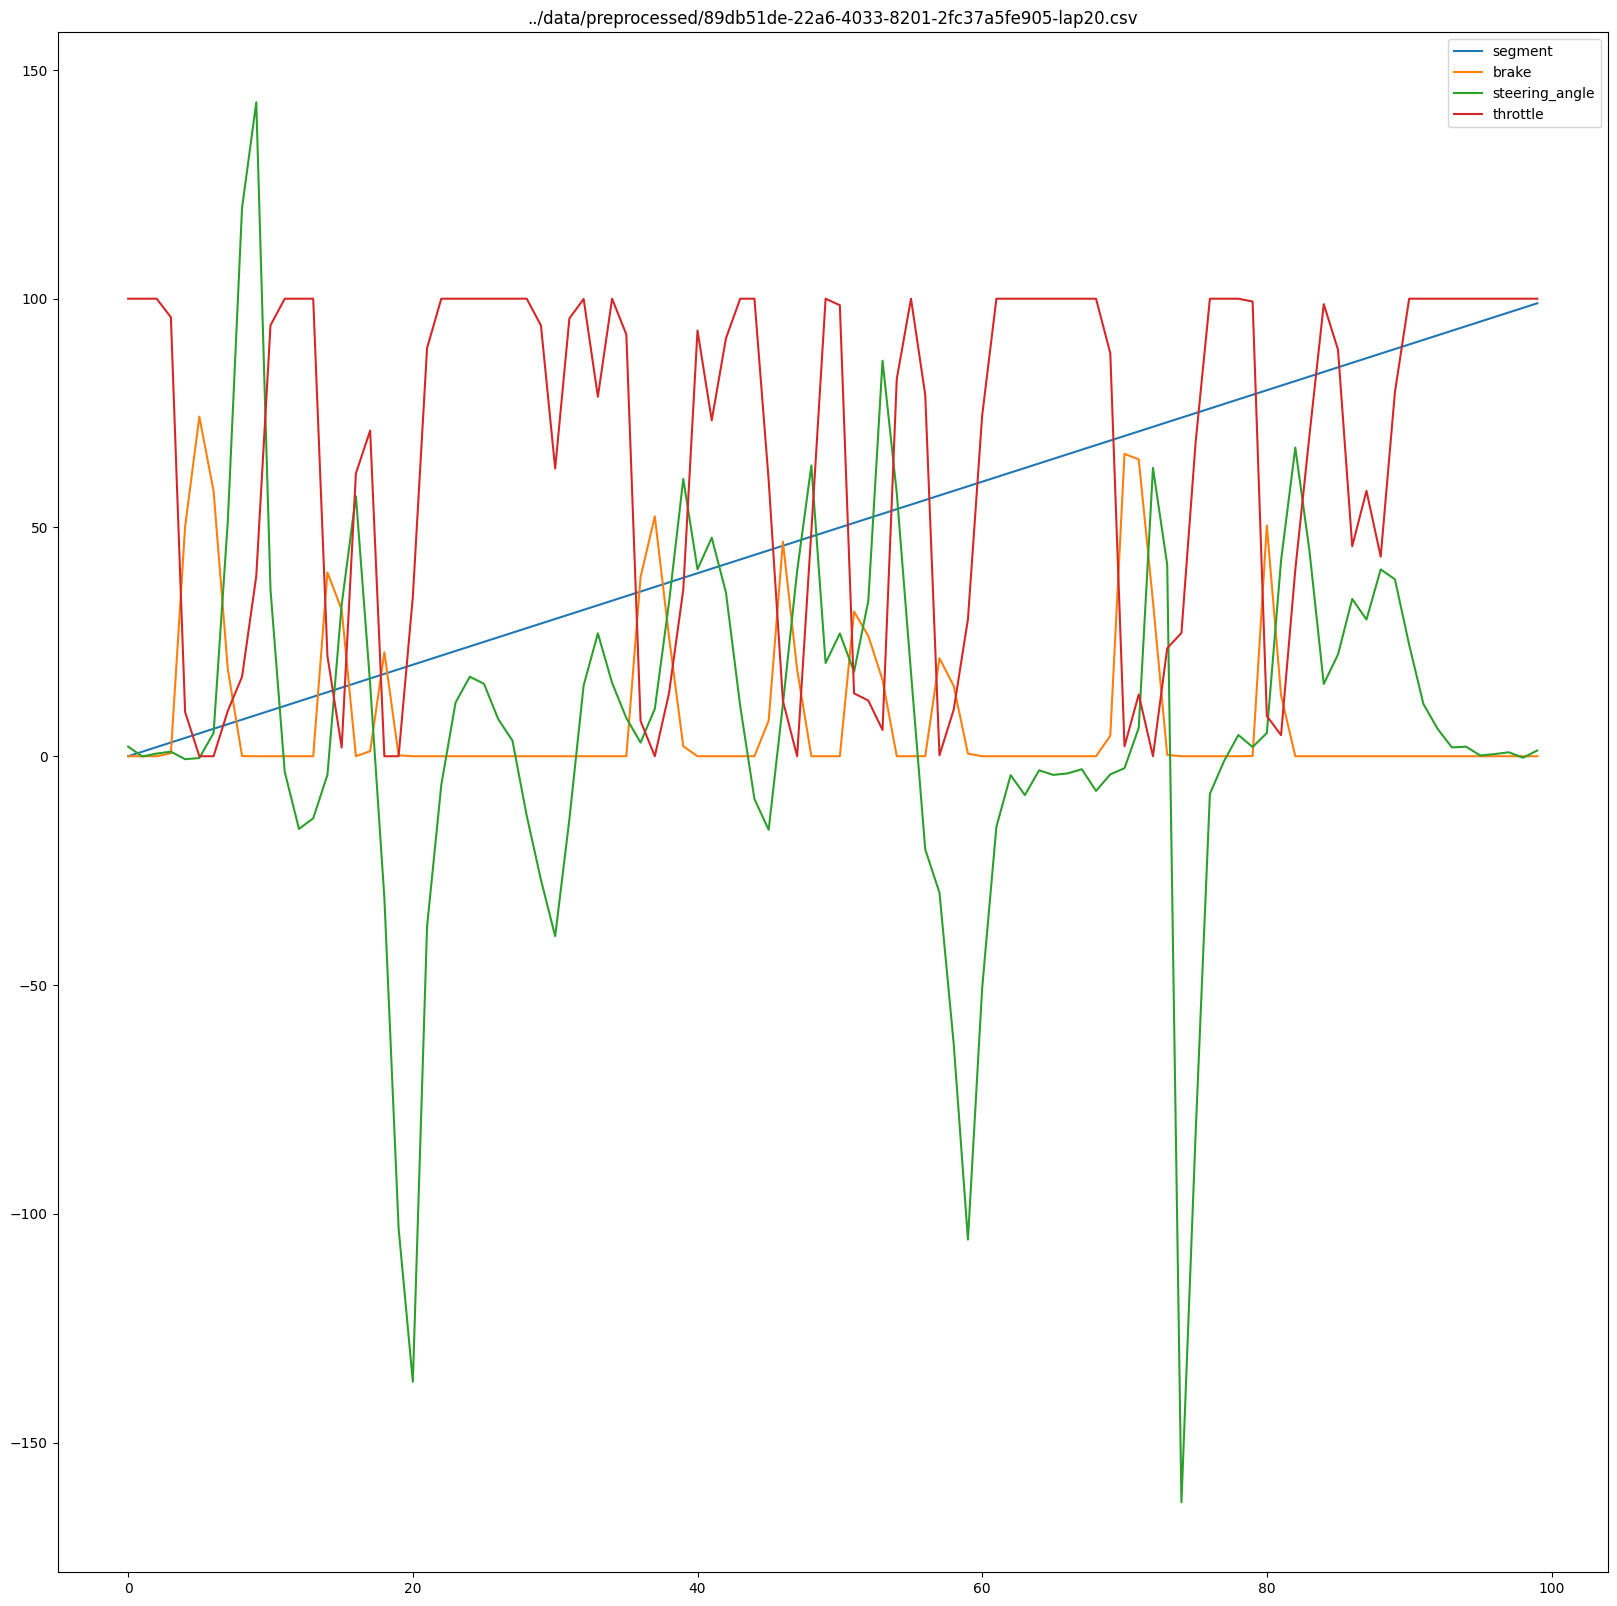

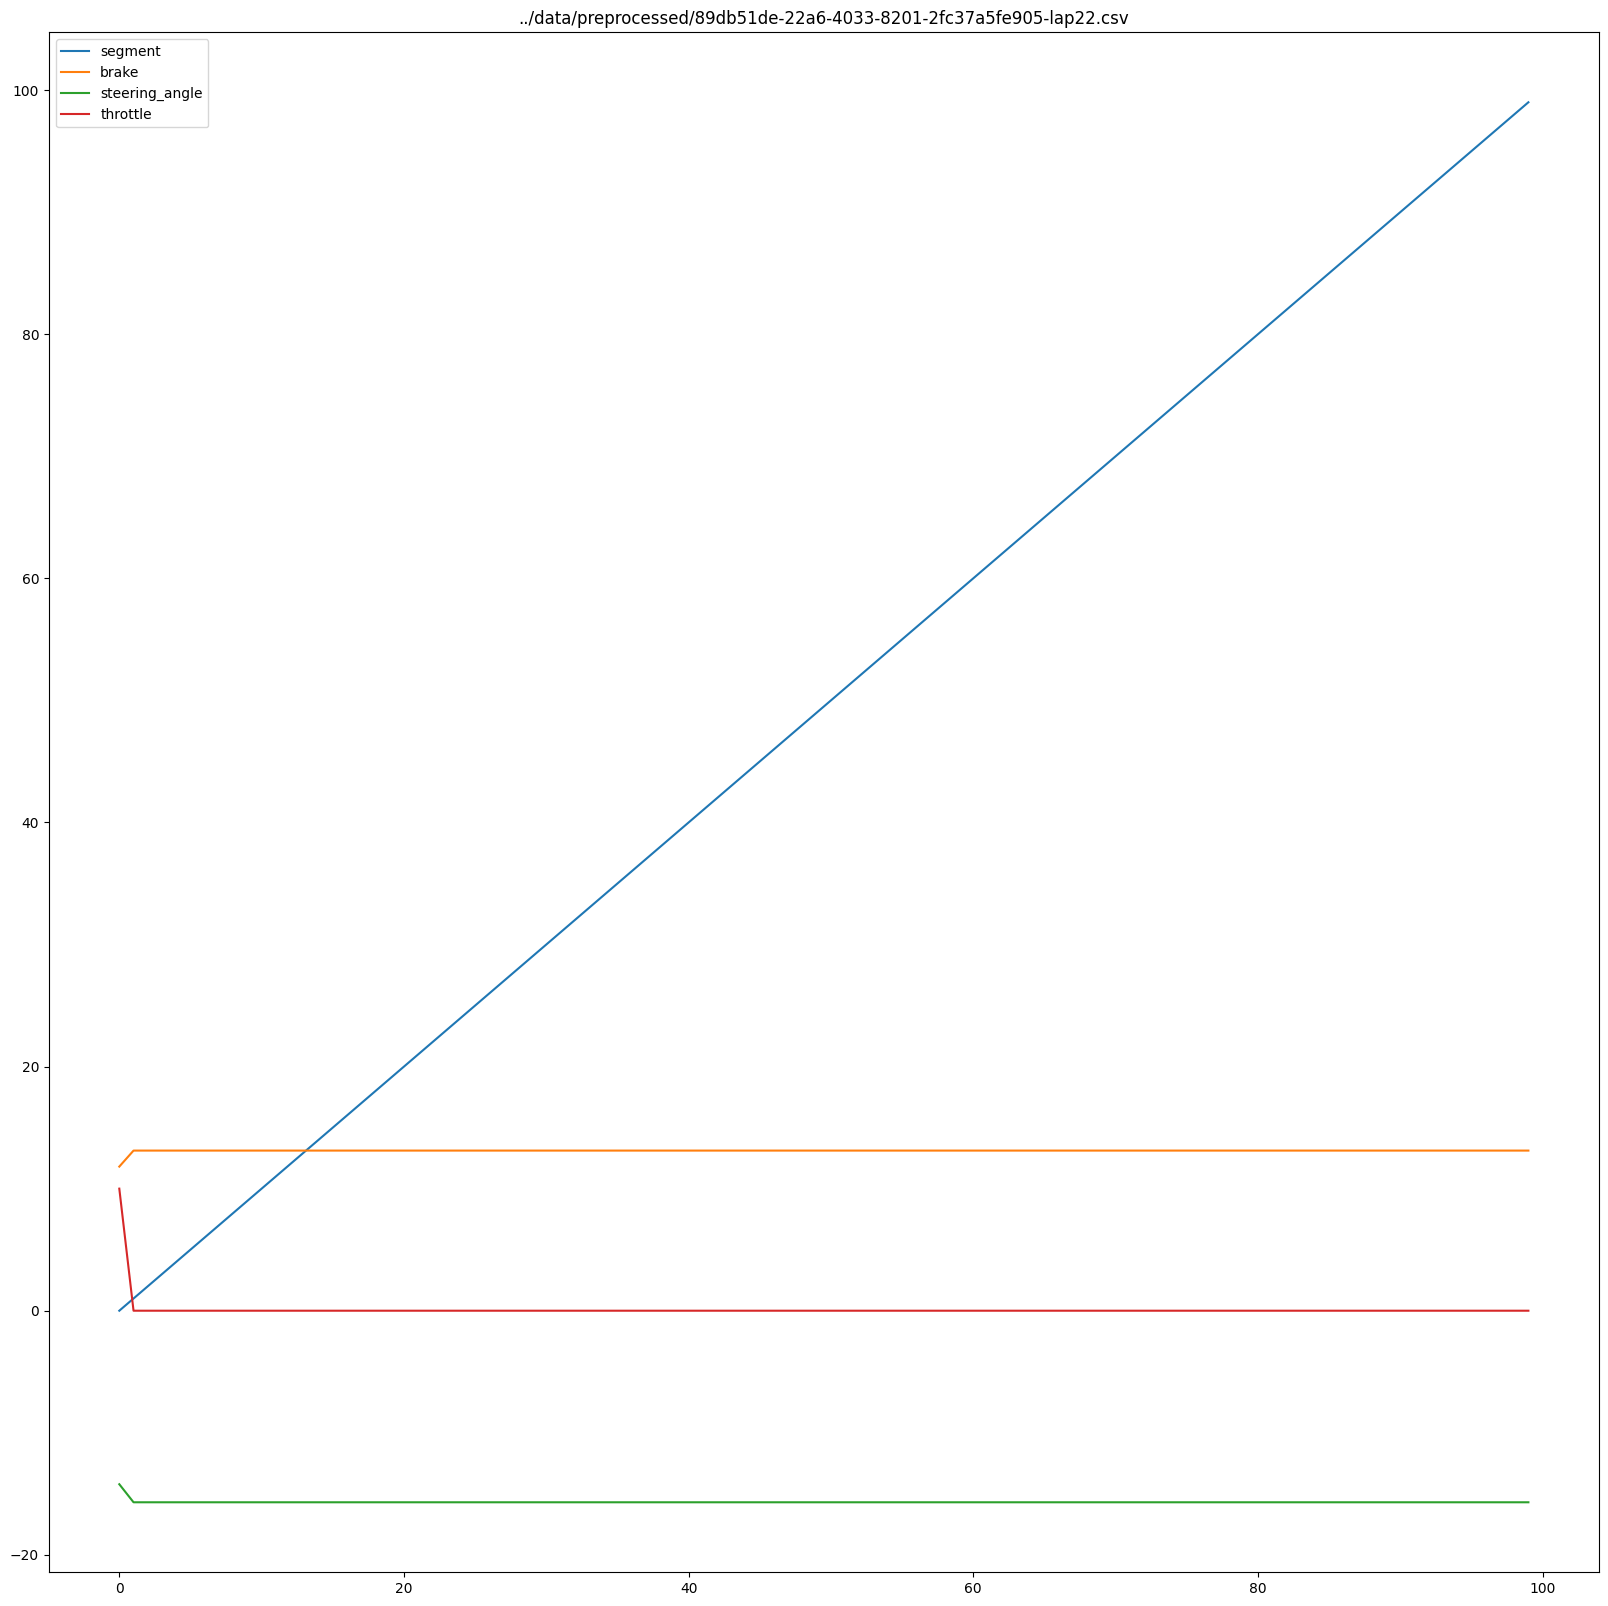

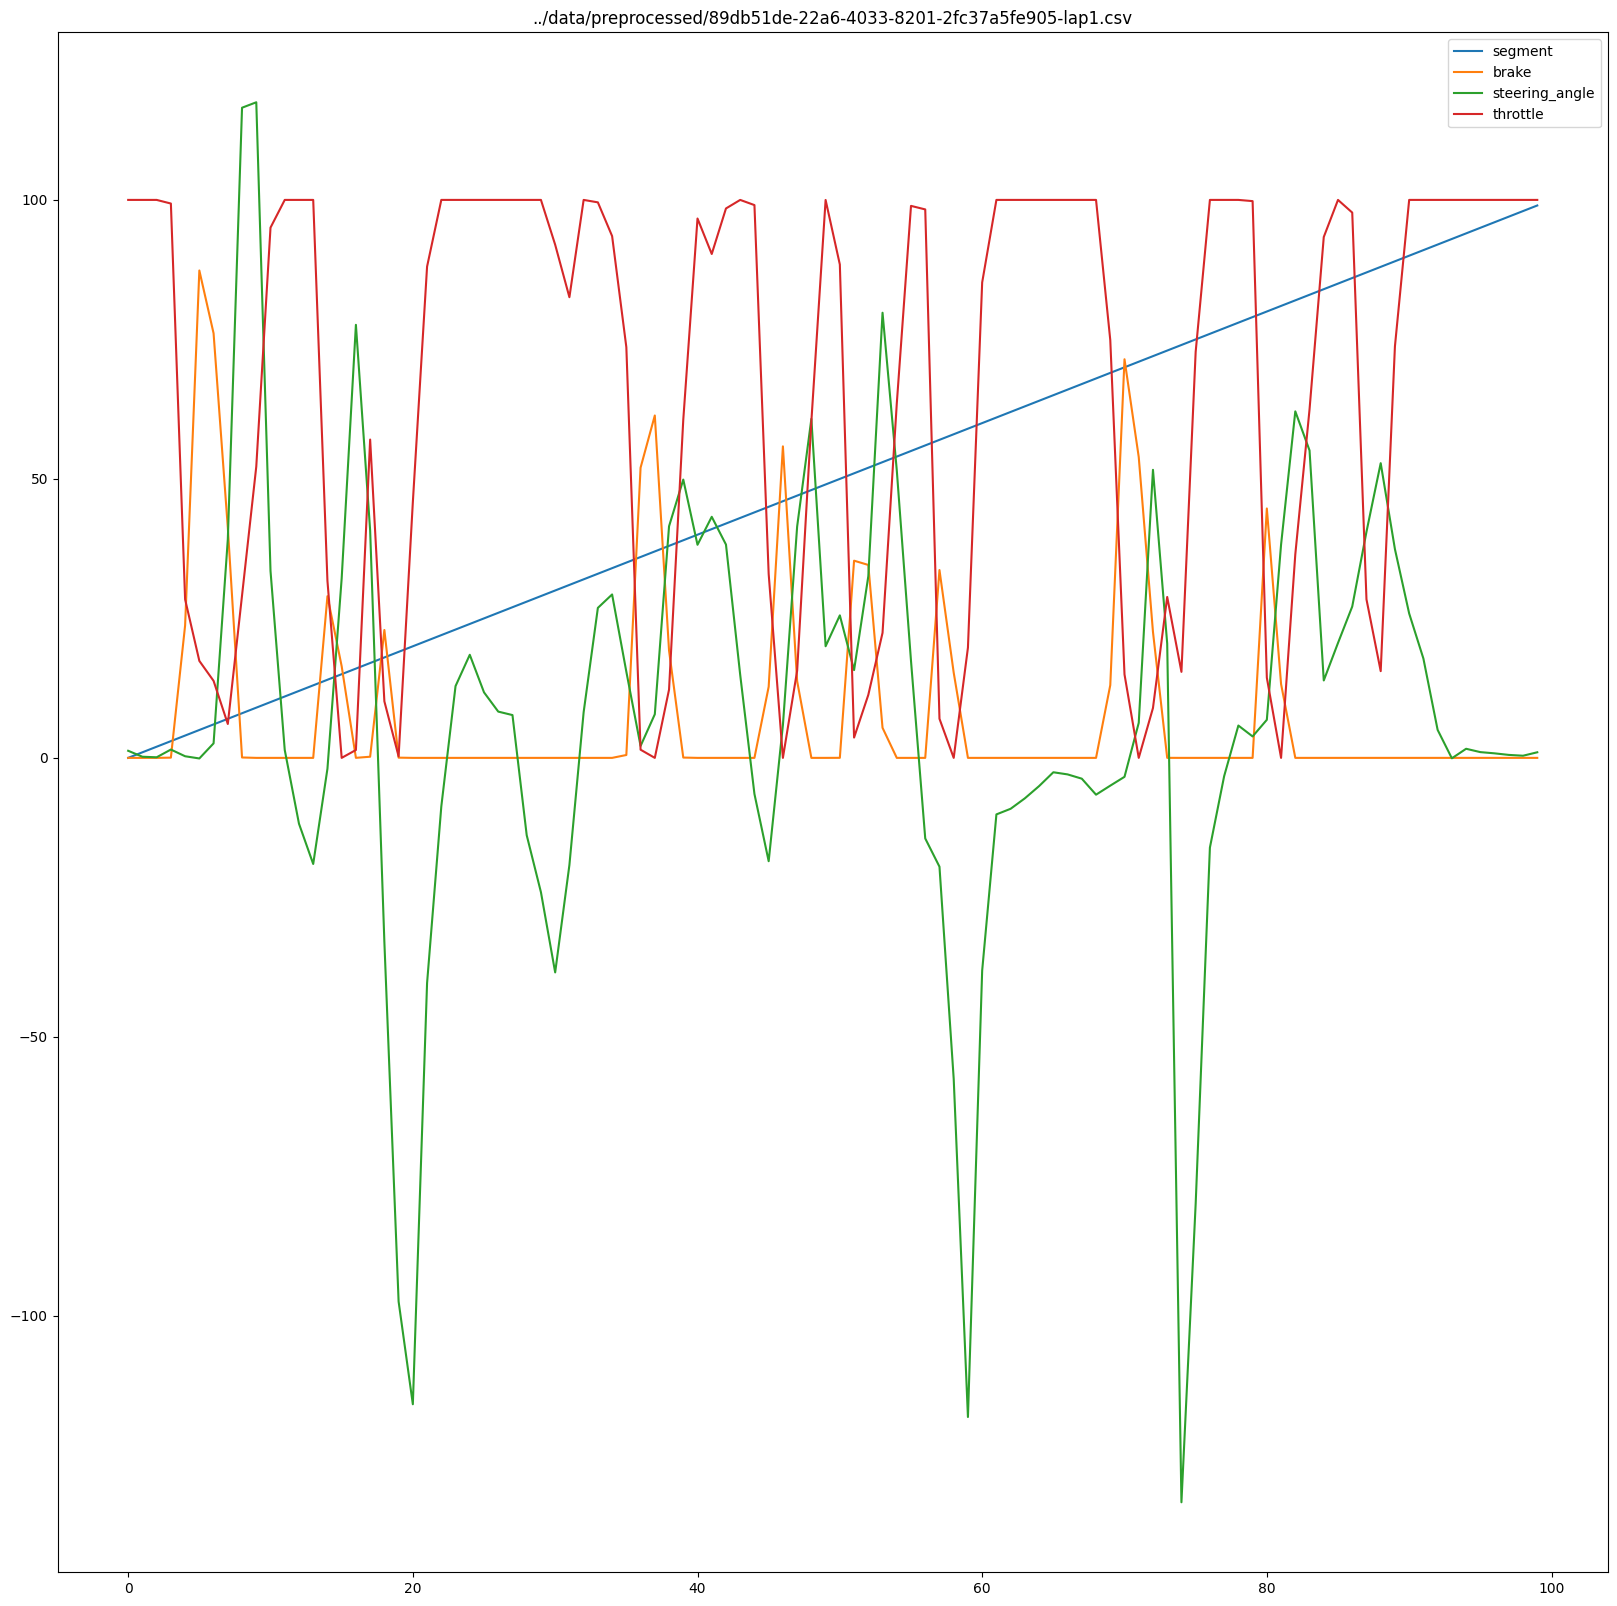

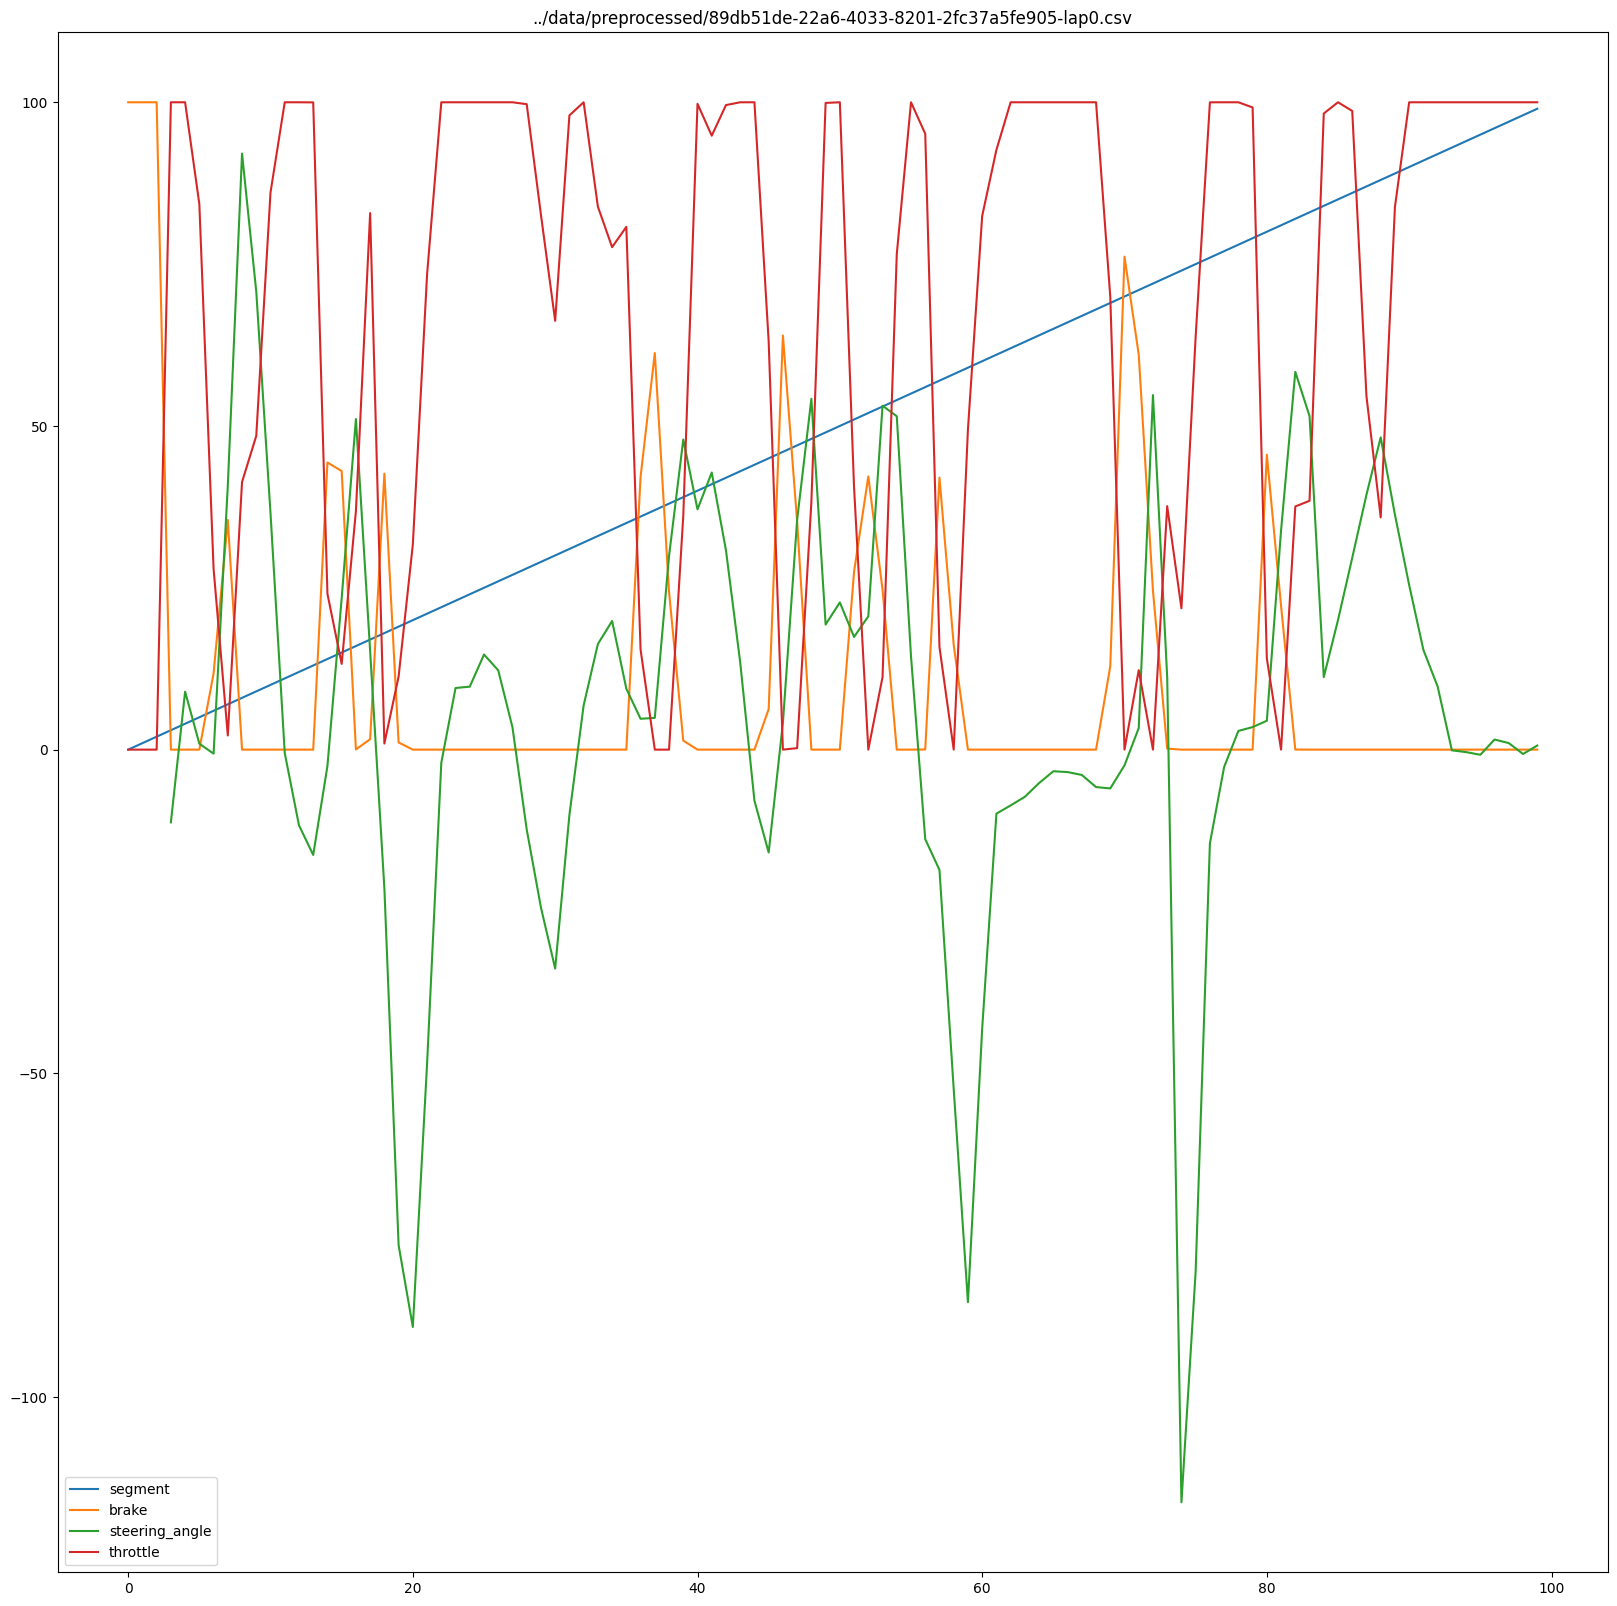

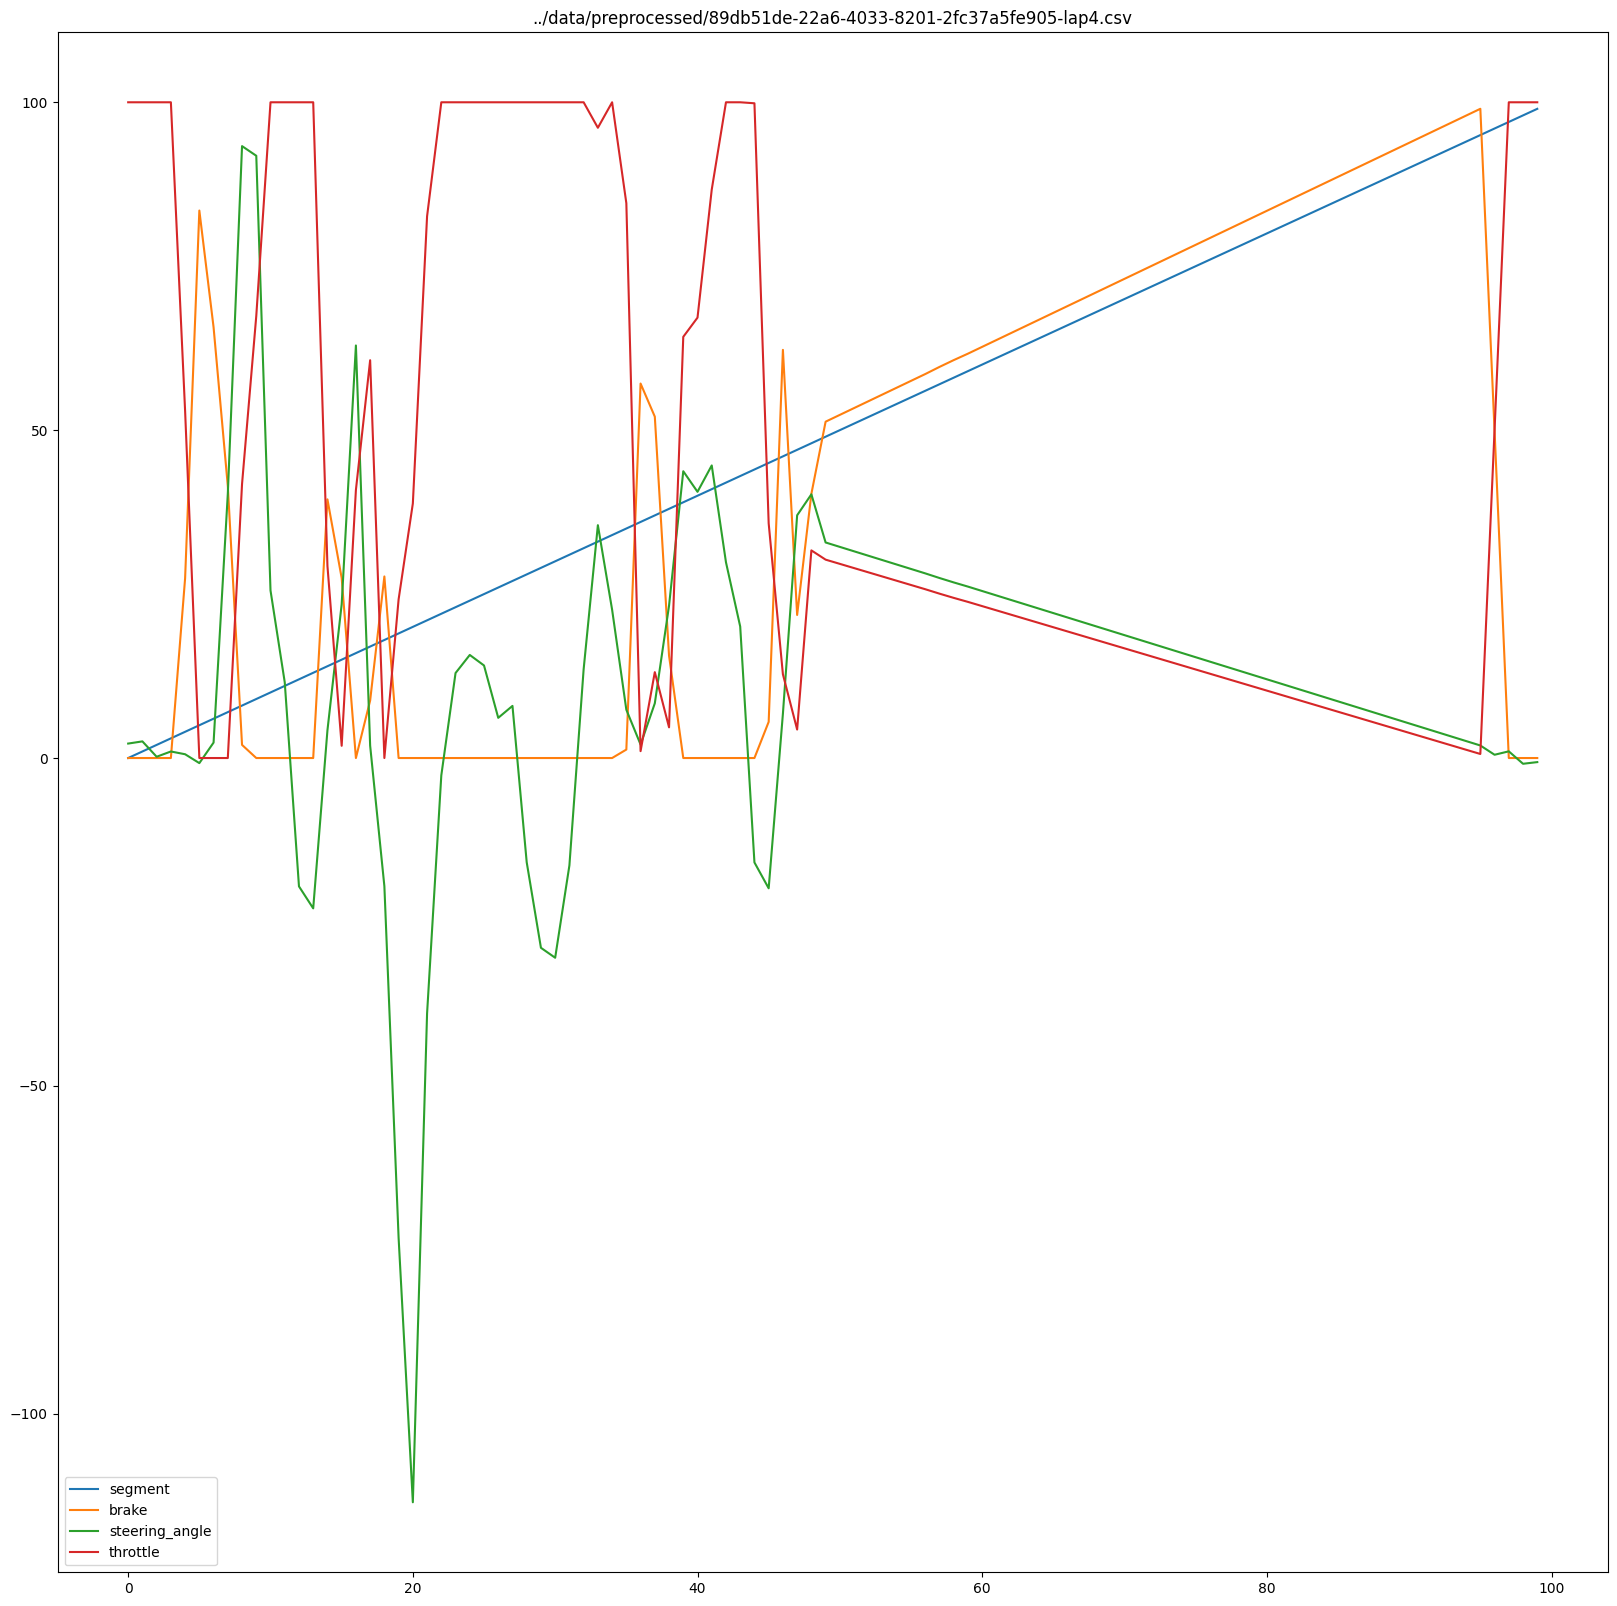

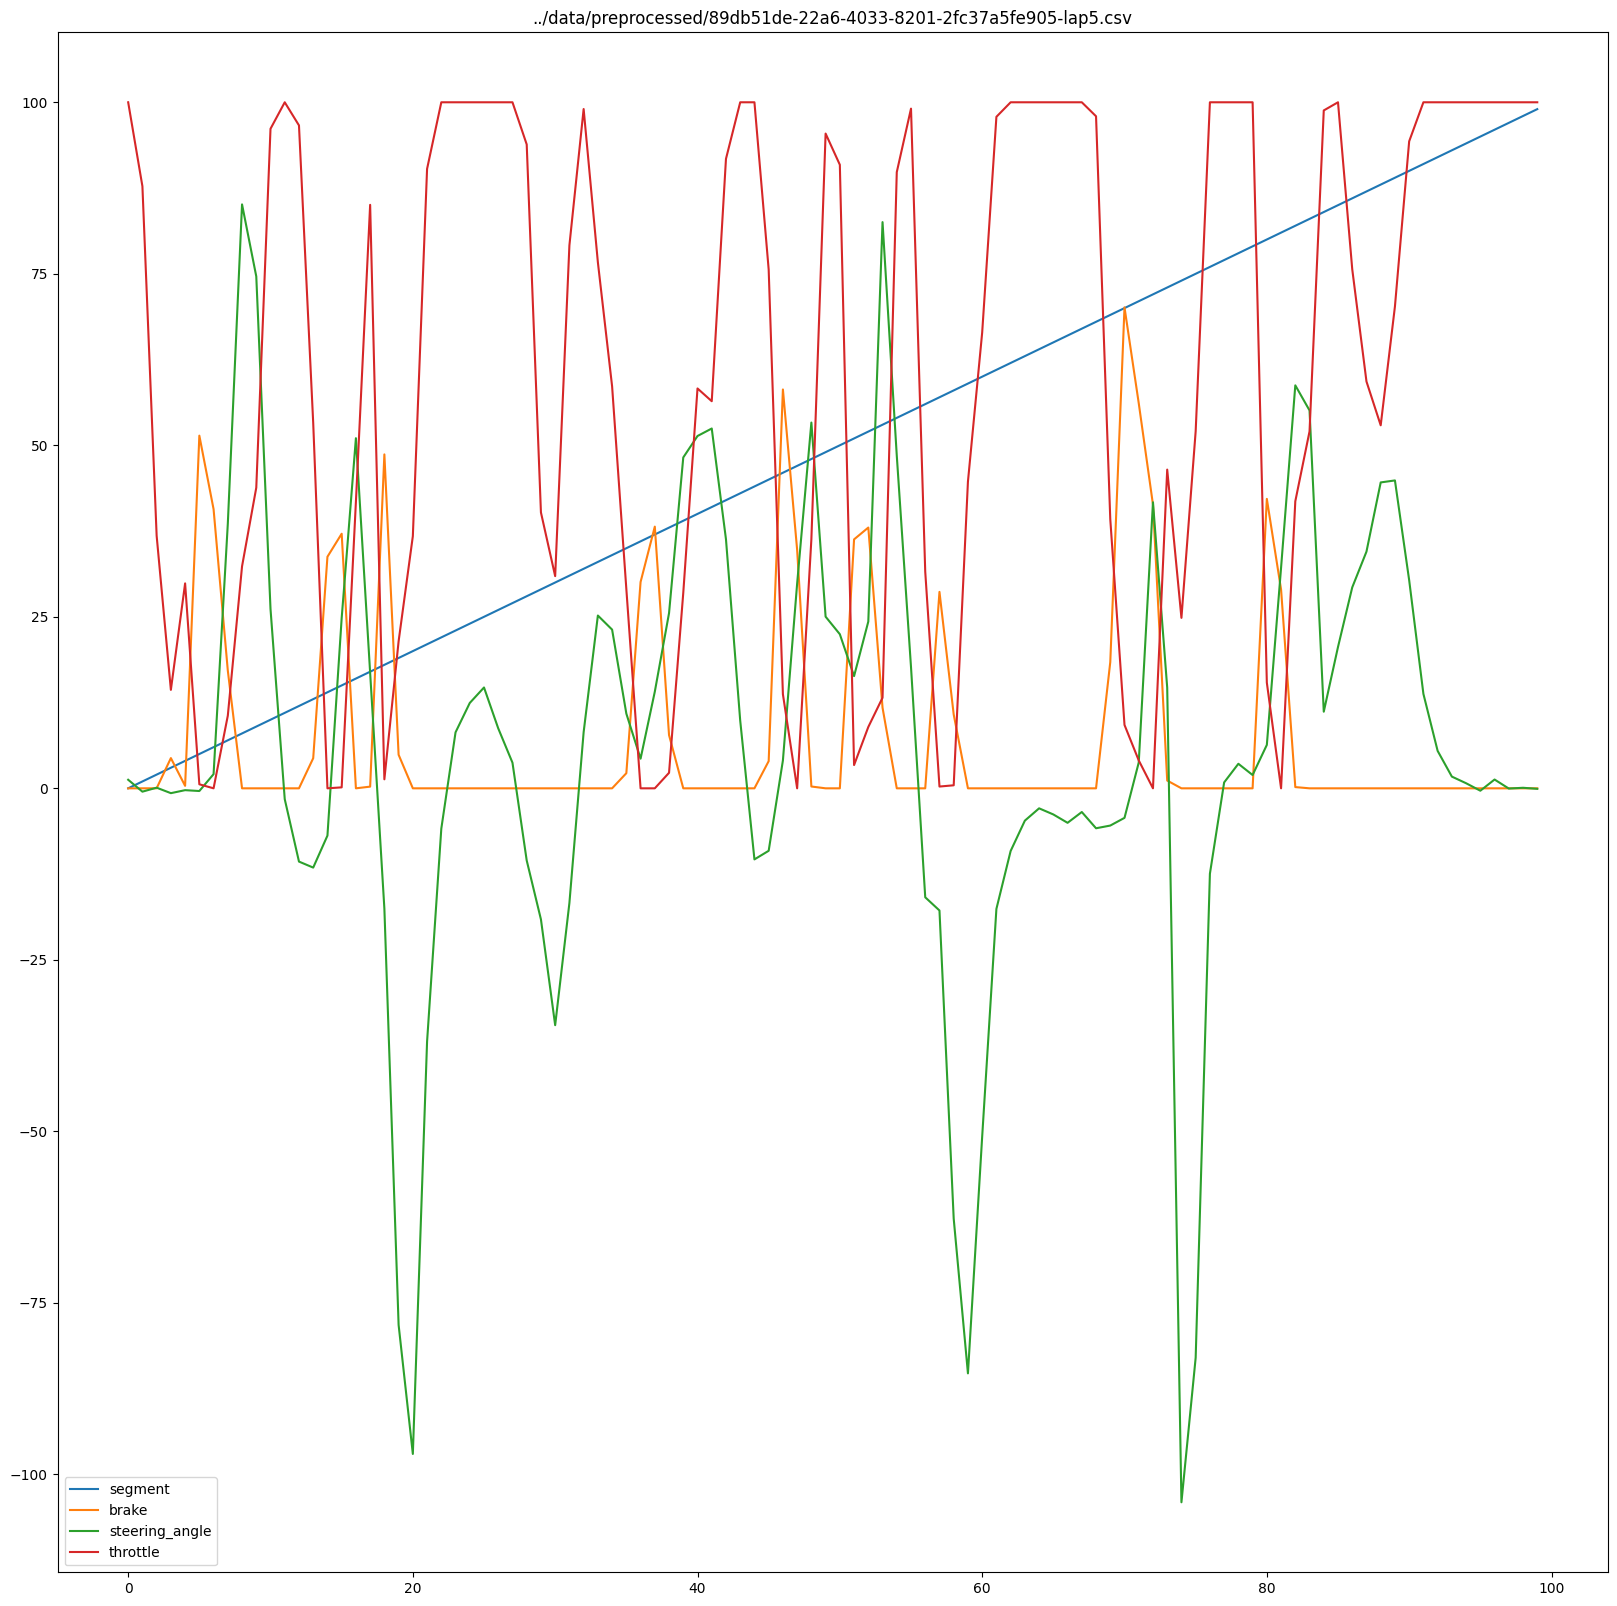

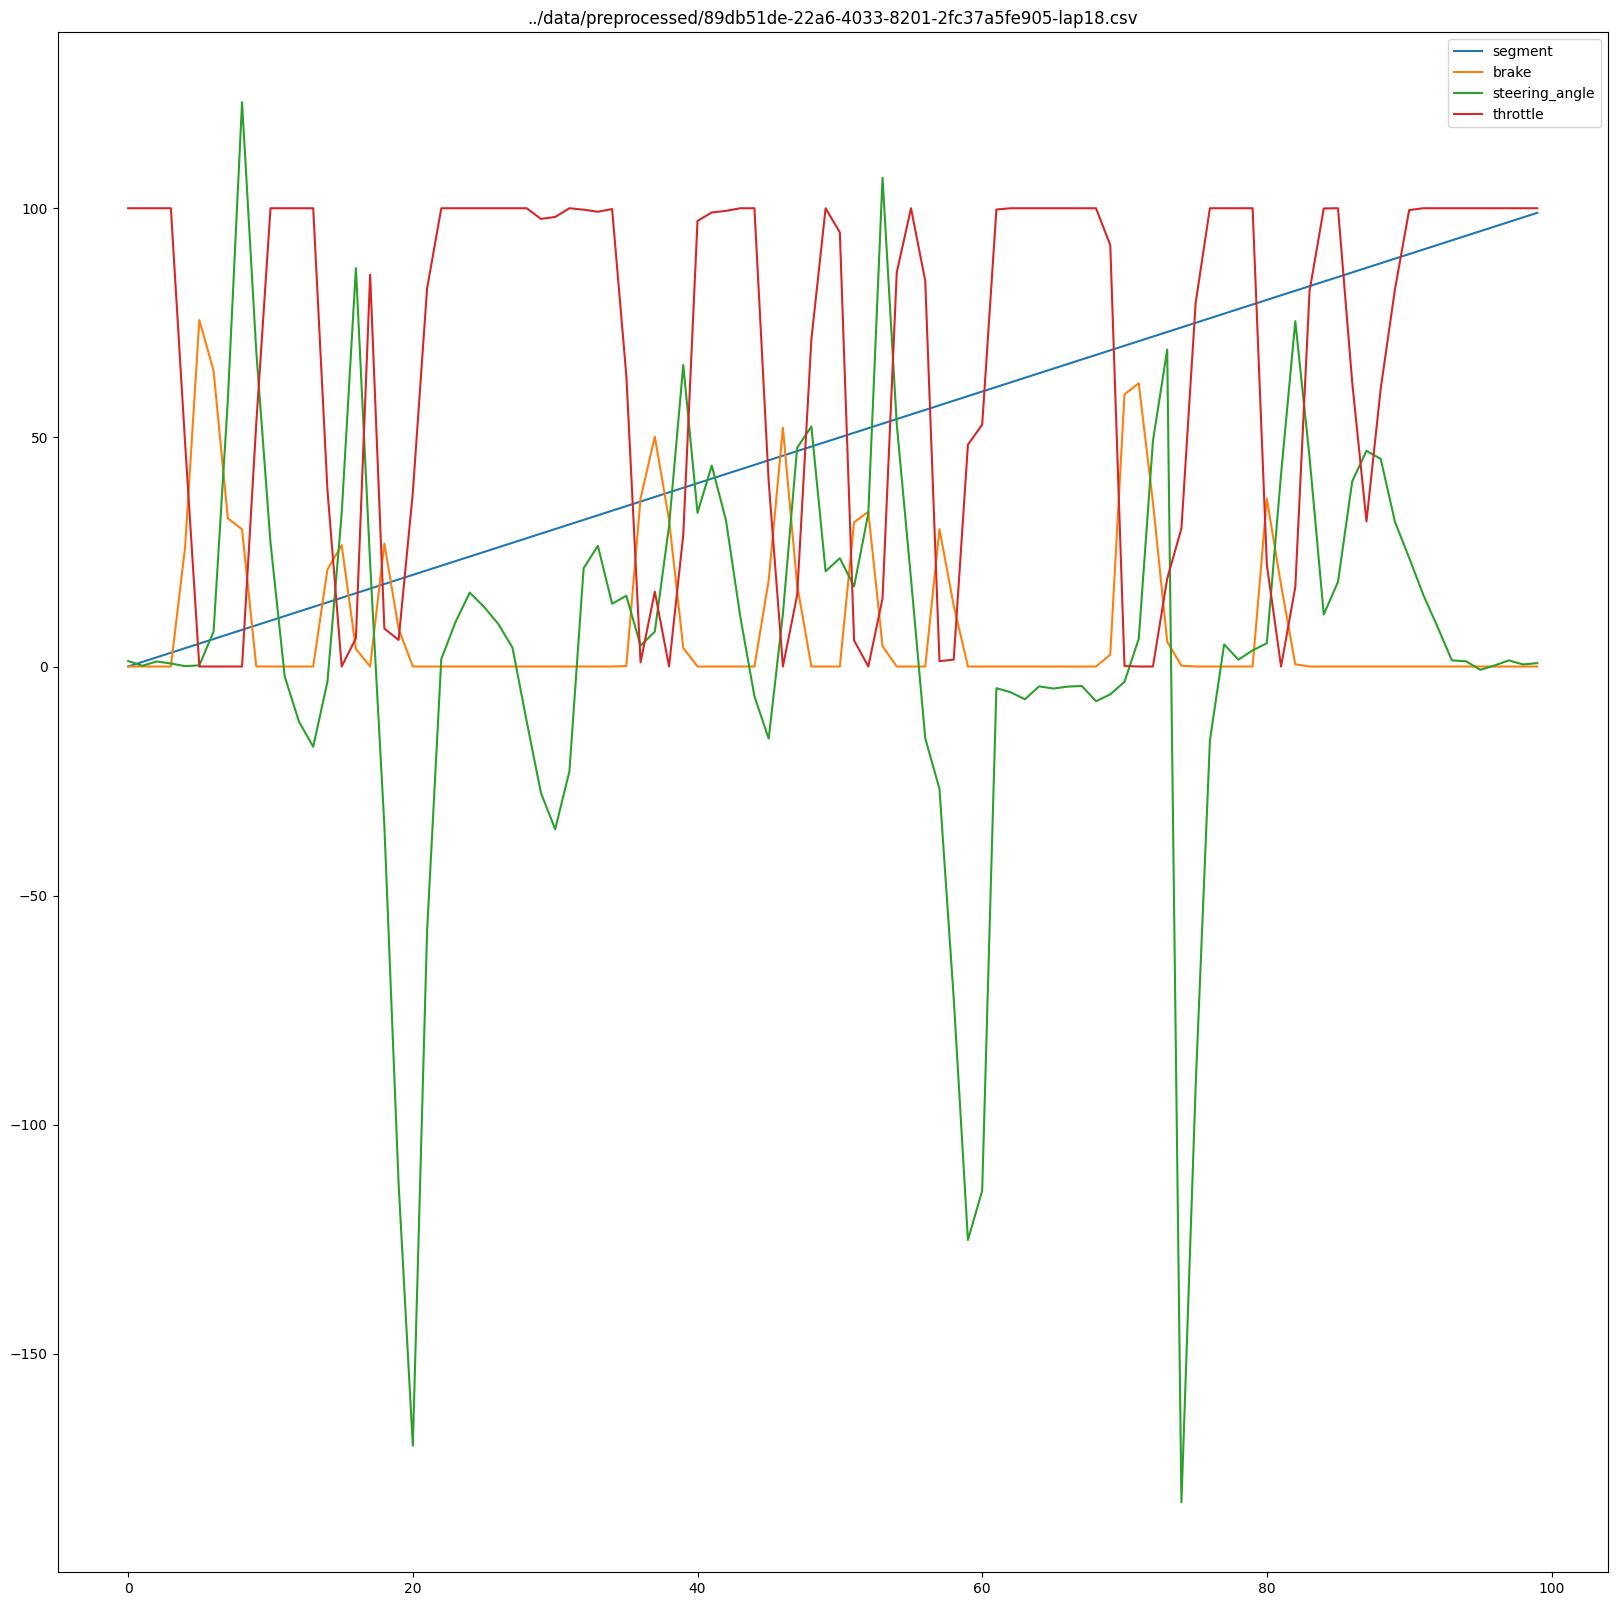

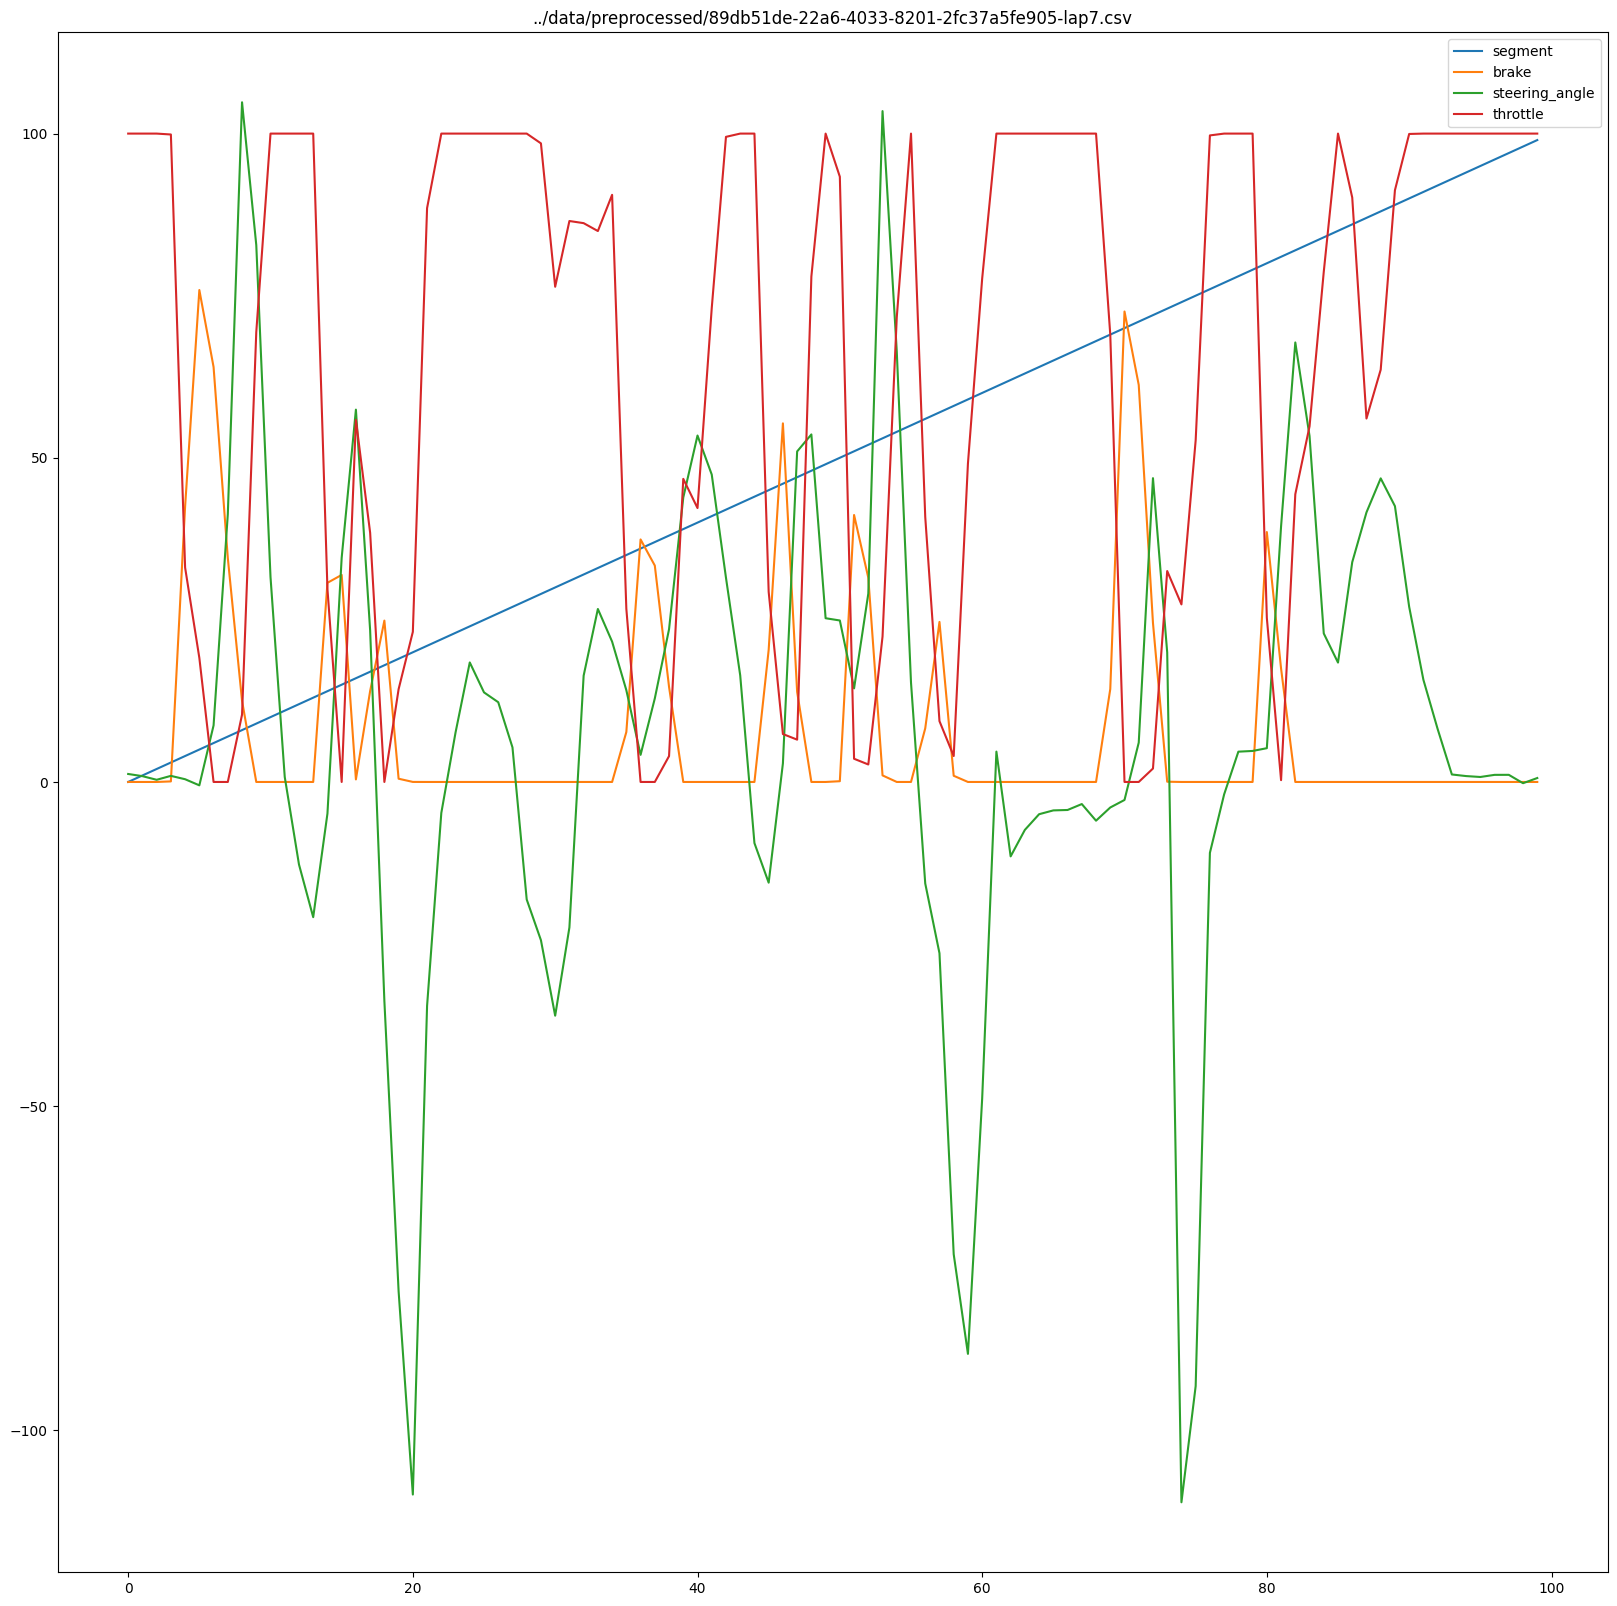

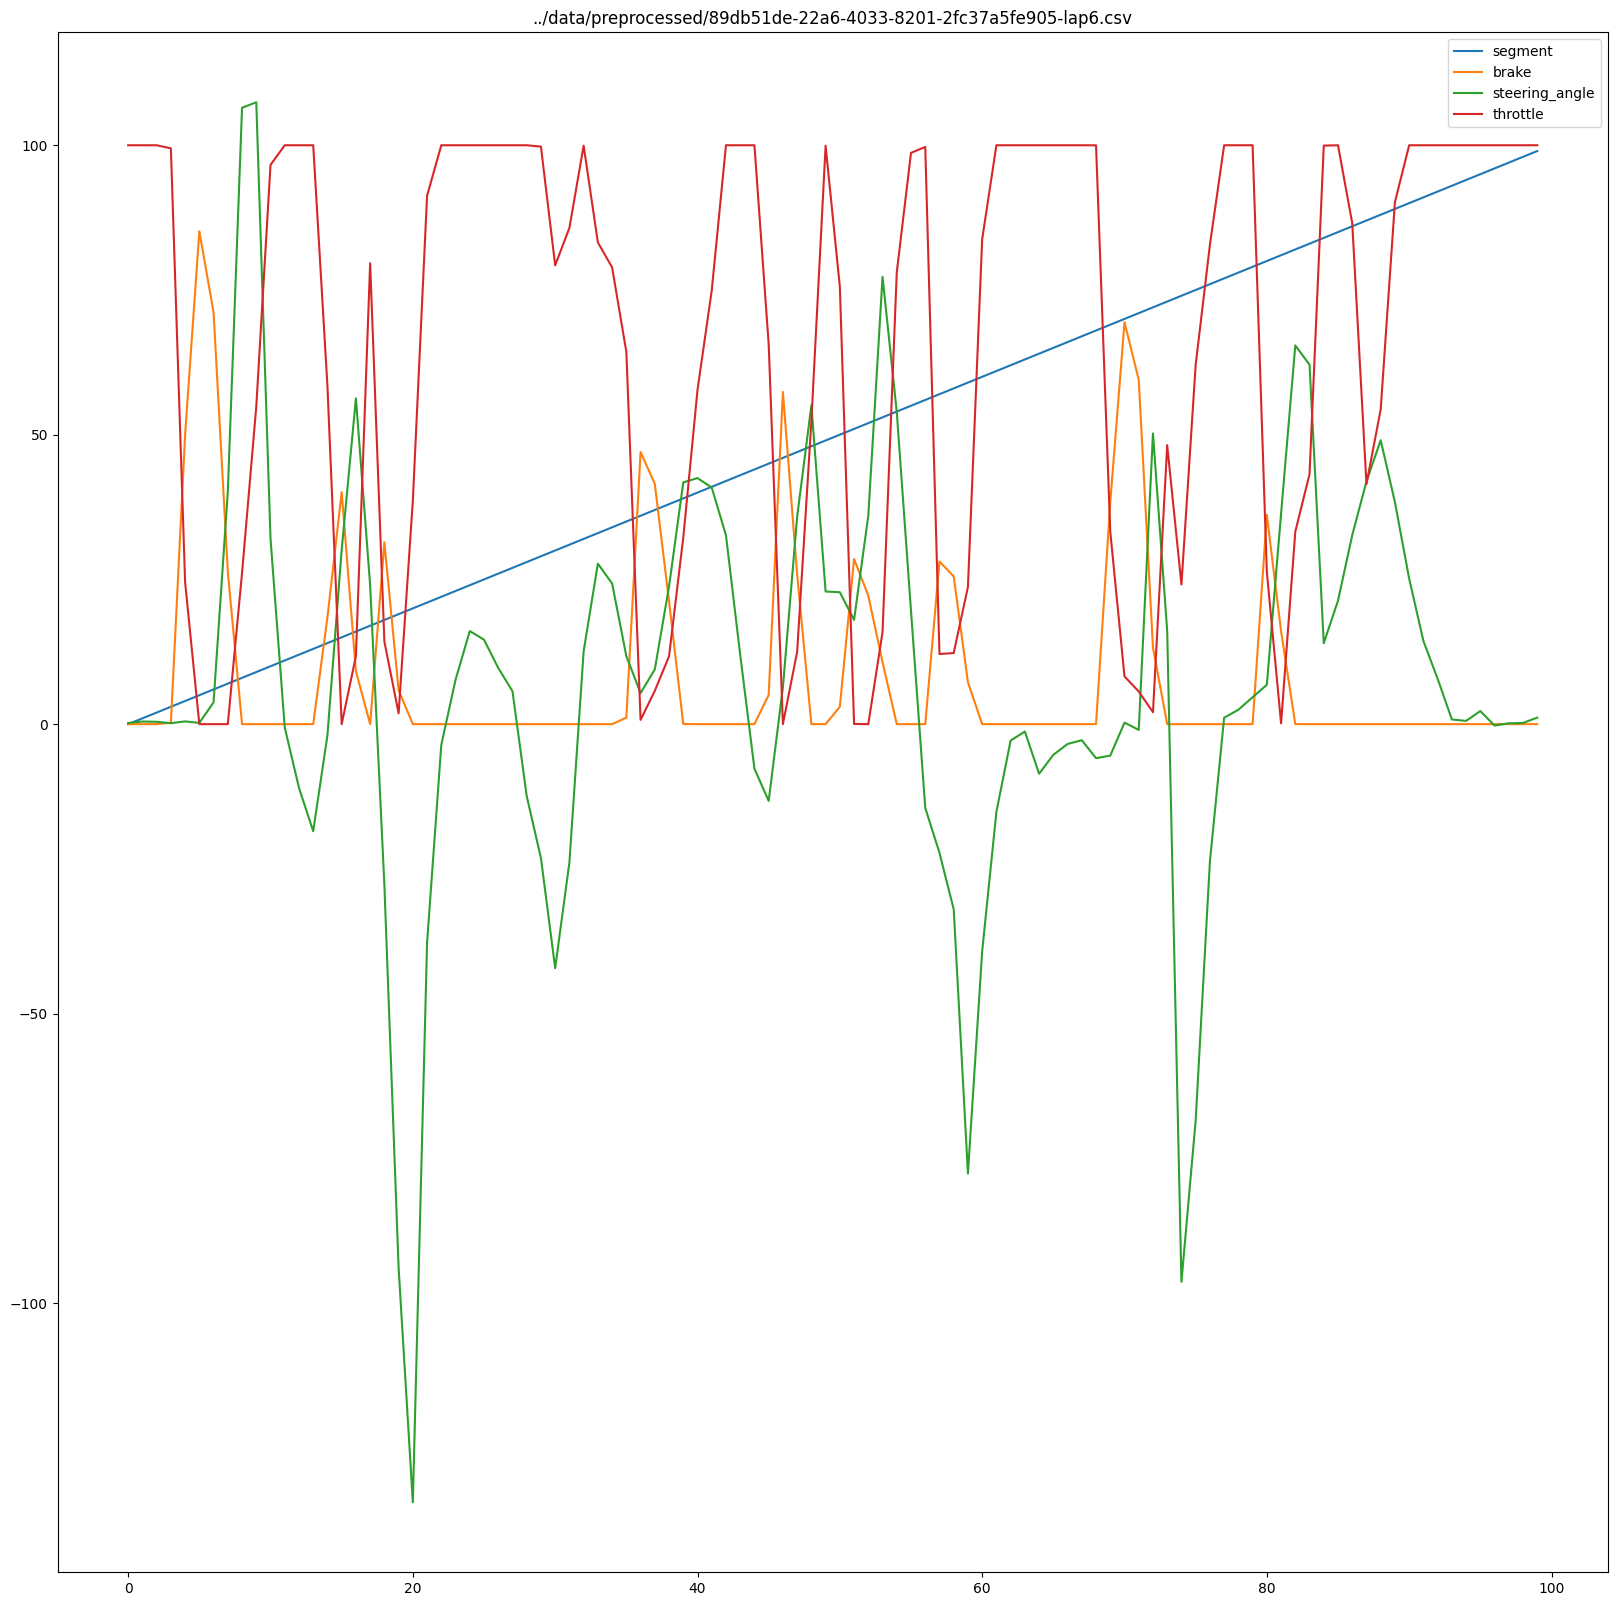

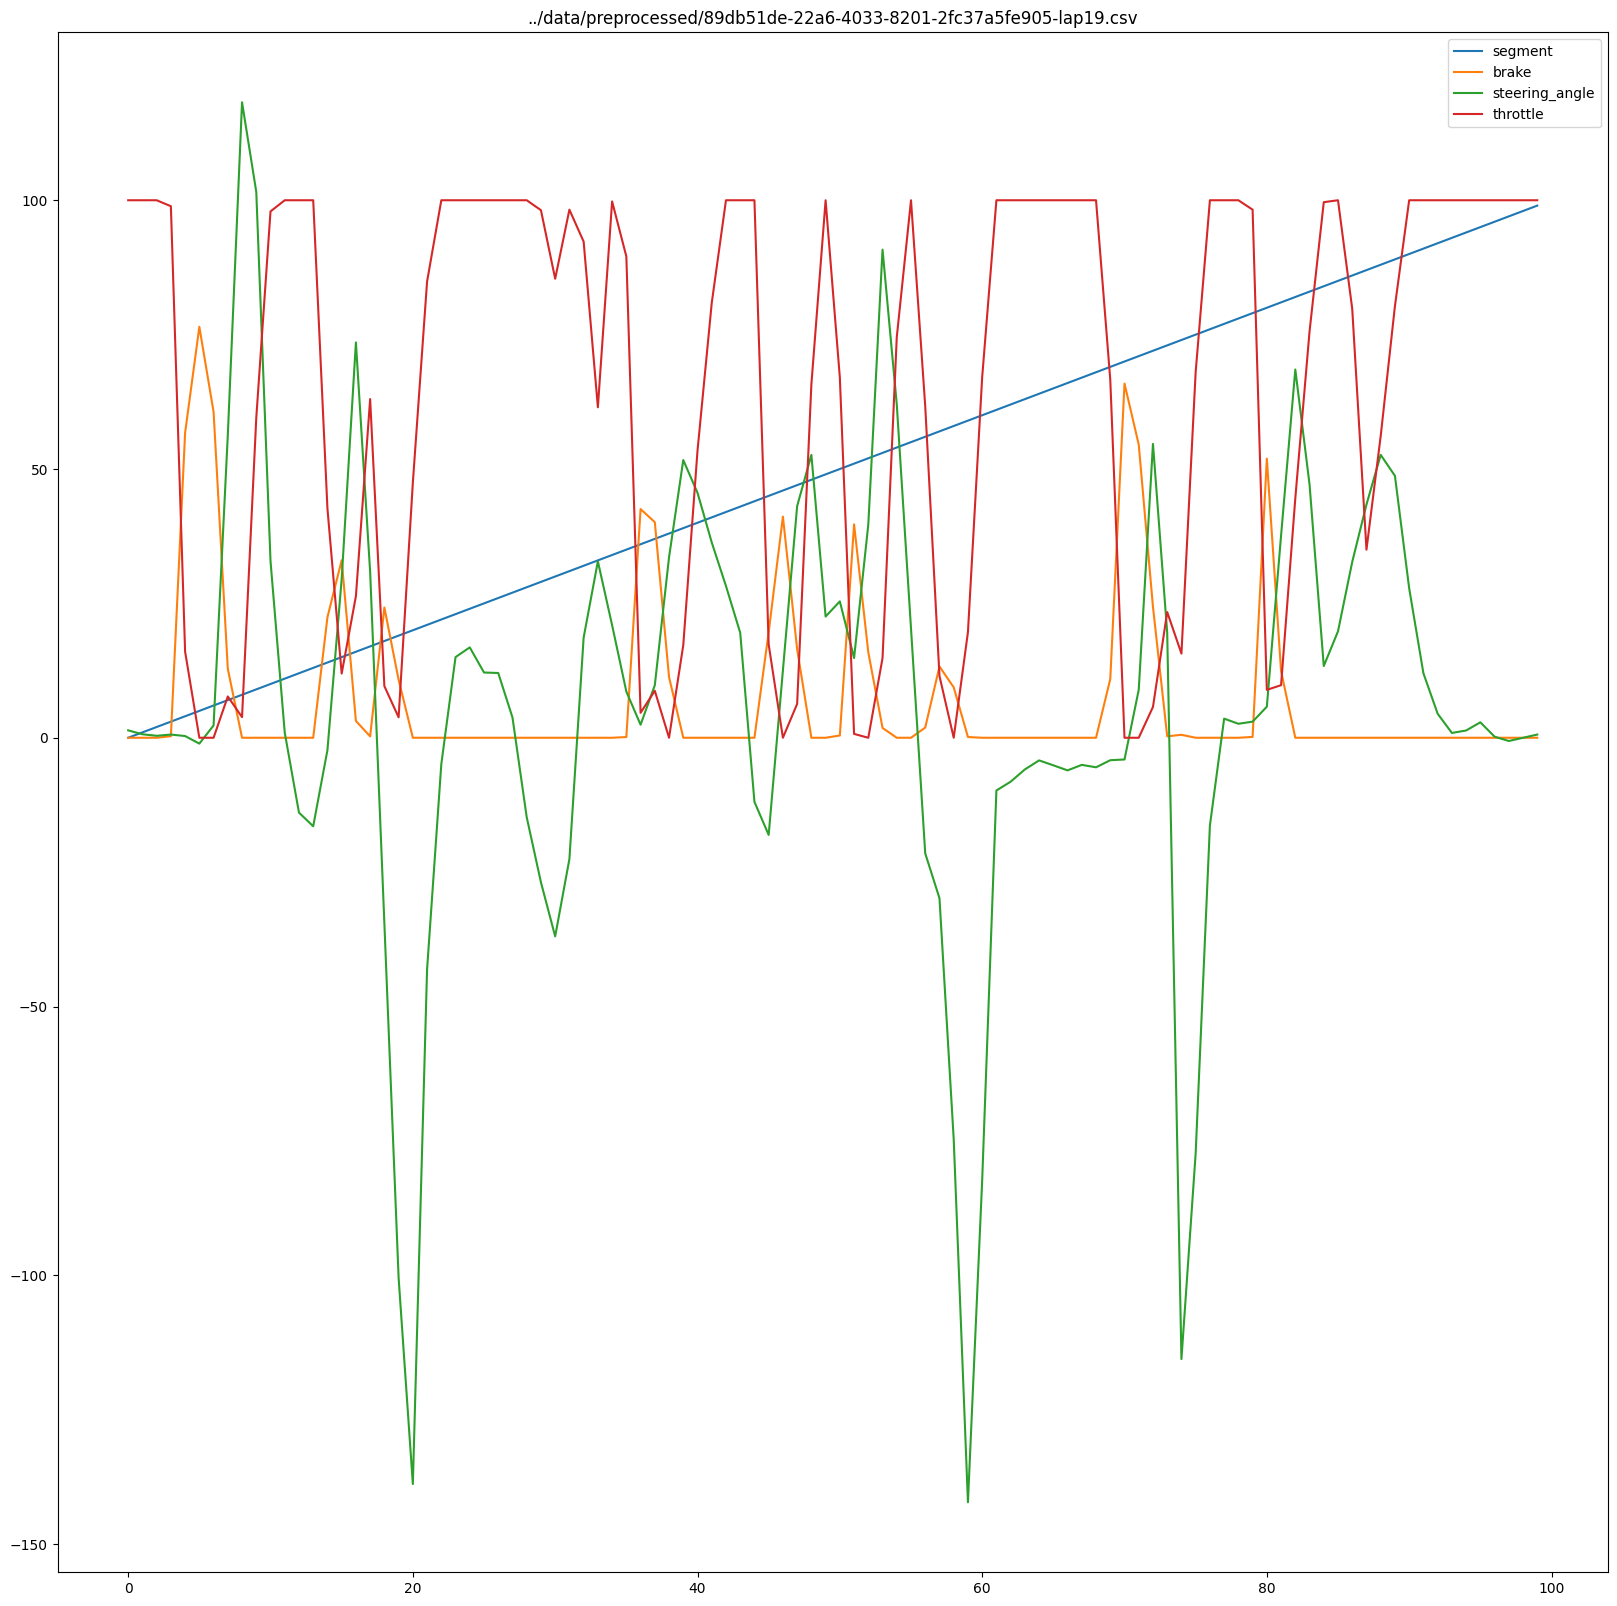

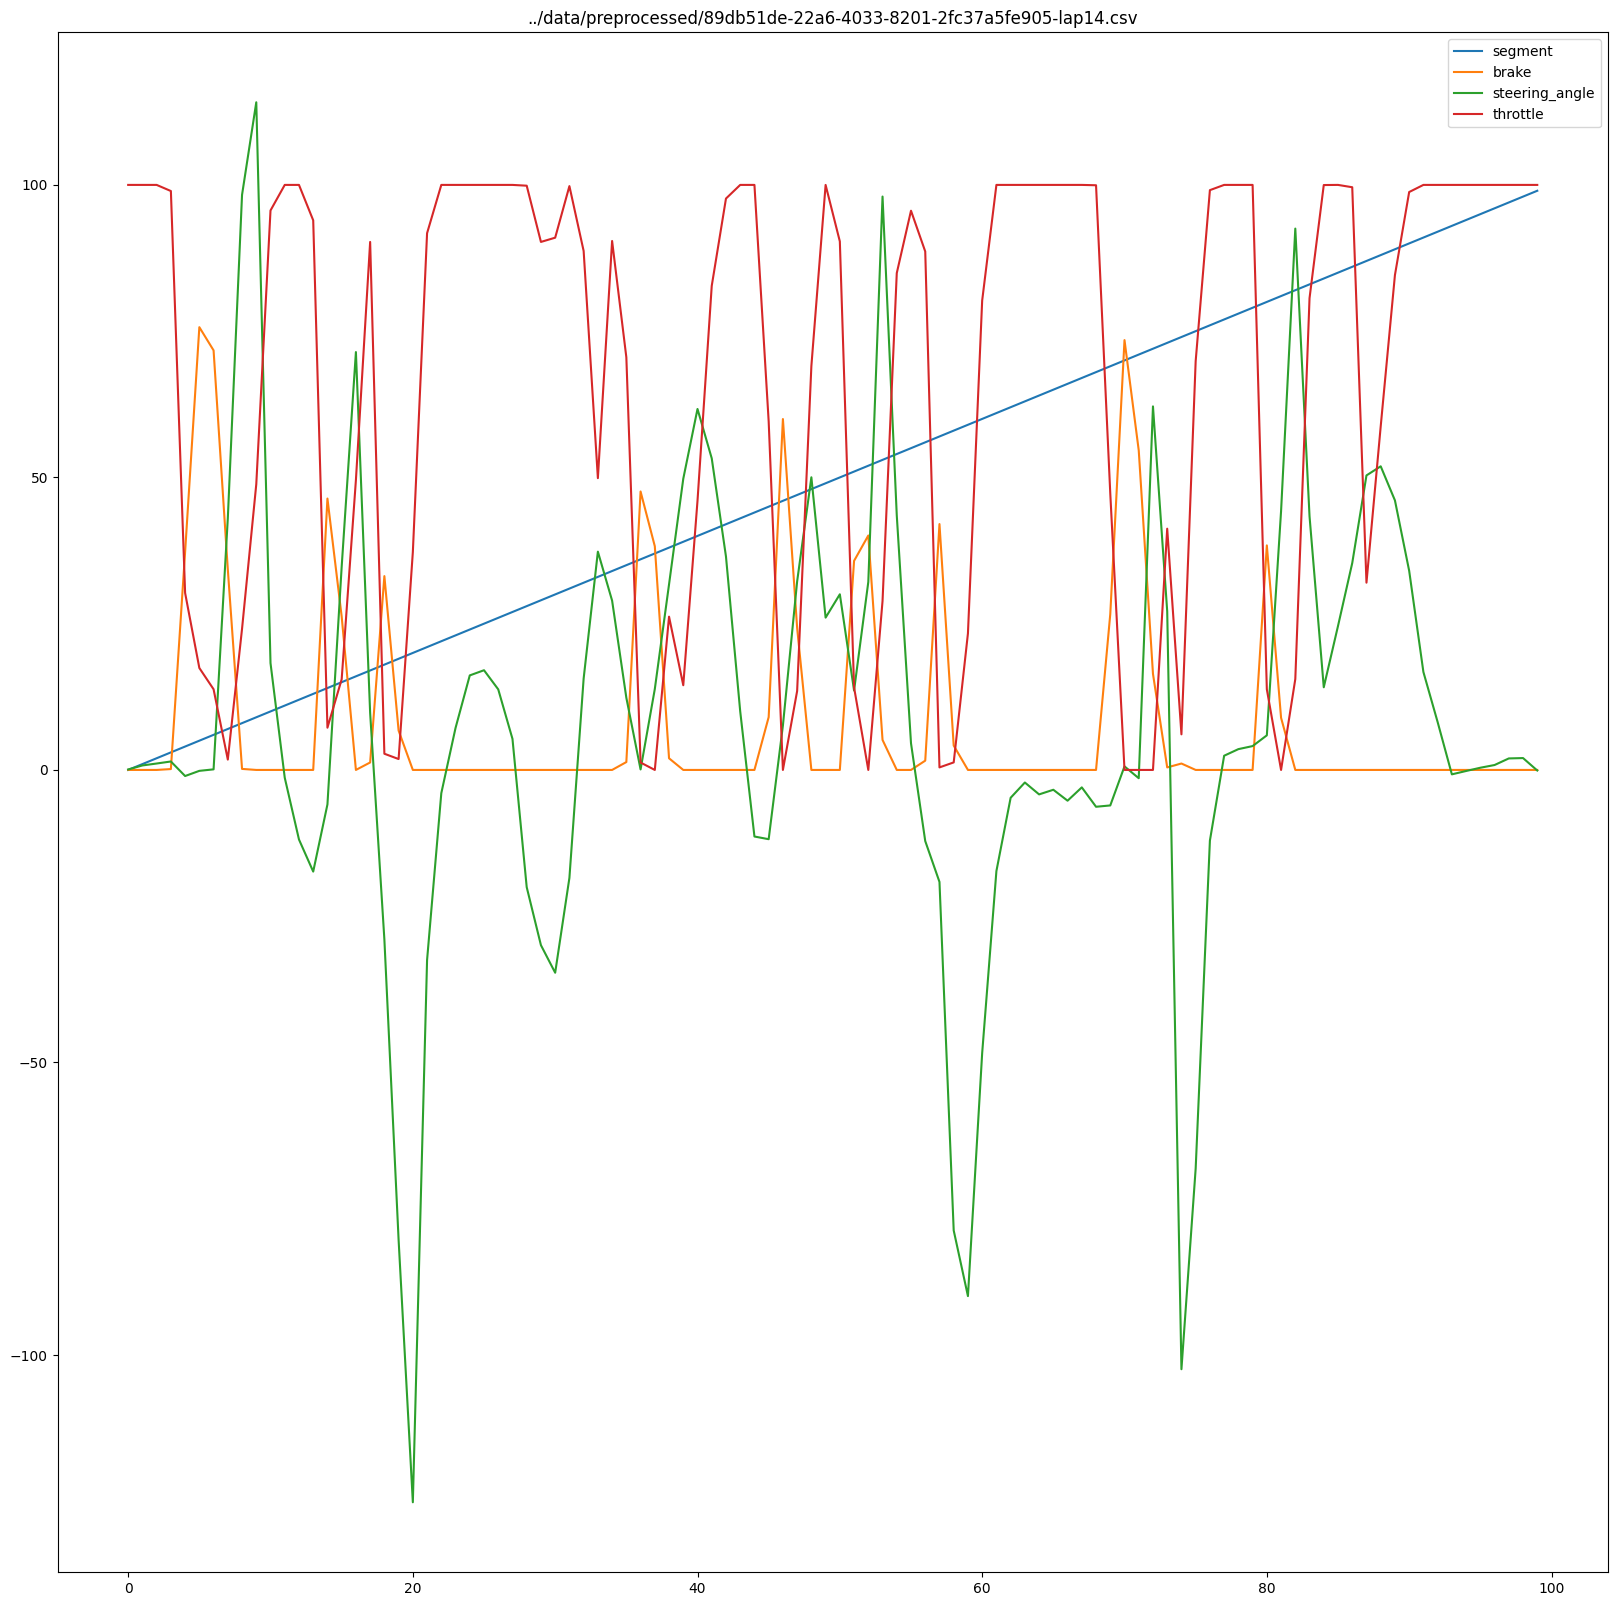

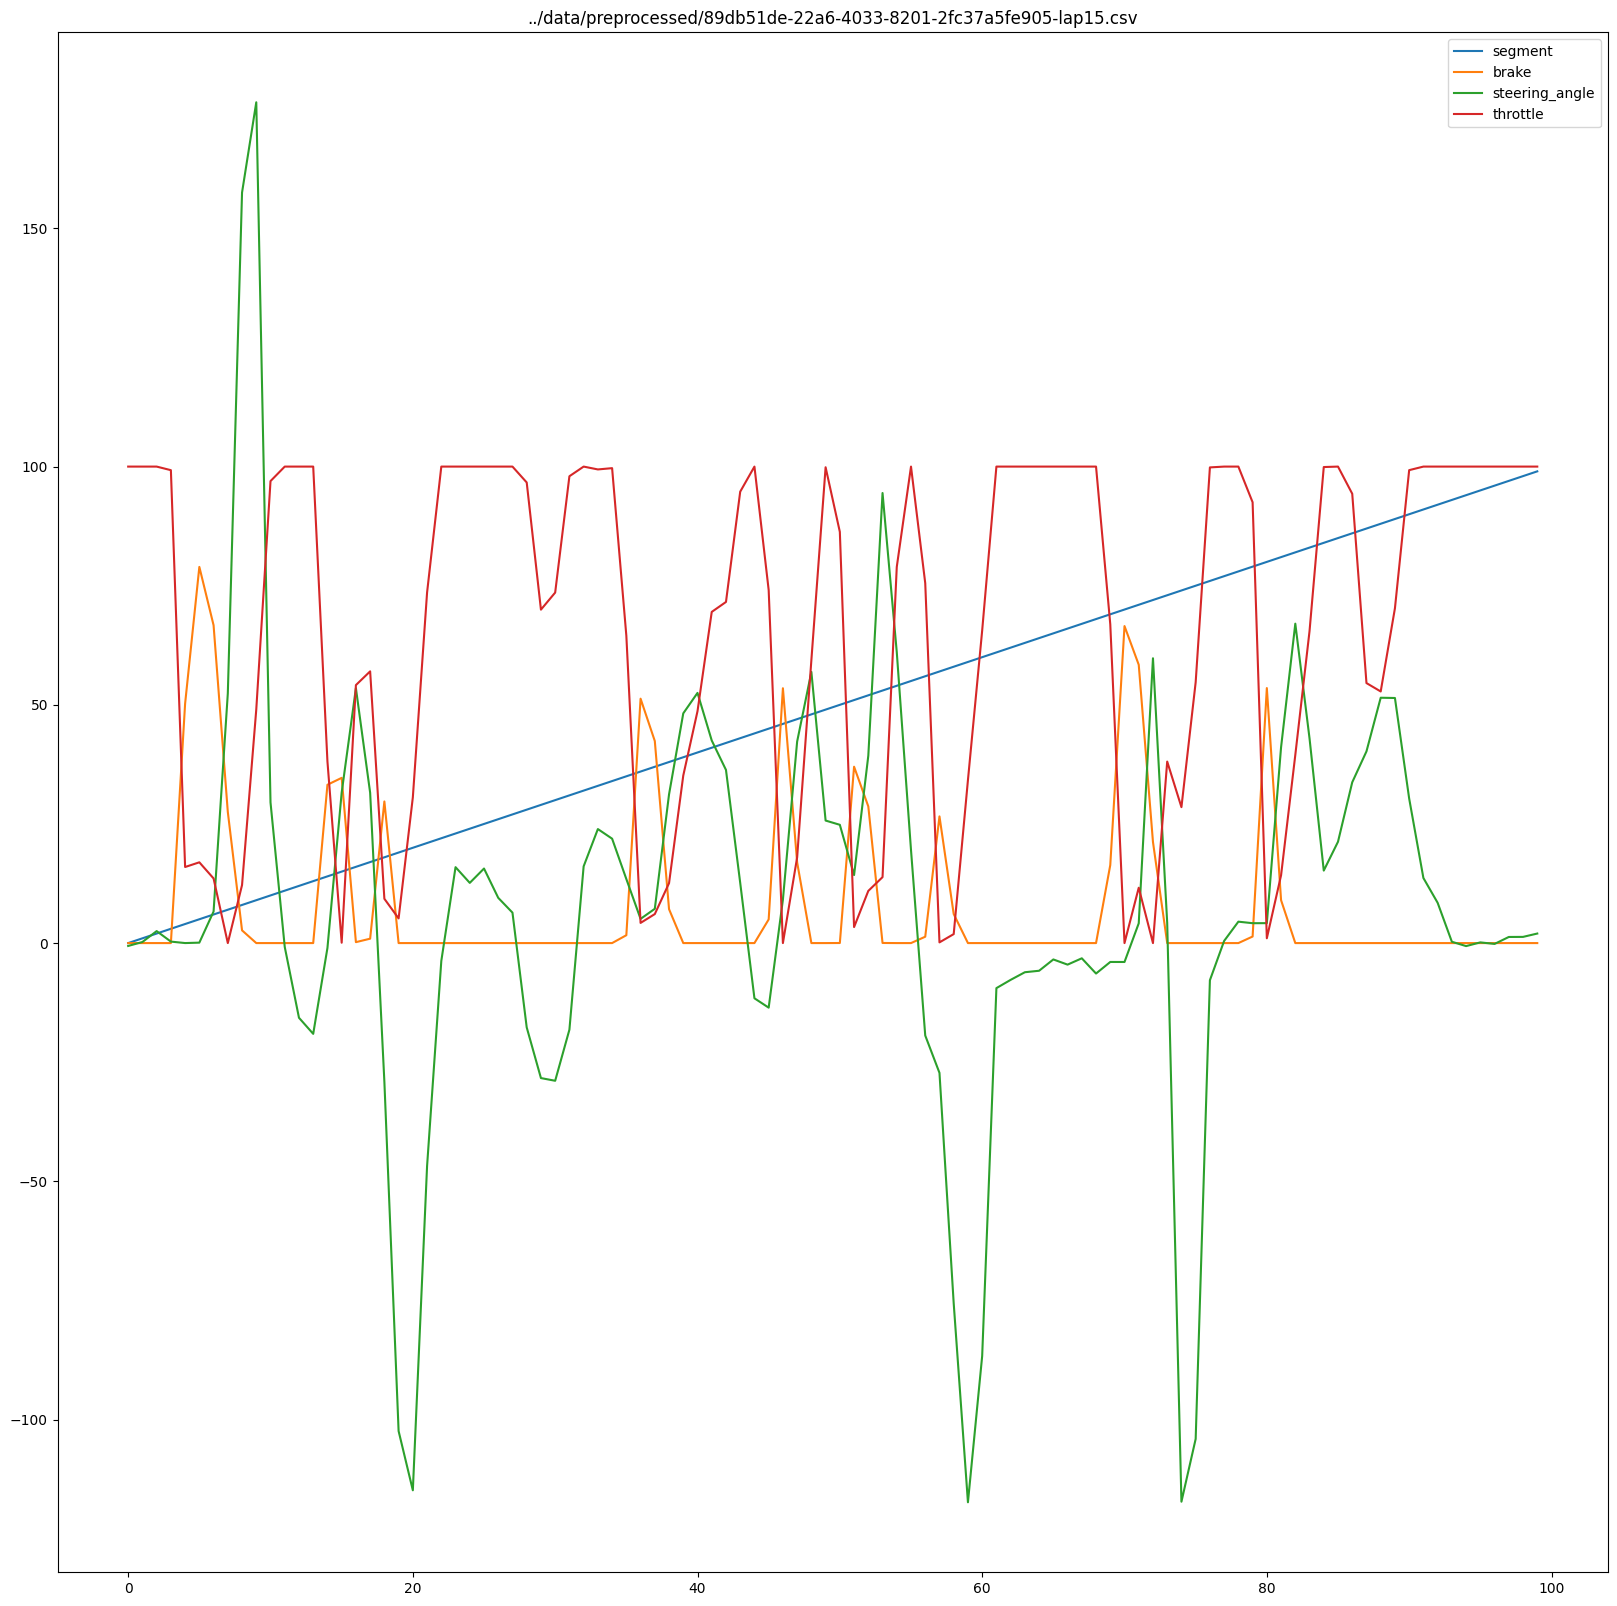

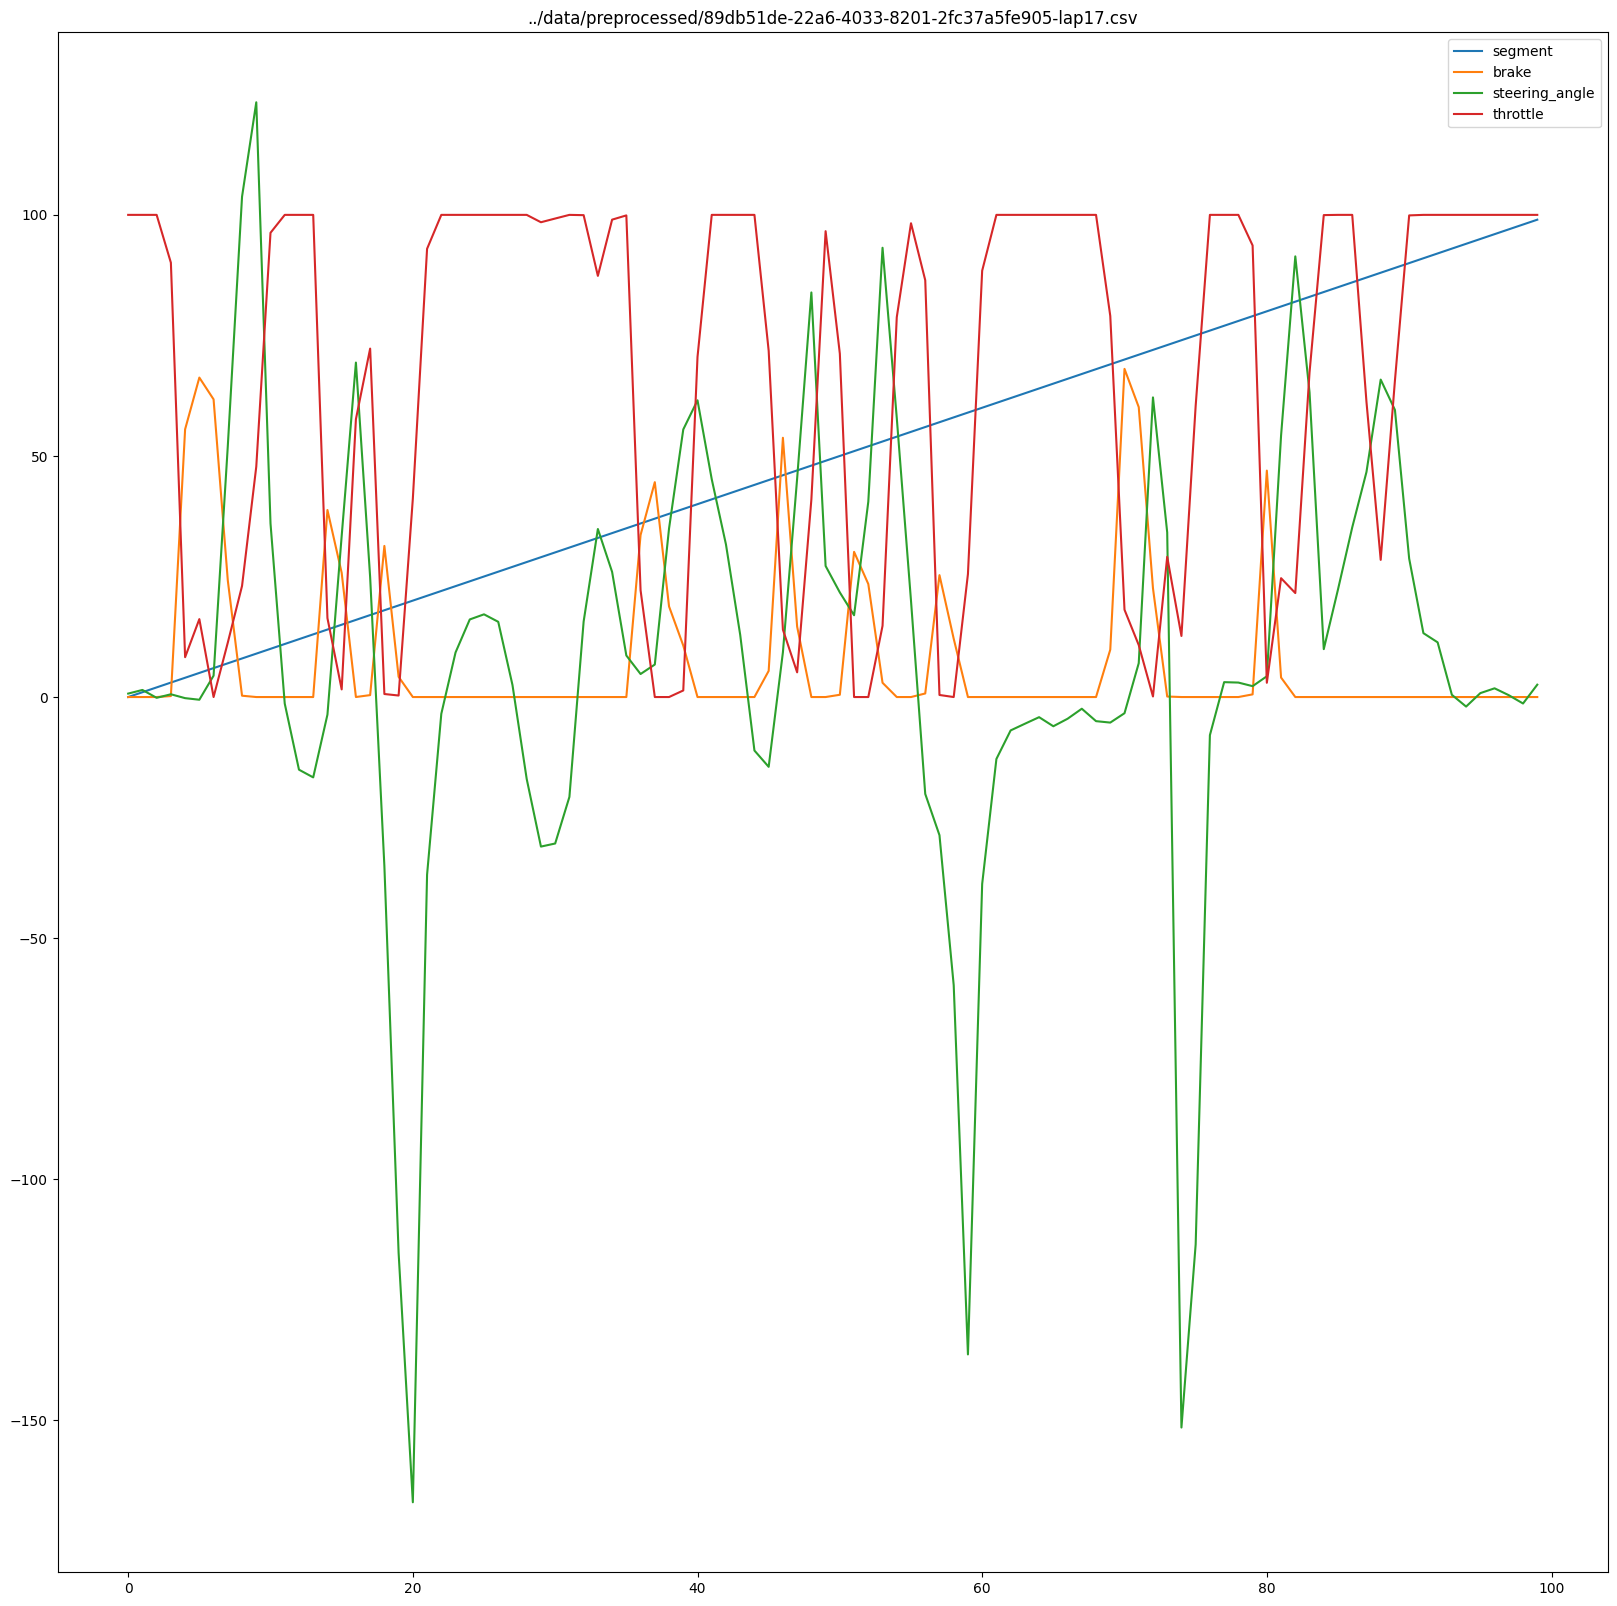

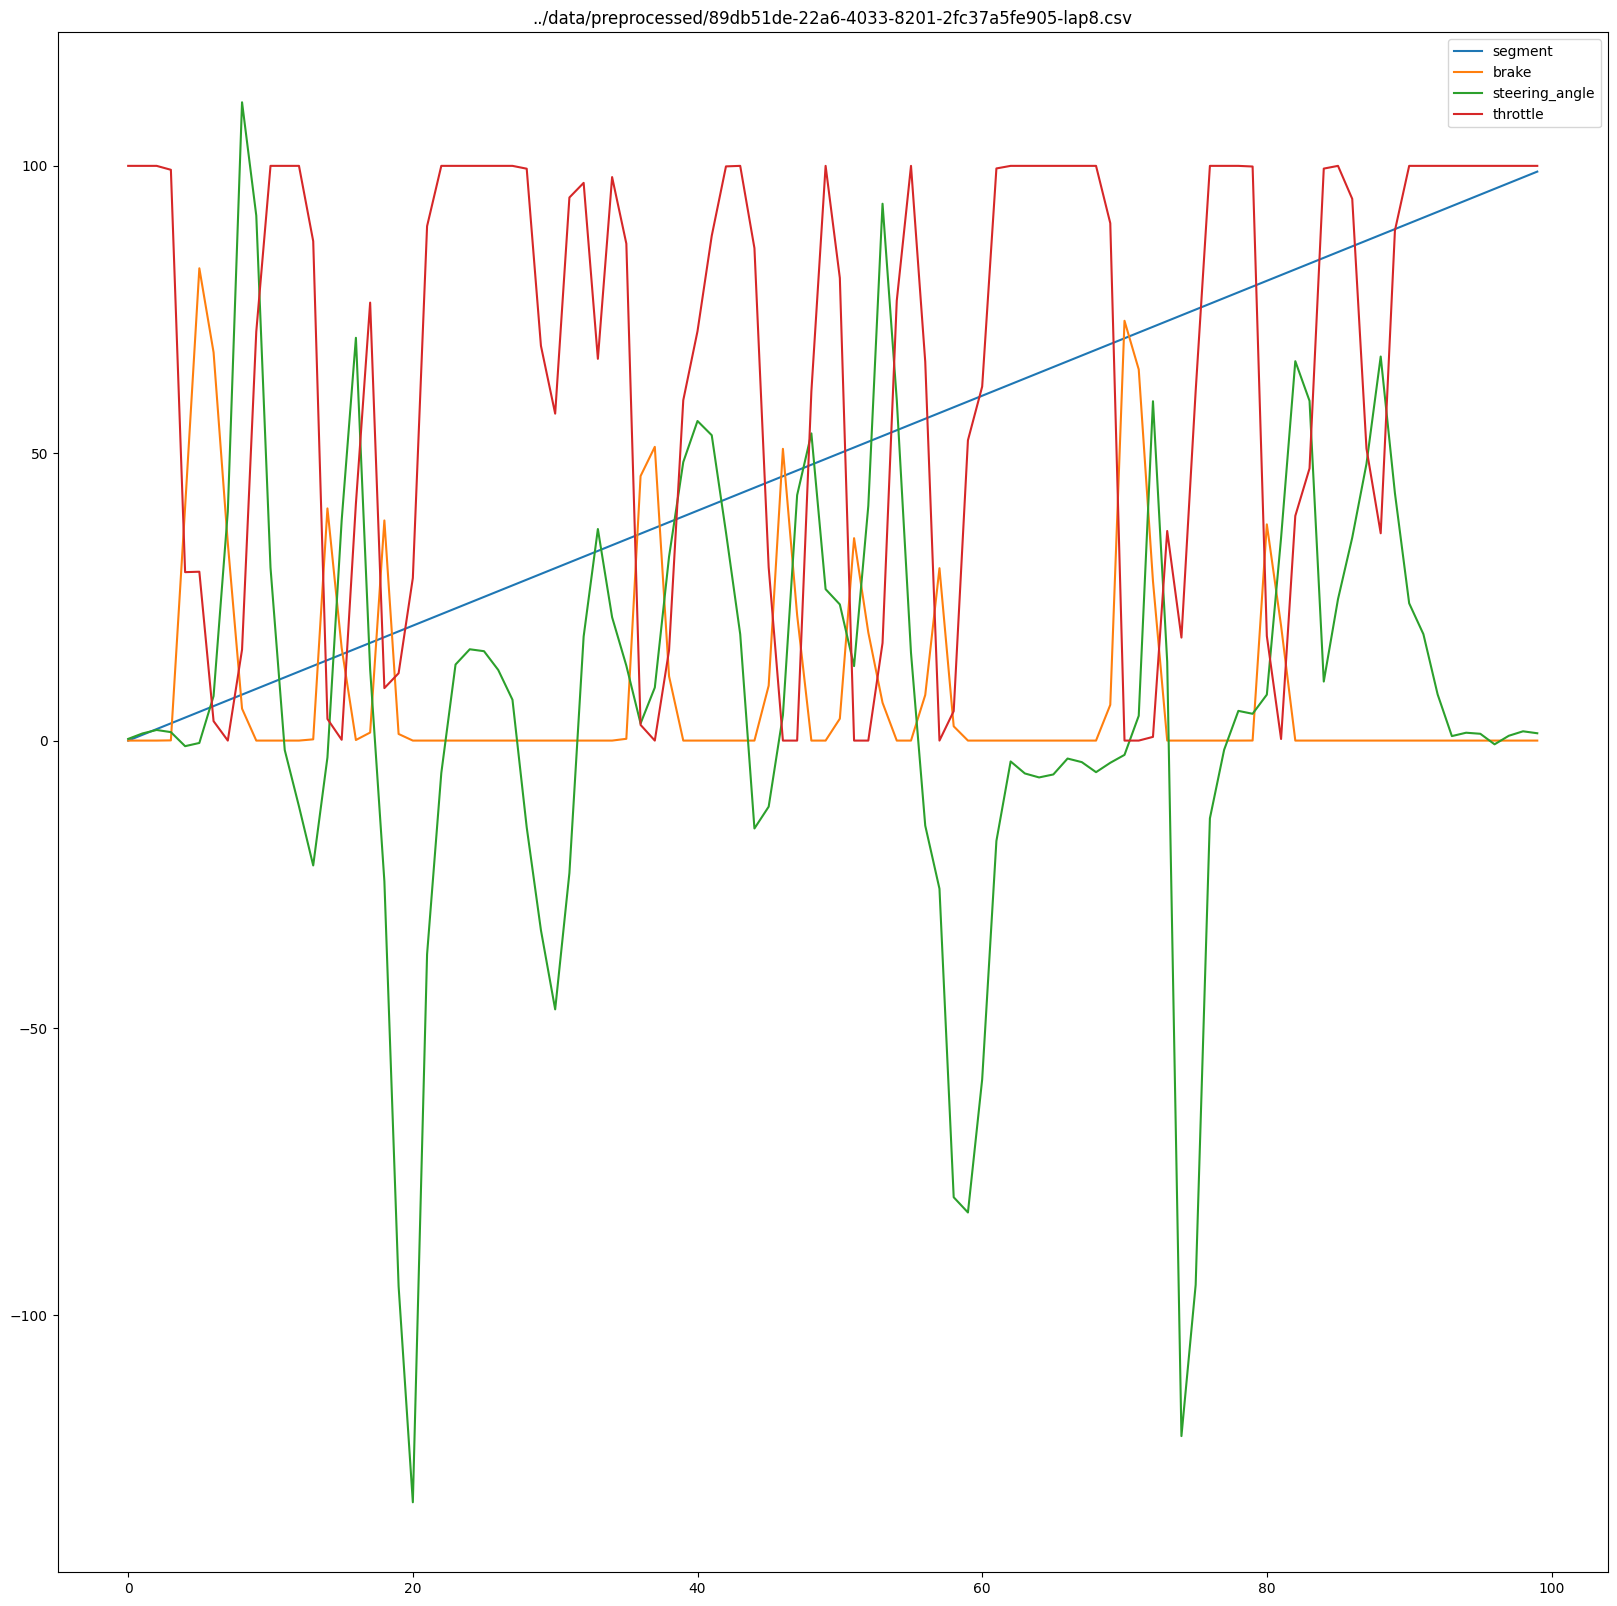

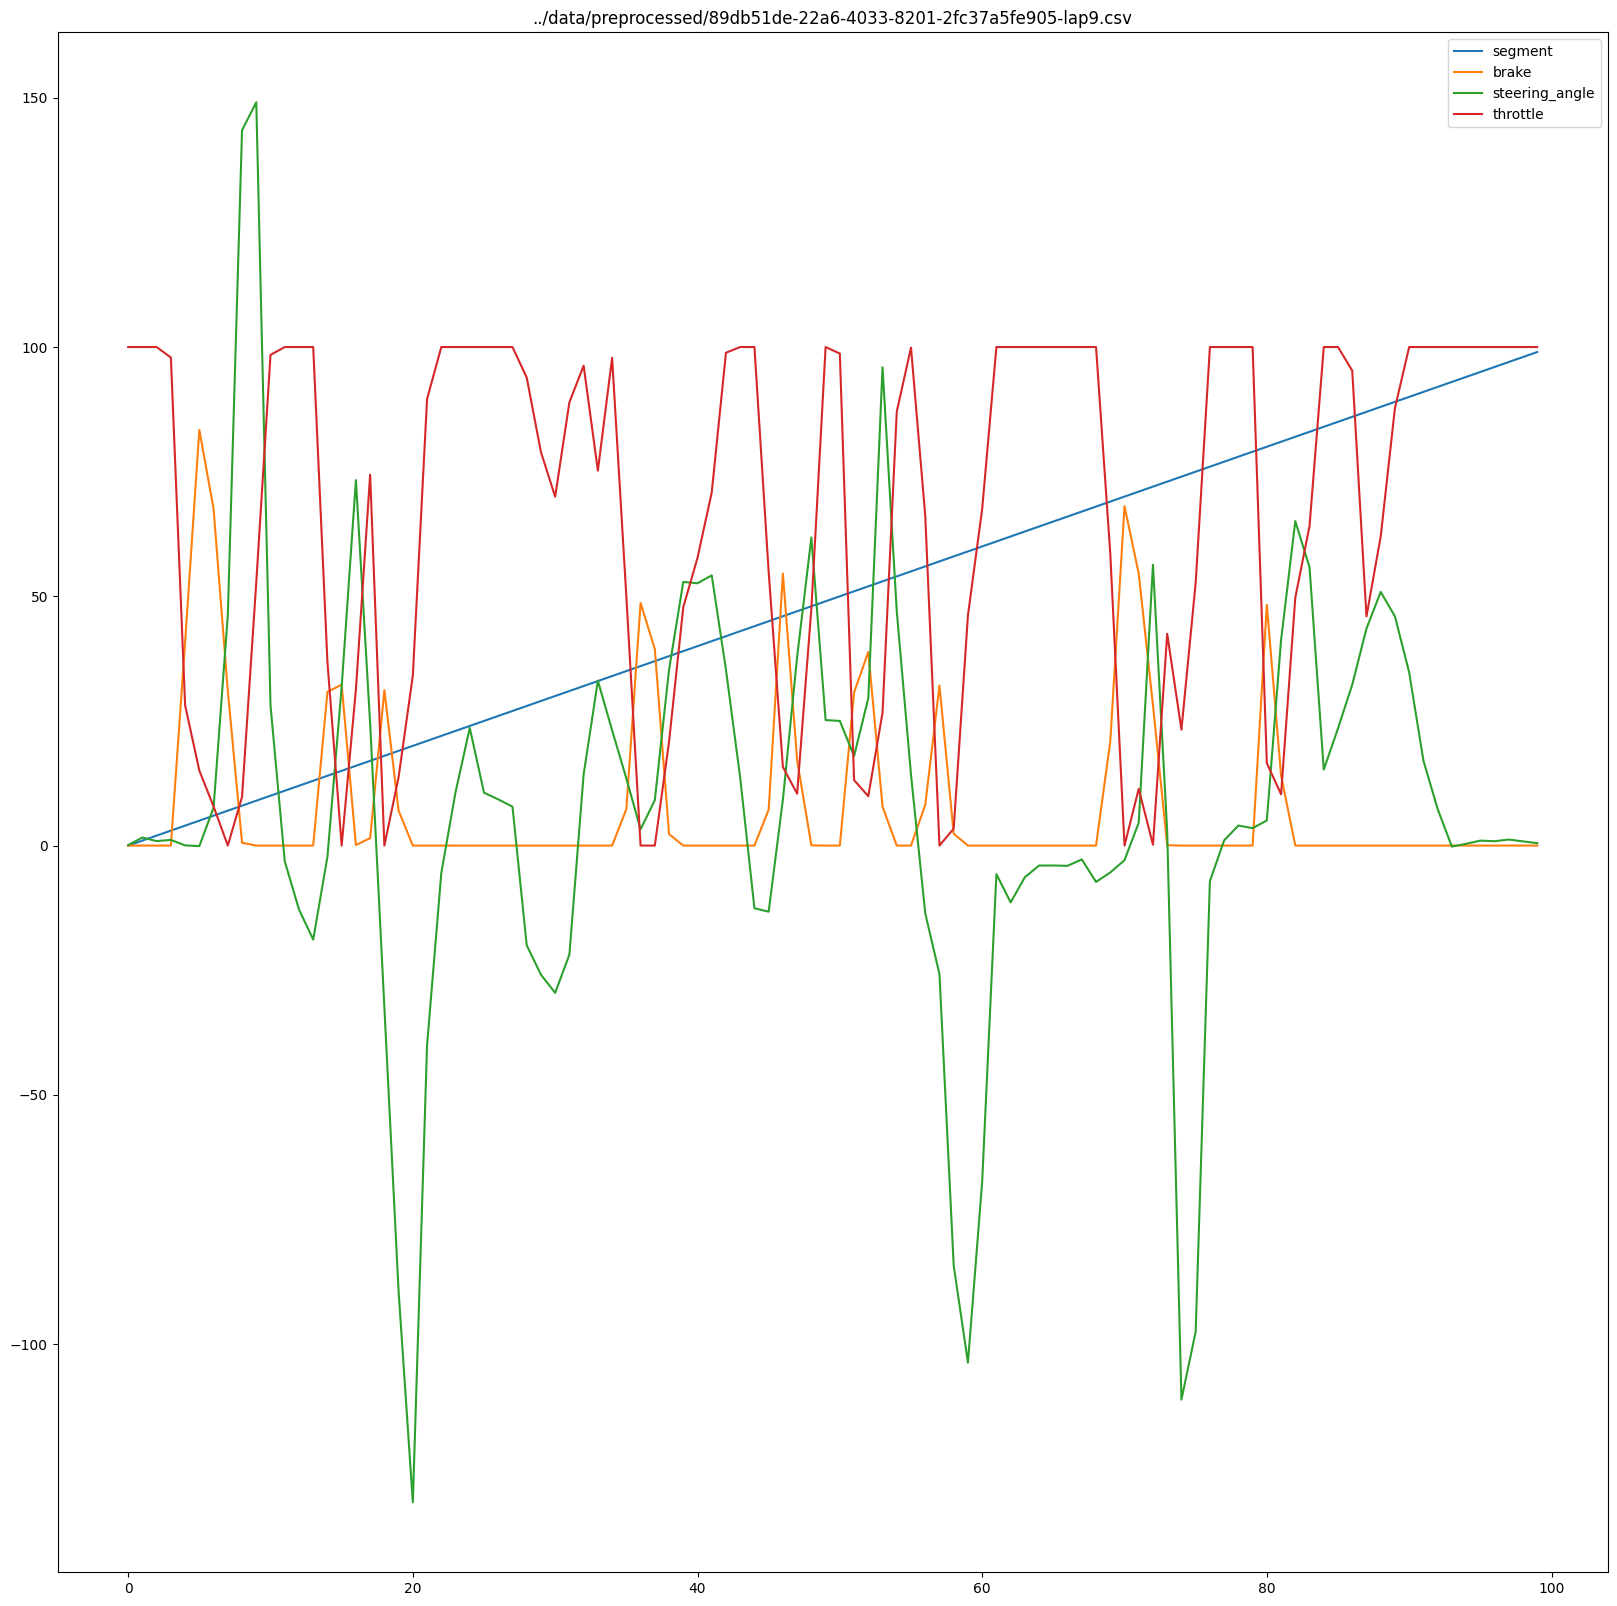

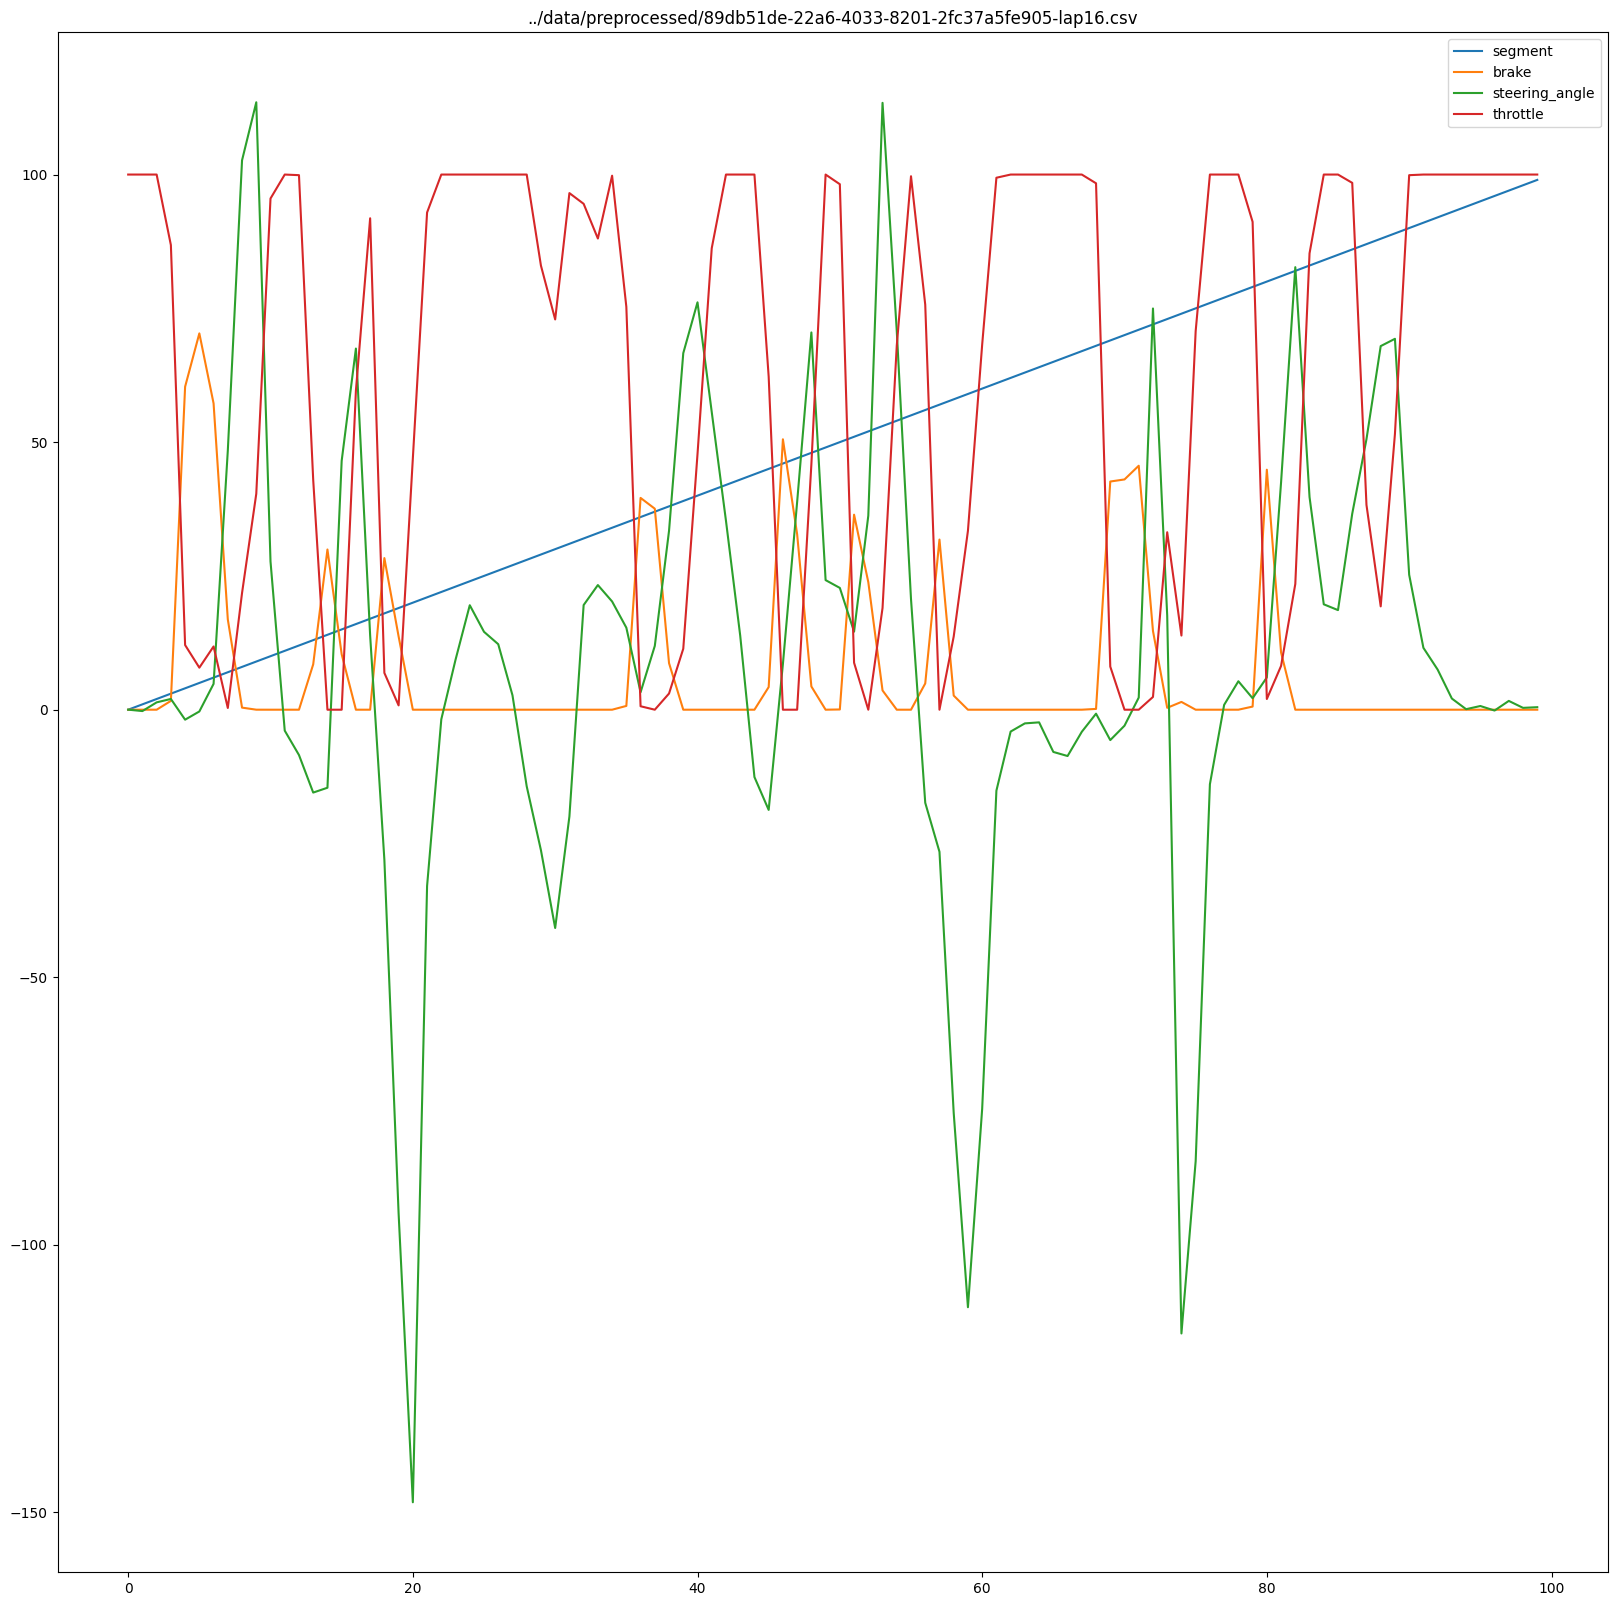

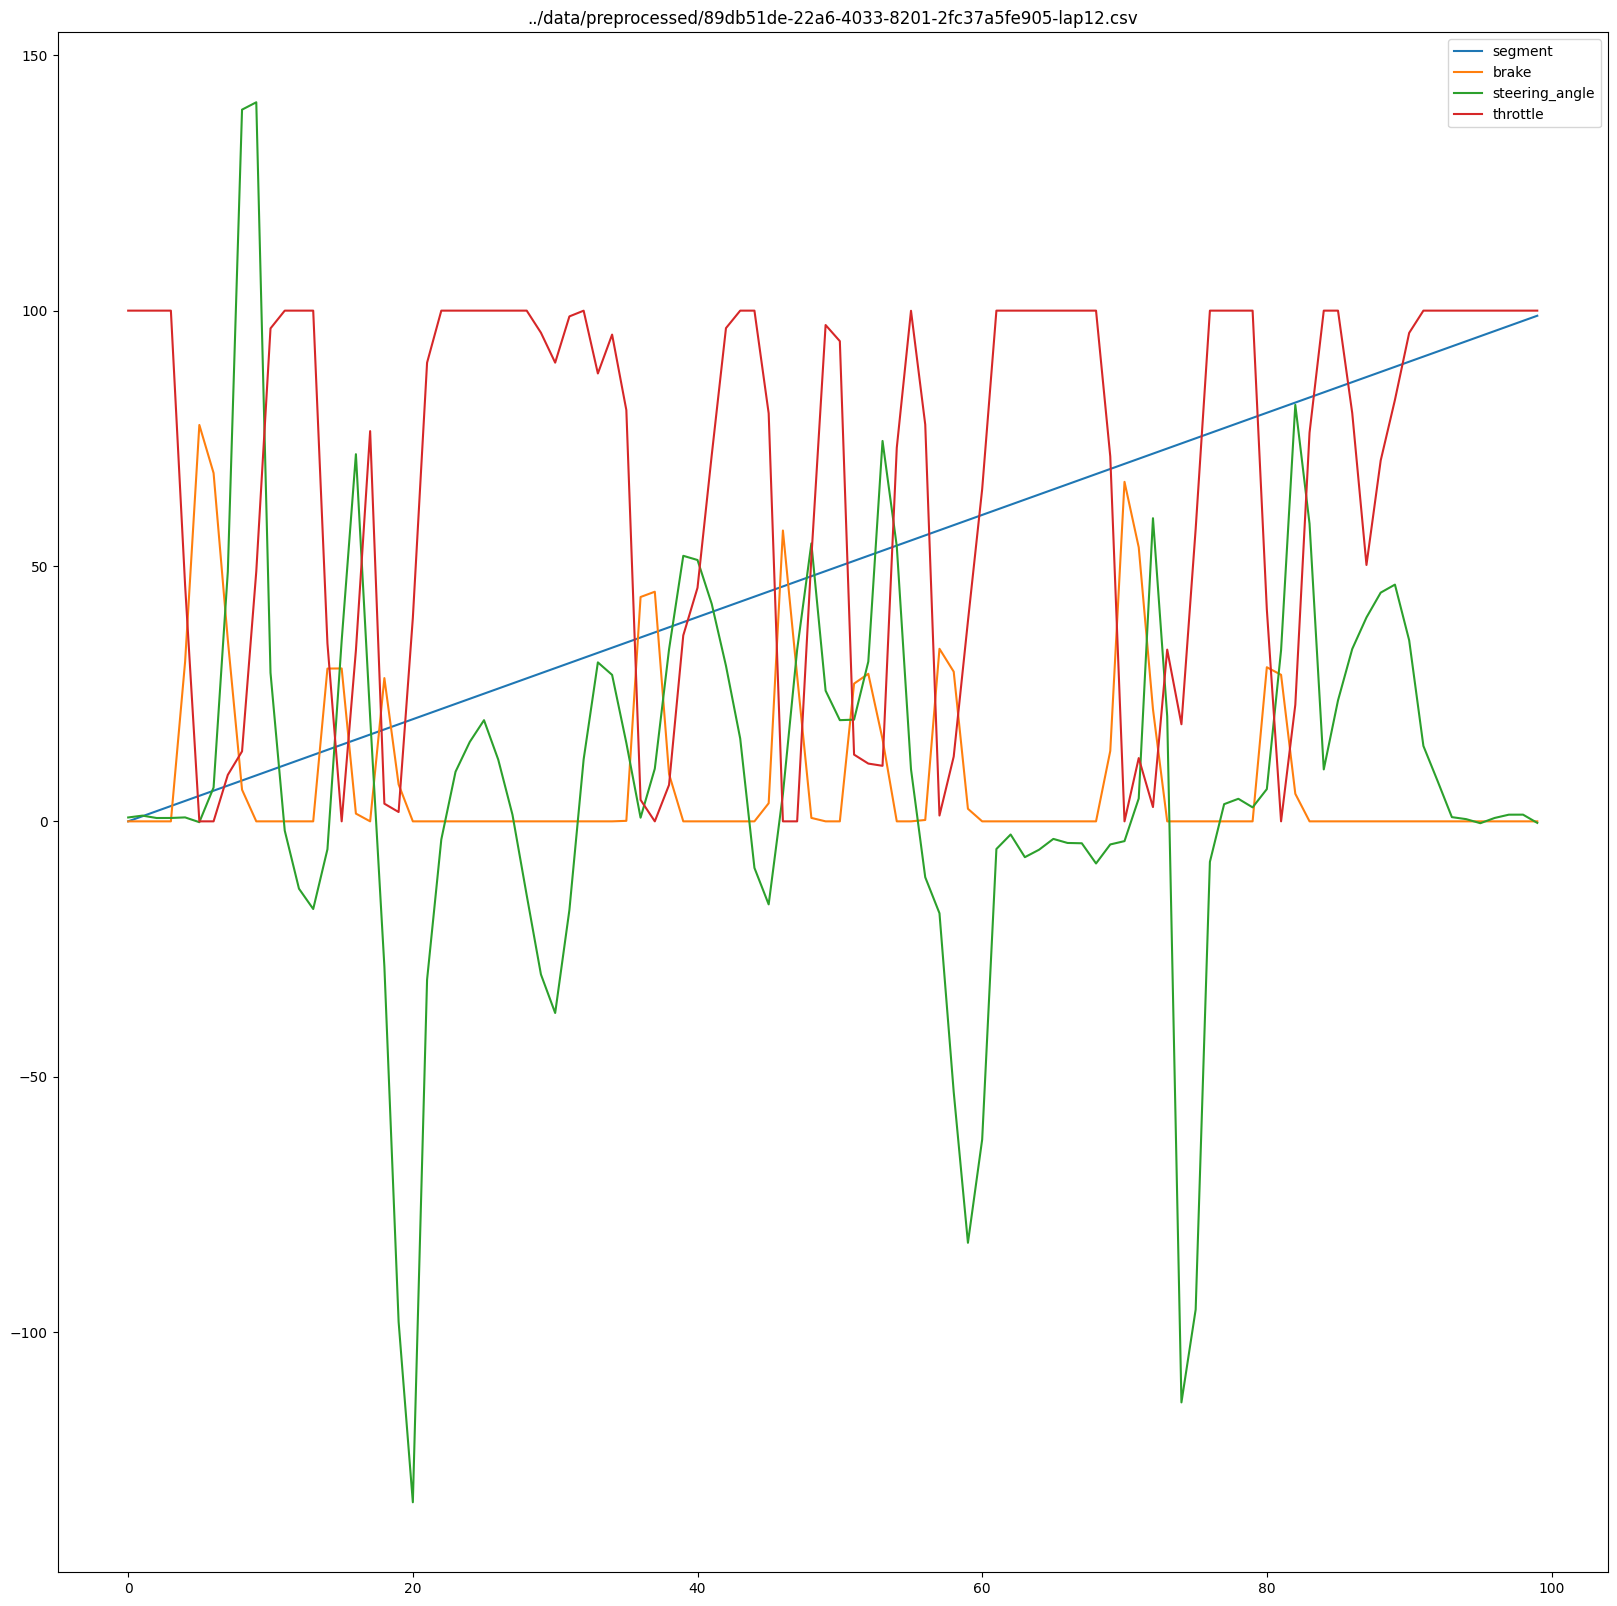

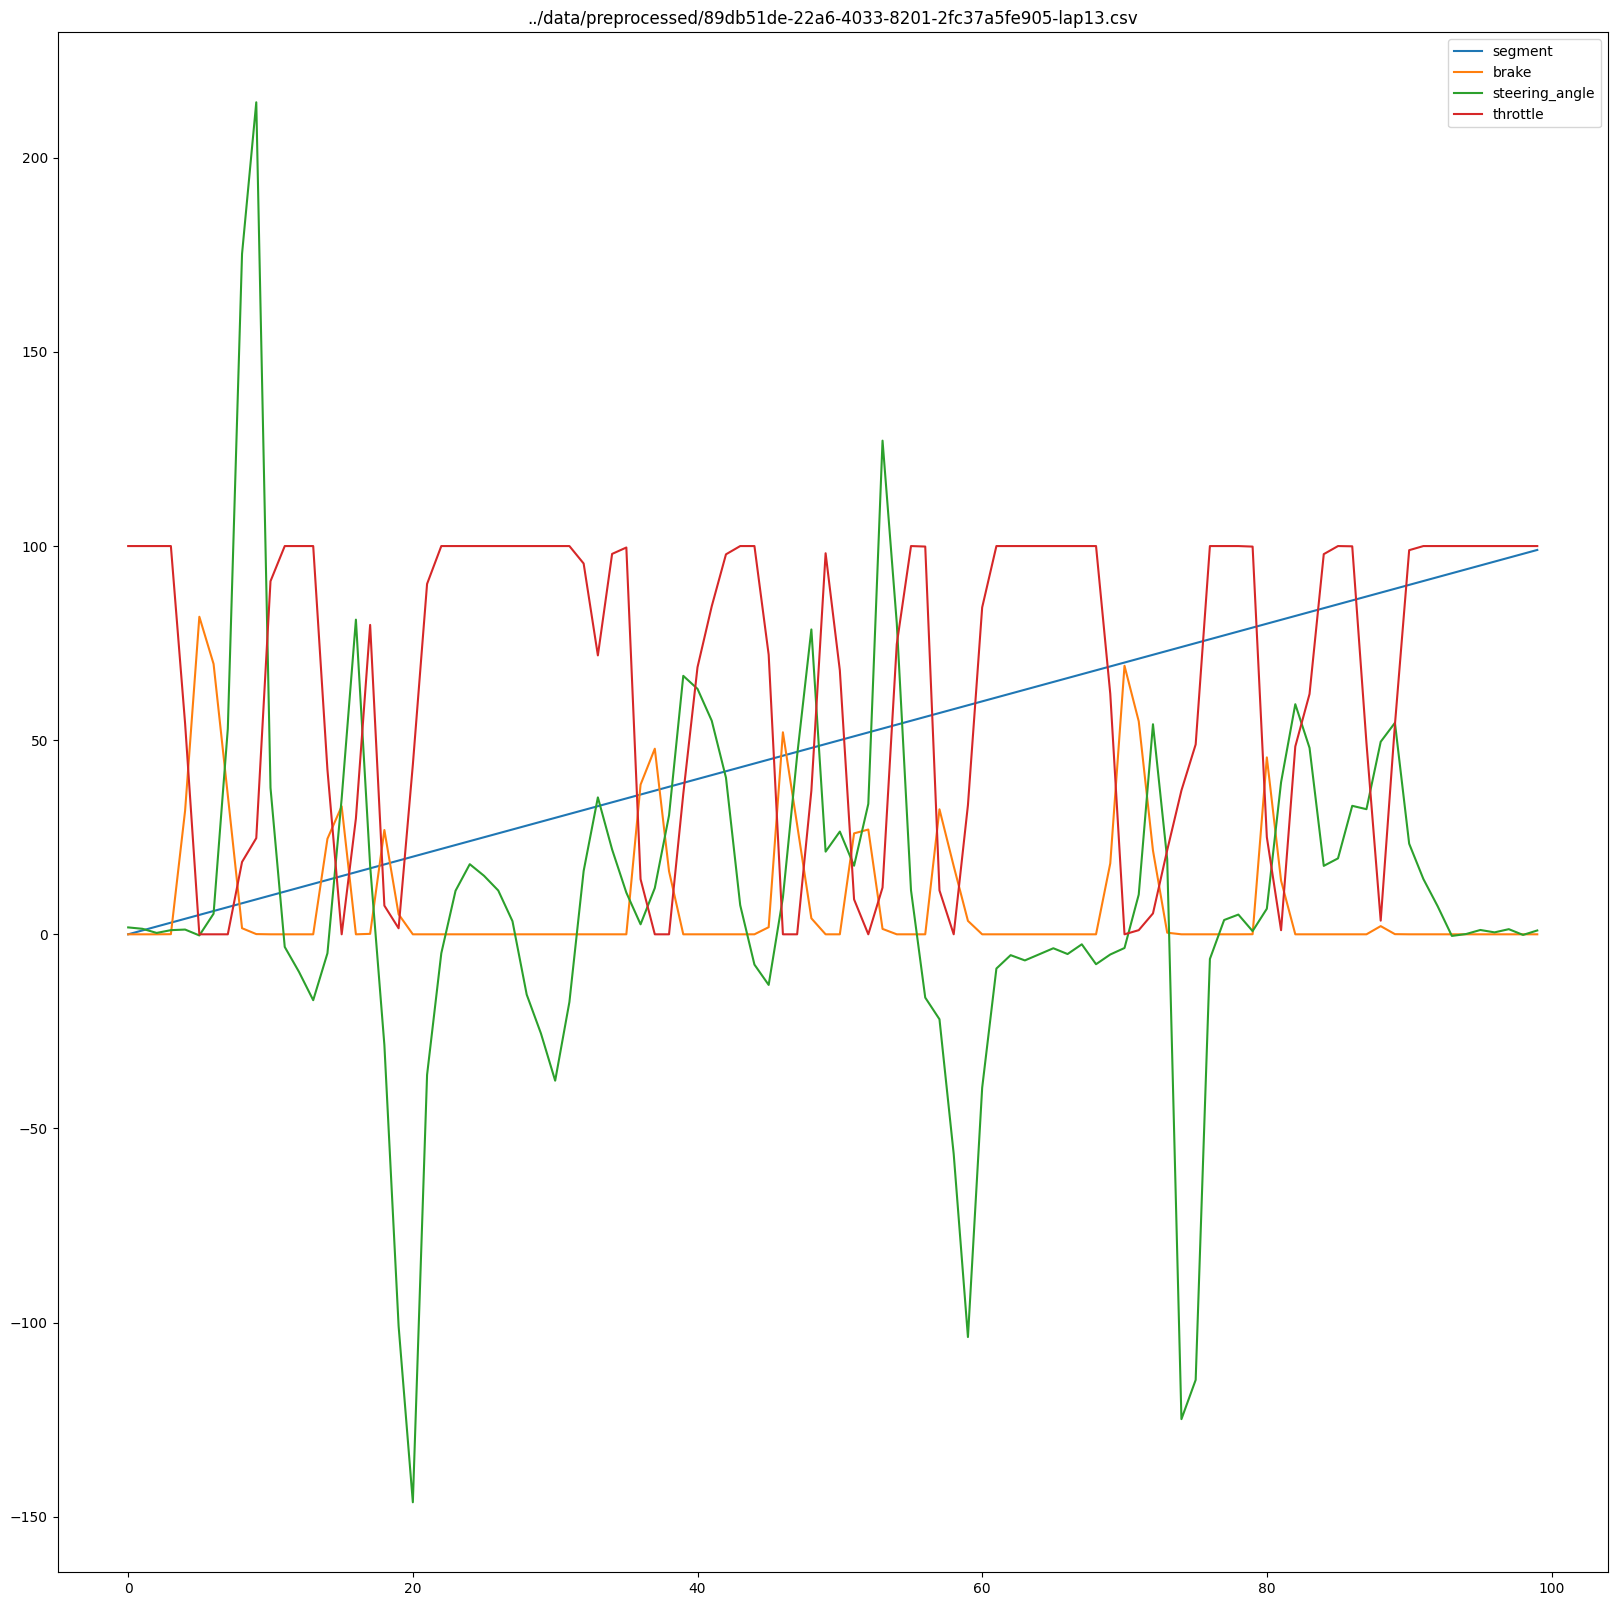

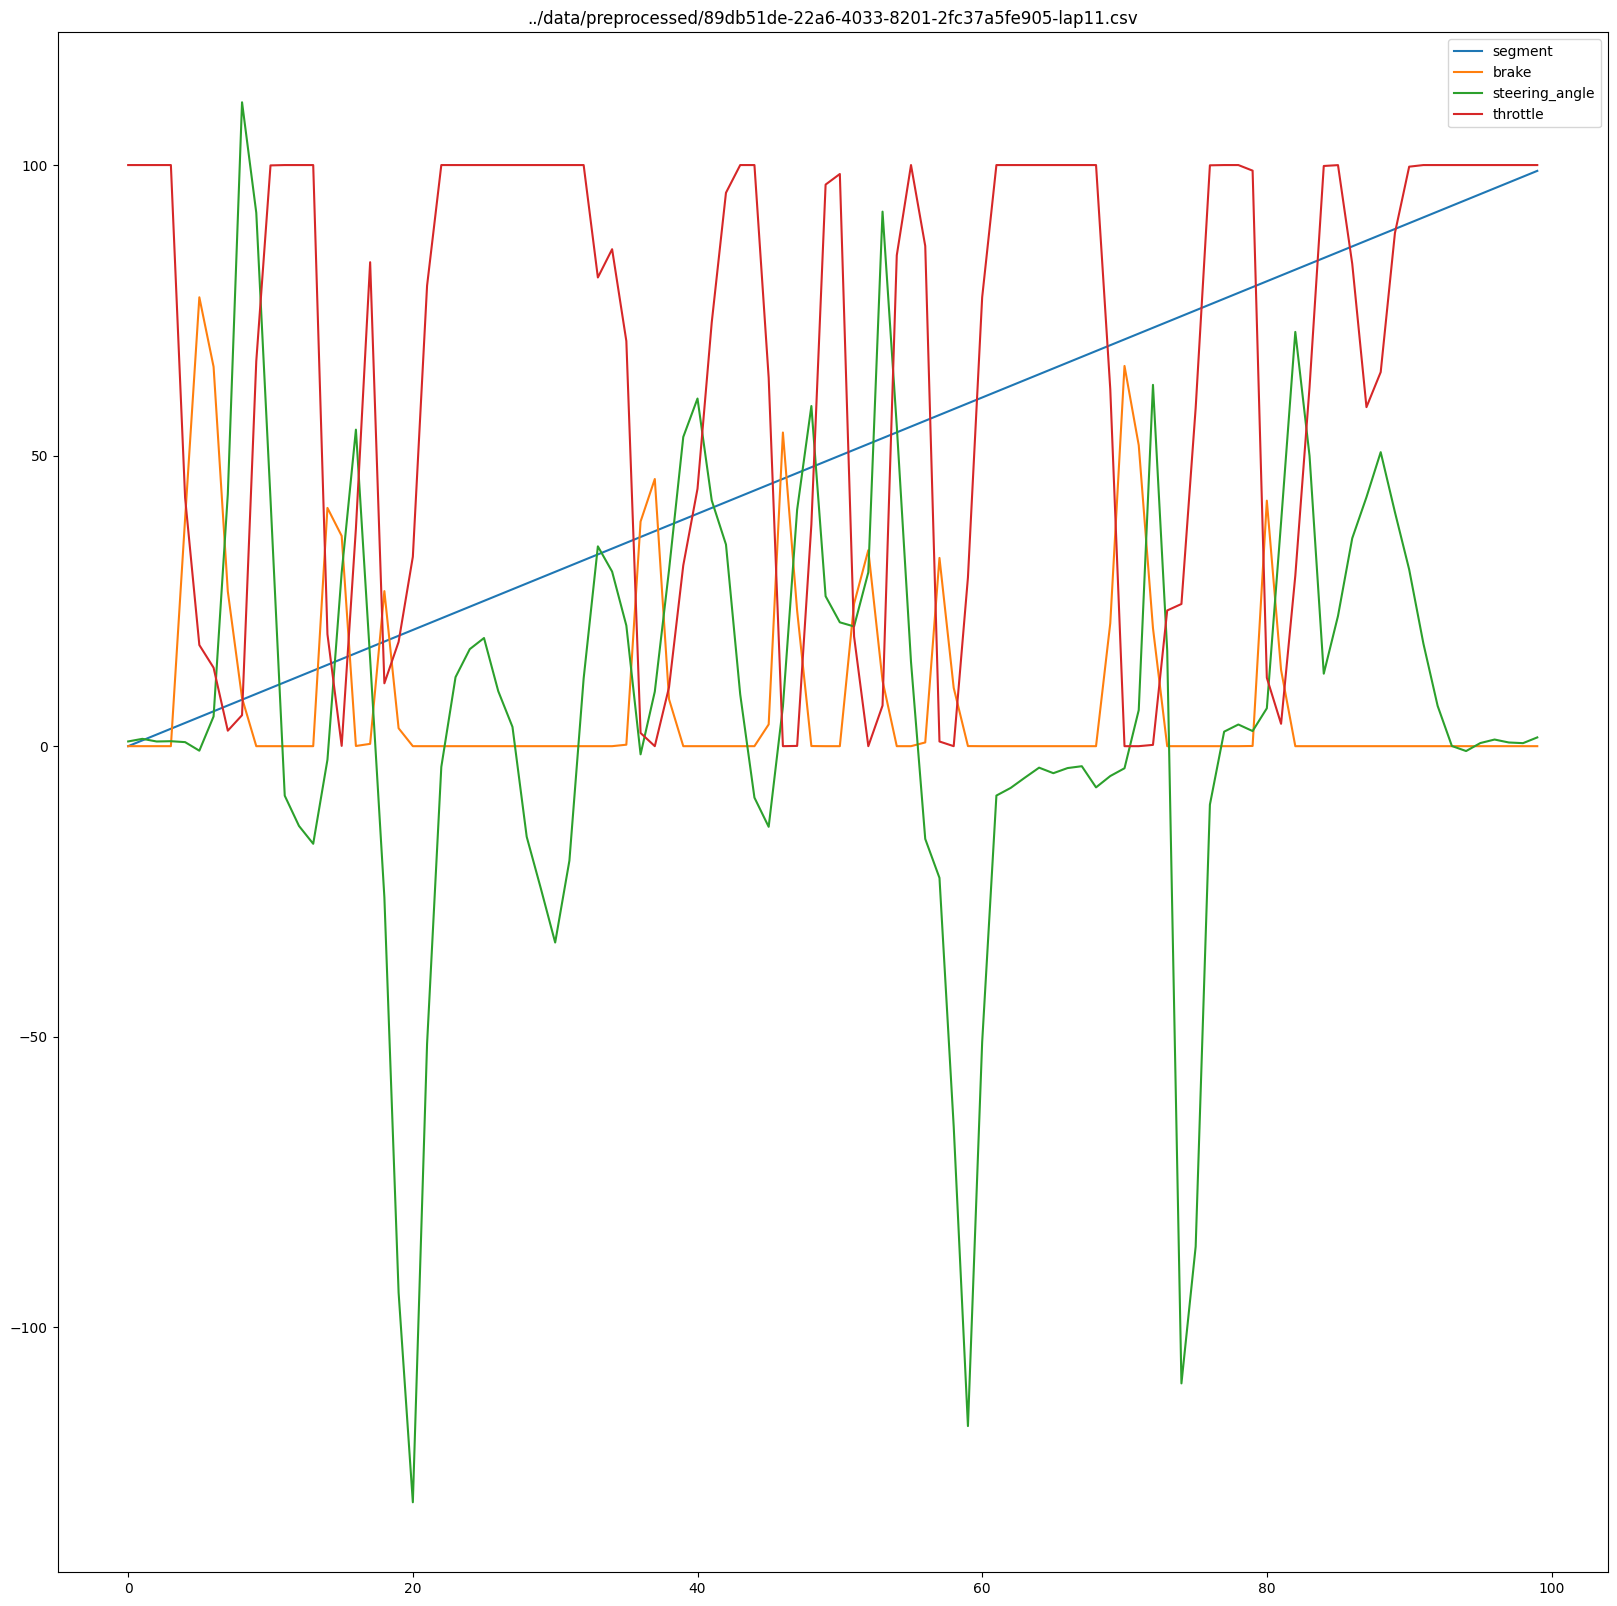

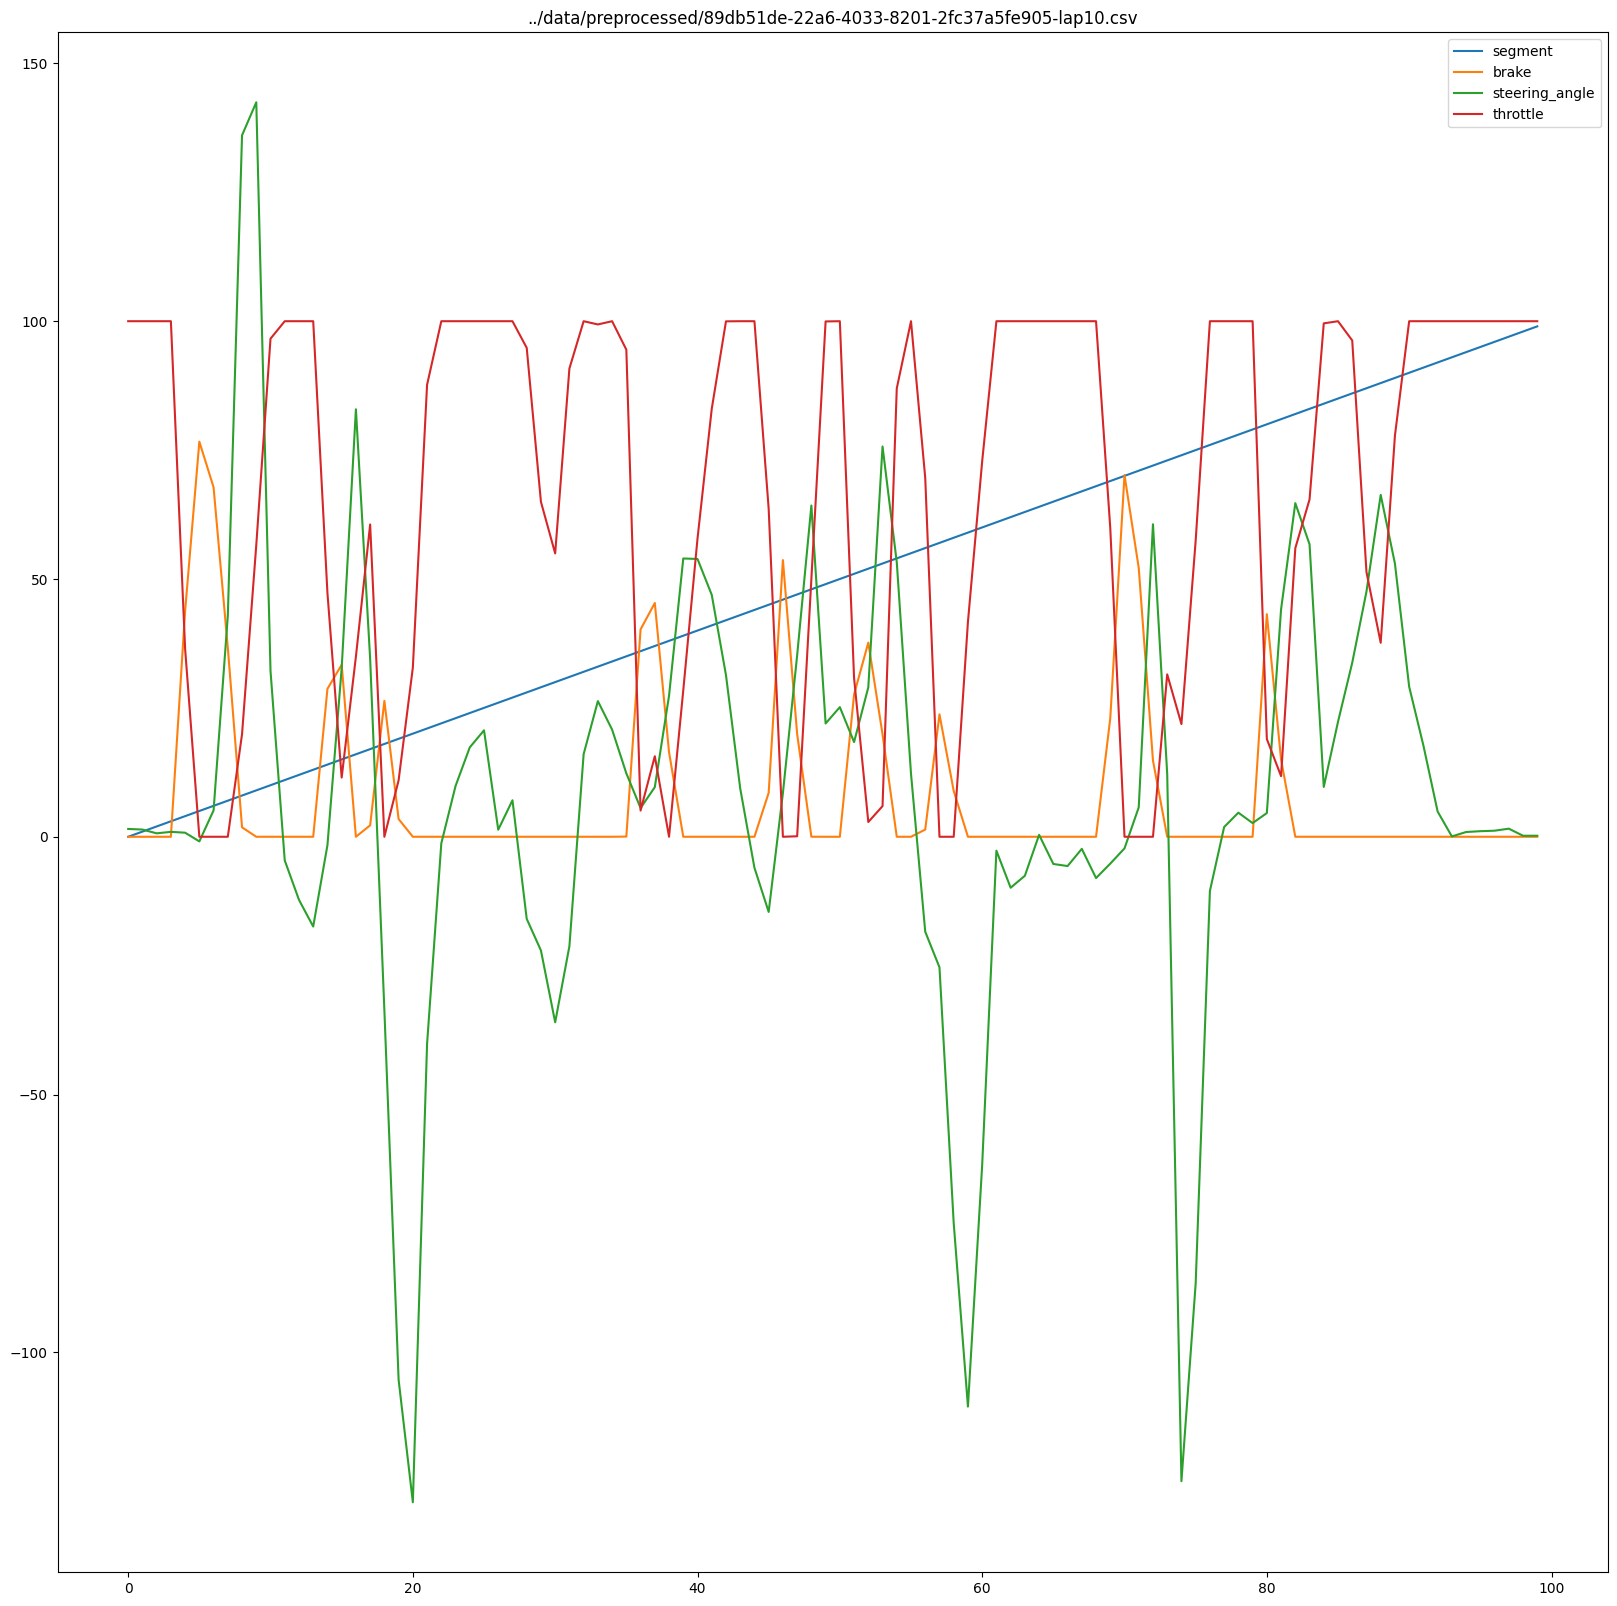

In [18]:
import pathlib
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

dfs = list()

for path in pathlib.Path().glob("../data/preprocessed/*.csv"):
    df = pd.read_csv(path)
    df["lap"] = path.name.split("-")[-1].split(".")[0]
    dfs.append(df)
    df.plot()
    plt.title(path)
    # df -=df.mean()
    # df /= df.std()
    # df.plot()
df = pd.concat(dfs).reset_index(drop=True)
df

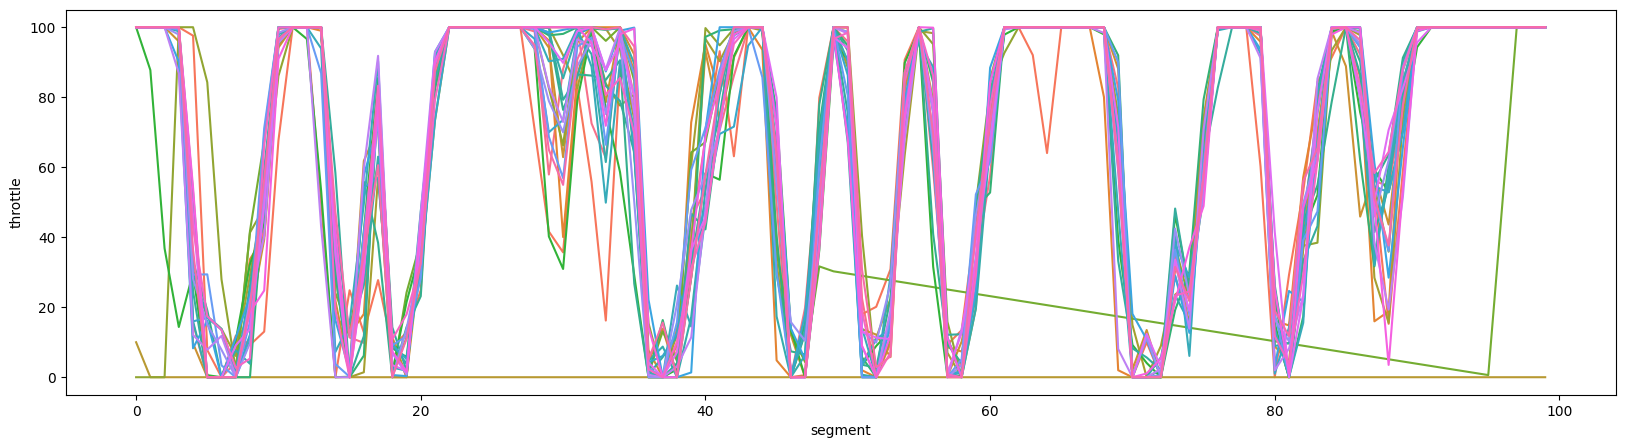

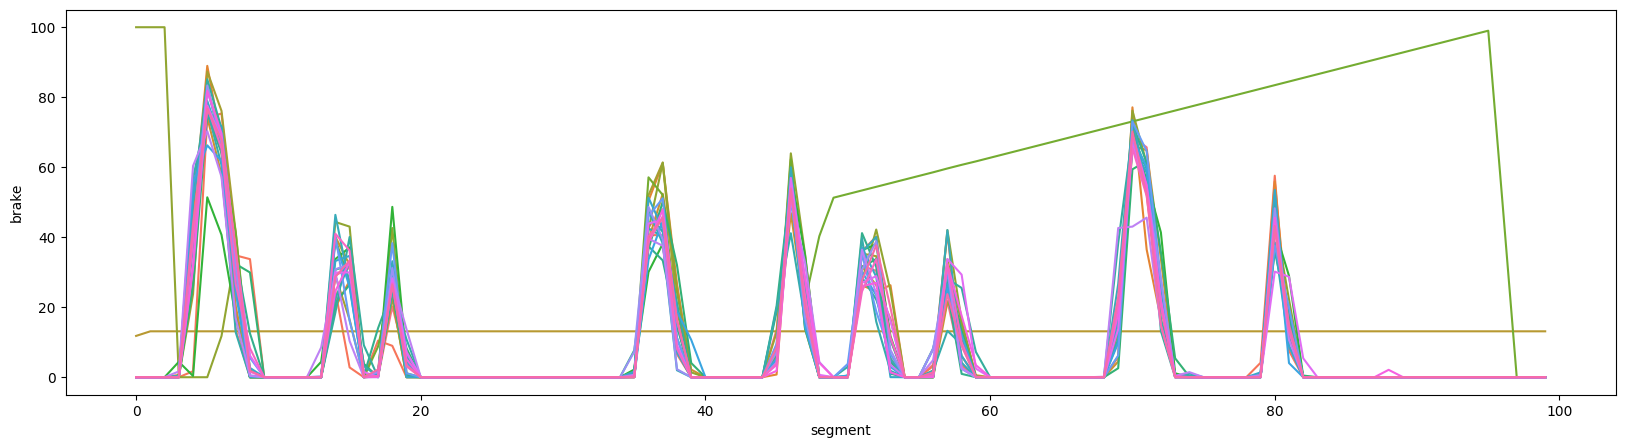

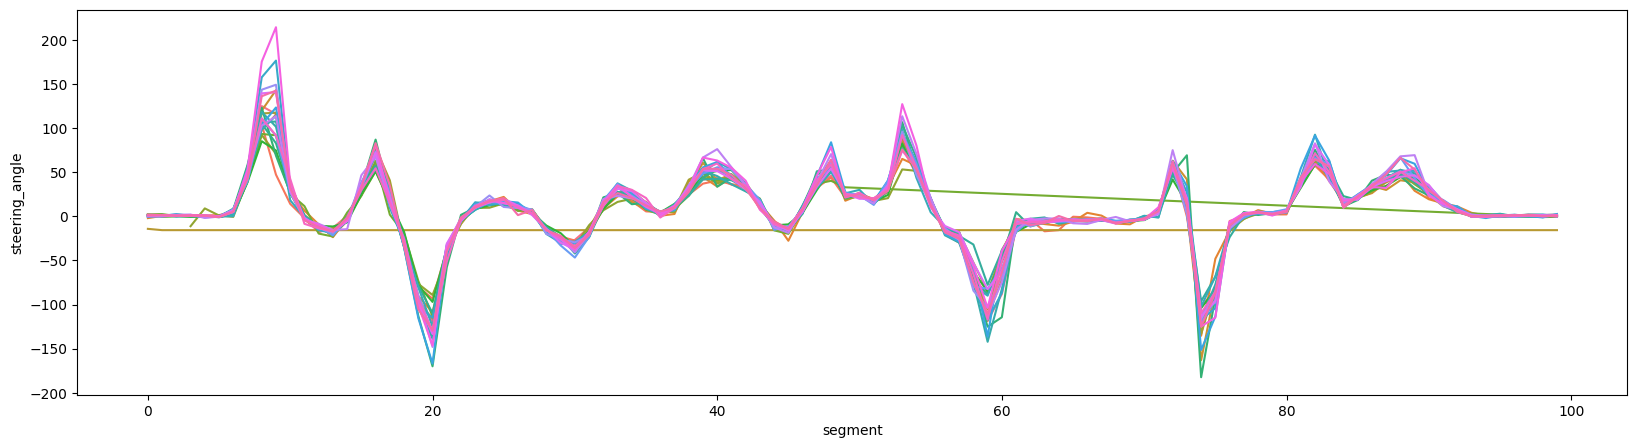

In [19]:
plt.rcParams["figure.figsize"] = (20, 5)
for c in "throttle", "brake", "steering_angle":
    sns.lineplot(data=df, x="segment", y=c, hue="lap", legend=False)
    plt.show()